<p style="text-align:center"><strong style="font-size:22px">PROJET : ANALYSE ET OPTIMISATION DE PORTEFEUILLE PAR SECTEUR AVEC YFINANCE</strong></p>

<hr>


## [1. Collecte et Preparation des Donnees](#section_1)
- [1.1. Preparation de l’Environnement Python](#section_1_1)
- [1.2. Recuperation des Instruments Financiers par Secteur](#section_1_2)
- [1.3. Consolidation des Tickers et Telechargement des Donnees Historiques](#section_1_3)
- [1.4. Nettoyage et Structuration des Donnees](#section_1_4)
## [2. Analyse de Performance par Secteur (Analyse Intrasectorielle)](#section_2)

- [2.1. Calcul des Rendements Quotidiens](#section_2_1)
- [2.2. Aggregation Intersectorielle des Performances Moyennes](#section_2_2)
## [3. Optimisation de Portefeuille Intrasectorielle](#section_3)
## [4. Optimisation et Comparaison Intersectorielle](#section_4)
- [4.1. Aggregation des Performances Sectorielles](#section_4_1)
- [4.2. Optimisation de la Répartition Globale entre Secteurs](#section_4_2)
- [4.3. Optimisation sur l’Ensemble des Actions (Hors Structure Sectorielle)](#section_4_3)
- [4.4. Comparaison des Performances Cumulées : Portefeuilles Optimisés vs S&P500](#section_4_4)
## [5. Clustering et Optimisation par Groupes d’Actifs](#section_5)
- [5.1. Clustering Dynamique et Optimisation Globale de Portefeuille](#section_5_2)
## [6. Visualisation et Analyse des Résultats](#section_6)





> ⚠️ **Remarque importante concernant l’exécution du code :**

- Le **temps d’exécution complet du notebook** est estimé entre **35 et 40 minutes**, principalement en raison du **chargement des données financières** via `yfinance`, couvrant tous les instruments sur la période **2010–2024**.

- Certains blocs peuvent exiger un **redémarrage du noyau Python**, notamment si l’exécution est interrompue ou ralentie par une surcharge mémoire (phénomène courant avec Jupyter sur macOS).

- Une logique de **résilience a été mise en place** : si un **ticker est invalide ou indisponible**, le script affiche un message et passe au suivant automatiquement, sans interrompre le reste du processus.

- Pour l’analyse intrasectorielle (**partie 3**), nous avons **conservé tous les tickers**, même ceux présentant des données atypiques (comme `SZRF`), afin de ne pas biaiser la couverture sectorielle.


- Le **traitement des valeurs manquantes** repose volontairement sur la méthode dexclure les tickers n'ayant pas de donnees exacte entre 2010 et 2024

- Nous faisons une analyse finale sur les graphiques à la fin du projet 

- Bonne lecture 





# 1. Collecte et Preparation des Donnees <a class="anchor" id="section_1"></a>

Cette première section consiste à identifier et récupérer les instruments financiers pertinents pour chaque secteur économique, à savoir :

- Les **ETFs** (Exchange Traded Funds)  
- Les **fonds mutuels**  
- Les **entreprises cotées**

Les données historiques de prix (clôture, volume, etc.) sont ensuite téléchargées pour la période allant de **2010 à 2024**.  
Elles sont nettoyées afin d’assurer leur qualité (traitement des valeurs manquantes, cohérence temporelle) et structurées pour être exploitables lors des analyses ultérieures.




### Préparation de l’Environnement Python <a class="anchor" id="section_1_1"></a>

Avant d’entamer l’analyse, cette étape consiste à :

- Installer les packages nécessaires avec les versions spécifiées pour garantir la reproductibilité.
- Importer les bibliothèques utilisées tout au long du projet, incluant celles pour la manipulation de données, l’optimisation, la visualisation et le clustering.

Les bibliothèques principales utilisées sont : `pandas`, `numpy`, `scipy`, `matplotlib`, `seaborn`, `scikit-learn` et `yfinance`.


In [126]:
# Installation des packages (versions indiquées)
!pip install pandas==2.1.4 scipy==1.10.1 matplotlib==3.7.3 seaborn==0.12.2 scikit-learn==1.3.2
!pip install yfinance --upgrade

# Importations
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches


113820.57s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached pandas-2.1.4.tar.gz (4.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [72 lines of output]
      + meson setup /private/var/folders/3_/d1ldk5_n32v2dyp4w17y8xjm0000gn/T/pip-install-d_xajk32/pandas_64df975d57c84c2fa4bd06808e4d0a94 /private/var/folders/3_/d1ldk5_n32v2dyp4w17y8xjm0000gn/T/pip-install-d_xajk32/pandas_64df975d57c84c2fa4bd06808e4d0a94/.mesonpy-_z7z3apx/build -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --vsenv --native-file=/private/var/folders/3_/d1ldk5_n32v2dyp4w17y8xjm0000gn/T/pip-install-d_xajk32/pandas_64df975d57c84c2fa4bd06808e4d0a94/.mesonpy-_z7z3apx/build/meson-python-native-file.ini
      The Meson build system
      Version: 1.2.1
      Source dir: /private/var/folders/3_/d1ldk5

113848.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


### Récupération des instruments financiers par secteur <a class="anchor" id="section_1_2"></a>

Pour chaque secteur défini, cette étape utilise `yfinance` pour extraire les principaux **ETFs**, **fonds mutuels** et **entreprises cotées**.  
Les tickers sont ensuite organisés dans un dictionnaire structuré afin de faciliter le traitement ultérieur.


In [134]:

# Liste des secteurs
sectors = [
    "technology", "financial-services", "healthcare", "energy", "industrials",
    "basic-materials", "consumer-cyclical", "consumer-defensive", "communication-services",
    "real-estate", "utilities"
]

# Dictionnaire pour stocker les tickers des instruments par secteur
sector_instruments = {}

# Récupération des instruments pour chaque secteur
for sector in sectors:
    sector_data = yf.Sector(sector)

    # Extraction des tickers
    etfs = list(sector_data.top_etfs.keys())  # Juste les tickers
    mutual_funds = list(sector_data.top_mutual_funds.keys())  # Juste les tickers
    companies_df = sector_data.top_companies

    # Si les compagnies sont sous forme de DataFrame, on extrait uniquement les tickers (index)
    companies = companies_df.index.tolist() if isinstance(companies_df, pd.DataFrame) and not companies_df.empty else []

    # Stockage des résultats
    sector_instruments[sector] = {
        'etfs': etfs,
        'mutual_funds': mutual_funds,
        'companies': companies
    }

    # Affichage des résultats pour chaque secteur
    print(f"\n{sector.capitalize()} Sector:")
    print(f"ETFs: {etfs}")
    print(f"Mutual Funds: {mutual_funds}")
    print(f"Companies: {companies}")

print(sector_instruments)

instrument_types = ["etfs", "mutual_funds", "companies"]

print (sectors)


Technology Sector:
ETFs: ['VGT', 'XLK', 'SMH', 'IYW', 'FTEC', 'SOXX', 'IGV', 'CIBR', 'FNGU', 'IGM']
Mutual Funds: ['VITAX', 'FDYNX', 'FDYZX', 'FDNRX', 'FDTRX', 'FKDNX', 'FSELX', 'FSPTX', 'SCIOX', '0P00018S6Z']
Companies: ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'ORCL', 'CRM', 'CSCO', 'IBM', 'ACN', 'PLTR', 'INTU', 'NOW', 'ADBE', 'QCOM', 'TXN', 'UBER', 'AMD', 'ADP', 'FI', 'AMAT', 'ANET', 'ADI', 'INTC', 'KLAC', 'CRWD', 'LRCX', 'APP', 'MU', 'APH', 'MSI', 'FTNT', 'CDNS', 'MSTR', 'SNPS', 'ROP', 'WDAY', 'ADSK', 'DELL', 'PAYX', 'PANW', 'TEAM', 'MRVL', 'SNOW', 'FICO', 'NXPI', 'FIS', 'TEL', 'GRMN', 'GLW', 'NET']

Financial-services Sector:
ETFs: ['XLF', 'VFH', 'IYF', 'KBWB', 'KRE', 'FAS', 'FNCL', 'FXO', 'KBE', 'IYG']
Mutual Funds: ['VFAIX', 'TFIFX', 'PRISX', '0P000152G3', '0P000152G4', '0P0001S0HL', '0P00003CN2', 'VARBX', 'VARAX', 'VARCX']
Companies: ['BRK-B', 'JPM', 'V', 'MA', 'BAC', 'WFC', 'MS', 'GS', 'AXP', 'RY', 'BX', 'PGR', 'C', 'SPGI', 'SCHW', 'BLK', 'CB', 'MMC', 'TD', 'CME', 'KKR', 'ICE', 'AON',

### Consolidation des tickers et téléchargement des données historiques <a class="anchor" id="section_1_3"></a>

Les tickers de tous les instruments (ETFs, fonds mutuels et entreprises) sont regroupés pour l’ensemble des secteurs.  
Les données de prix quotidiens sont ensuite téléchargées via `yfinance` sur la période allant de **2010 à 2024**, afin de constituer la base de données financière nécessaire à l’analyse.



In [128]:
all_etfs = []
all_mutual_funds = []
all_companies = []

# Récupération des tickers pour chaque secteur
for sector in sectors:
    sector_data = yf.Sector(sector)

    # Ajout des tickers d'ETFs et fonds mutuels
    all_etfs.extend(sector_data.top_etfs.keys())
    all_mutual_funds.extend(sector_data.top_mutual_funds.keys())

    # Vérification et ajout des tickers des compagnies
    companies_df = sector_data.top_companies
    if isinstance(companies_df, pd.DataFrame) and not companies_df.empty:
        all_companies.extend(companies_df.index.tolist())

'''
print("Tous les ETFs:", all_etfs)
print("Tous les Mutual Funds:", all_mutual_funds)
print("Toutes les Companies:", all_companies)
'''

# Période d'analyse
start_date = "2010-01-01"
end_date = "2024-12-31"



# Téléchargement des données
etf_data = yf.download(all_etfs, start=start_date, end=end_date,interval='1d').dropna(axis=1)
mutual_funds_data = yf.download(all_mutual_funds, start=start_date, end=end_date,interval='1d').dropna(axis=1)
companies_data = yf.download(all_companies, start=start_date, end=end_date,interval='1d').dropna(axis=1)




[*********************100%***********************]  110 of 110 completed
[*********************100%***********************]  110 of 110 completed
[*********************100%***********************]  550 of 550 completed


### Nettoyage et structuration des données <a class="anchor" id="section_1_4"></a>

Les données financières brutes sont nettoyées afin d'assurer leur continuité temporelle.  
Les valeurs manquantes sont comblées (par propagation avant/après), puis les données sont organisées par type de prix (`Open`, `High`, `Low`, `Close`, `Volume`) pour chaque instrument.  
Ce traitement garantit une base cohérente et exploitable pour les étapes d’analyse et d’optimisation à venir.



In [129]:
# Extraction des prix et volumes
etf_close = etf_data["Close"]  # Prix de clôture
etf_volumes = etf_data["Volume"]  # Volumes d'échange

mutual_funds_close = mutual_funds_data["Close"]  # Prix de clôture
mutual_funds_volumes = mutual_funds_data["Volume"] # Volumes d'échange

companies_close = companies_data["Close"]  # Prix de clôture
companies_volumes = companies_data["Volume"] # Volumes d'échange

# Affichage des volumes pour vérification
#print(etf_volumes)

# Affichage des datasets nettoyés
#print("\n=== Données ETFs ===")
print(etf_close)

"""""
print("\n=== Données Mutual Funds ===")
print(mutual_funds_close)"""

'''print("\n=== Données Companies ===")
print(companies_data)'''

Ticker             FAS         FBT        FXD        FXG         FXH  \
Date                                                                   
2010-01-04    9.924303   28.278704  13.416715  14.260191   21.636049   
2010-01-05   10.305123   28.210234  13.575388  14.299899   21.626204   
2010-01-06   10.375173   28.621061  13.619460  14.371351   21.626204   
2010-01-07   10.961055   28.728661  13.698805  14.363417   21.862444   
2010-01-08   10.824775   28.846041  13.725247  14.347528   21.960884   
...                ...         ...        ...        ...         ...   
2024-12-23  151.802505  166.479996  65.265770  63.878204  105.312202   
2024-12-24  156.977936  167.220001  65.884315  64.117226  105.522064   
2024-12-26  158.144638  167.979996  66.053909  64.186935  105.941795   
2024-12-27  154.395203  167.179993  65.435371  64.097305  105.542053   
2024-12-30  150.067398  164.850006  64.647240  63.440002  103.733223   

Ticker            FXO        FXR        FXU        FXZ         

'print("\n=== Données Companies ===")\nprint(companies_data)'

## 2. Analyse de Performance par Secteur (Analyse Intrasectorielle) <a class="anchor" id="section_2"></a>

Dans cette section, on évalue la performance historique des instruments financiers à l’intérieur de chaque secteur.

- Les **rendements** sont calculés à partir des prix de clôture.
- Pour chaque secteur, on distingue trois types d'instruments : **ETFs**, **fonds mutuels** et **entreprises cotées**.
- Le **rendement moyen** est utilisé comme indicateur synthétique de performance pour comparer les types d’actifs au sein d’un même secteur.

Cette étape permet de dégager les premiers enseignements sur la dynamique propre à chaque secteur à partir de données empiriques.




### Calcul des rendements quotidiens <a class="anchor" id="section_2_1"></a>

À partir des prix de clôture, cette fonction calcule les **rendements** des instruments financiers sur la période d’étude.  
Les données sont préalablement nettoyées pour garantir la continuité temporelle. Ce traitement est appliqué aux ETFs, fonds mutuels et entreprises de chaque secteur.


In [73]:
def installer(tickers):
    data = yf.download(tickers, start=start_date, end=end_date, progress=False).dropna(axis=1)["Close"].pct_change().iloc[1:]
    return data 

sector_returns = {}
for sector, instrument in sector_instruments.items():
    sector_returns[sector] = {}
    for instrument, tickers in instrument.items():
        if tickers:
            sector_returns[sector][instrument] = installer(tickers)
print (sector_returns["technology"])

{'etfs': Ticker           IGM       IGV       IYW       SMH      SOXX       VGT  \
Date                                                                     
2010-01-05 -0.000182  0.000840 -0.001538 -0.005632 -0.001606 -0.001075   
2010-01-06 -0.007821 -0.005035 -0.007021 -0.002478 -0.003015 -0.006997   
2010-01-07 -0.004583 -0.005060 -0.003794 -0.007807 -0.007863 -0.003794   
2010-01-08  0.008655  0.006569  0.007617  0.020029  0.015037  0.007798   
2010-01-11 -0.004199 -0.004210 -0.004810 -0.003506 -0.003003 -0.004319   
...              ...       ...       ...       ...       ...       ...   
2024-12-23  0.010340 -0.006755  0.010431  0.031373  0.030258  0.009246   
2024-12-24  0.011478  0.011465  0.010079  0.008627  0.010302  0.010981   
2024-12-26  0.000189 -0.002209  0.000363 -0.001750 -0.000313  0.001738   
2024-12-27 -0.013425 -0.015308 -0.014871 -0.010082 -0.008455 -0.015599   
2024-12-30 -0.013416 -0.013101 -0.012028 -0.015056 -0.019672 -0.012478   

Ticker           XLK  
Date 

In [130]:
sector_combined_returns = {}
for sector, instrument in sector_returns.items():
    combined = pd.concat(instrument.values(), axis=1).dropna(how='all') if instrument else pd.DataFrame()
    sector_combined_returns[sector] = combined.sort_index()

print(sector_combined_returns)

{'technology': Ticker           IGM       IGV       IYW       SMH      SOXX       VGT  \
Date                                                                     
2010-01-05 -0.000182  0.000840 -0.001538 -0.005632 -0.001606 -0.001075   
2010-01-06 -0.007821 -0.005035 -0.007021 -0.002478 -0.003015 -0.006997   
2010-01-07 -0.004583 -0.005060 -0.003794 -0.007807 -0.007863 -0.003794   
2010-01-08  0.008655  0.006569  0.007617  0.020029  0.015037  0.007798   
2010-01-11 -0.004199 -0.004210 -0.004810 -0.003506 -0.003003 -0.004319   
...              ...       ...       ...       ...       ...       ...   
2024-12-23  0.010340 -0.006755  0.010431  0.031373  0.030258  0.009246   
2024-12-24  0.011478  0.011465  0.010079  0.008627  0.010302  0.010981   
2024-12-26  0.000189 -0.002209  0.000363 -0.001750 -0.000313  0.001738   
2024-12-27 -0.013425 -0.015308 -0.014871 -0.010082 -0.008455 -0.015599   
2024-12-30 -0.013416 -0.013101 -0.012028 -0.015056 -0.019672 -0.012478   

Ticker           XLK  

In [131]:
etf_returns_daily = etf_close.pct_change().iloc[1:] #pour supprimer la premiere ligne avec NAN
mutual_funds_returns_daily = mutual_funds_close.pct_change().iloc[1:]
companies_returns_daily = companies_close.pct_change().iloc[1:]
# Calcul des rendements
#etf_returns_daily = get_clean_returns(all_etfs, start_date, end_date)
#mutual_funds_returns_daily= get_clean_returns(all_mutual_funds)
#companies_returns_daily= get_clean_returns(all_companies)



# Affichage des résultats
print("\n=== Rendements Quotidiens ETFs ===")
print(etf_returns_daily)

'''print("\n=== Rendements Quotidiens Mutual Funds ===")
print(mutual_funds_returns_daily)

print("\n=== Rendements Quotidiens Companies ===")
print(companies_returns_daily)'''




=== Rendements Quotidiens ETFs ===
Ticker           FAS       FBT       FXD       FXG       FXH       FXO  \
Date                                                                     
2010-01-05  0.038372 -0.002421  0.011827  0.002785 -0.000455  0.004784   
2010-01-06  0.006798  0.014563  0.003246  0.004997  0.000000  0.002381   
2010-01-07  0.056470  0.003759  0.005826 -0.000552  0.010924  0.010293   
2010-01-08 -0.012433  0.004086  0.001930 -0.001106  0.004503 -0.001567   
2010-01-11 -0.000235  0.003052  0.000000  0.001660  0.004034  0.001570   
...              ...       ...       ...       ...       ...       ...   
2024-12-23  0.007619  0.005739 -0.001831 -0.003108  0.001521  0.003519   
2024-12-24  0.034093  0.004445  0.009477  0.003742  0.001993  0.010520   
2024-12-26  0.007432  0.004545  0.002574  0.001087  0.003978  0.005114   
2024-12-27 -0.023709 -0.004762 -0.009364 -0.001396 -0.003773 -0.010176   
2024-12-30 -0.028031 -0.013937 -0.012044 -0.010255 -0.017138 -0.005691   

T

'print("\n=== Rendements Quotidiens Mutual Funds ===")\nprint(mutual_funds_returns_daily)\n\nprint("\n=== Rendements Quotidiens Companies ===")\nprint(companies_returns_daily)'

### Agrégation intrasectorielle des performances moyennes <a class="anchor" id="section_2_2"></a>

Une fois les rendements calculés pour chaque instrument, cette étape consiste à **agréger les performances par secteur**.  
Pour cela, on calcule la moyenne des rendements moyens des ETFs, fonds mutuels et entreprises, afin d’obtenir un indicateur synthétique par secteur.



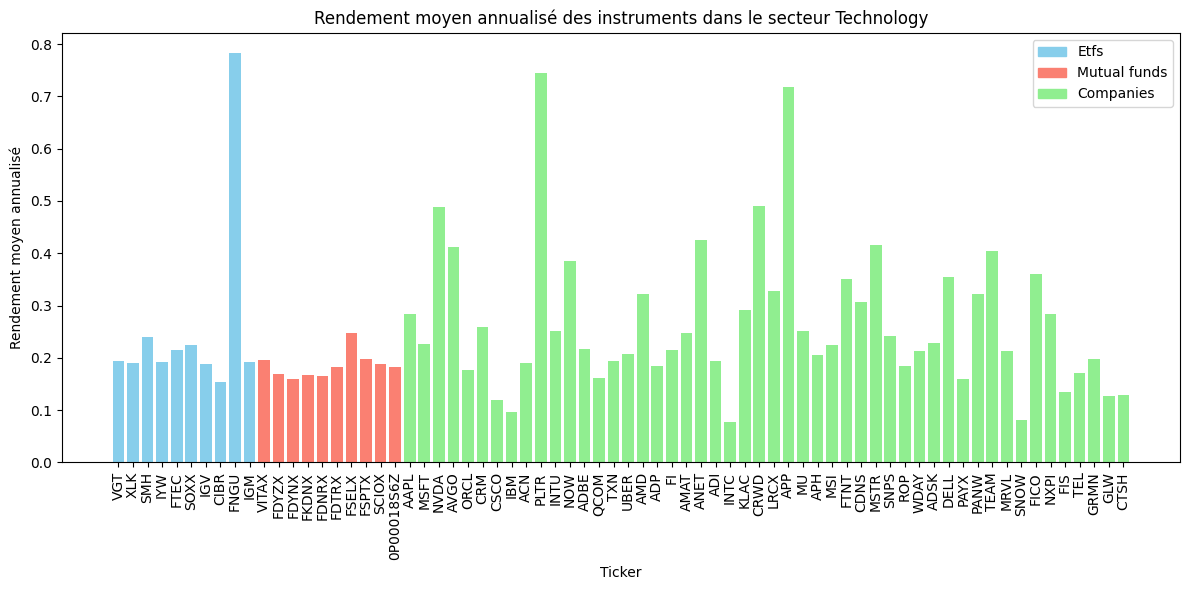

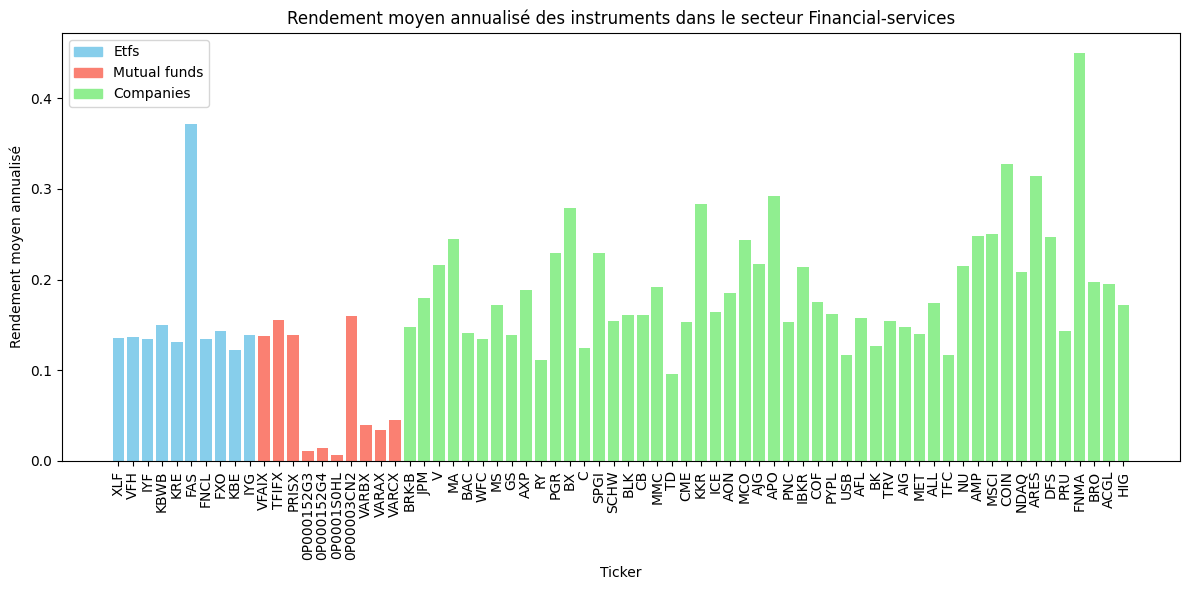

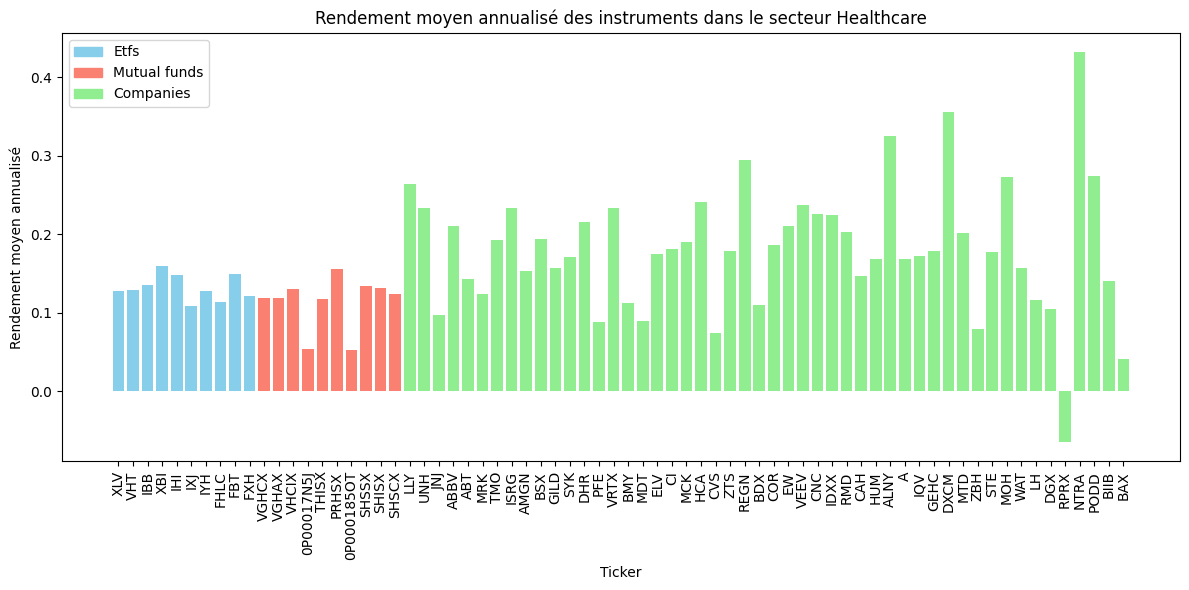

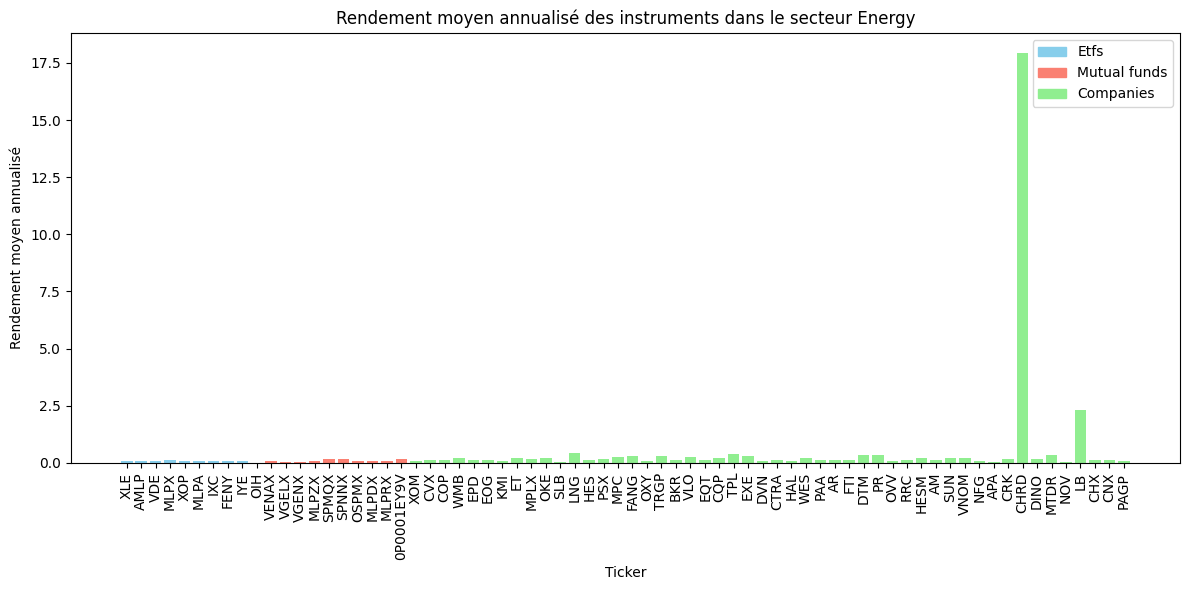

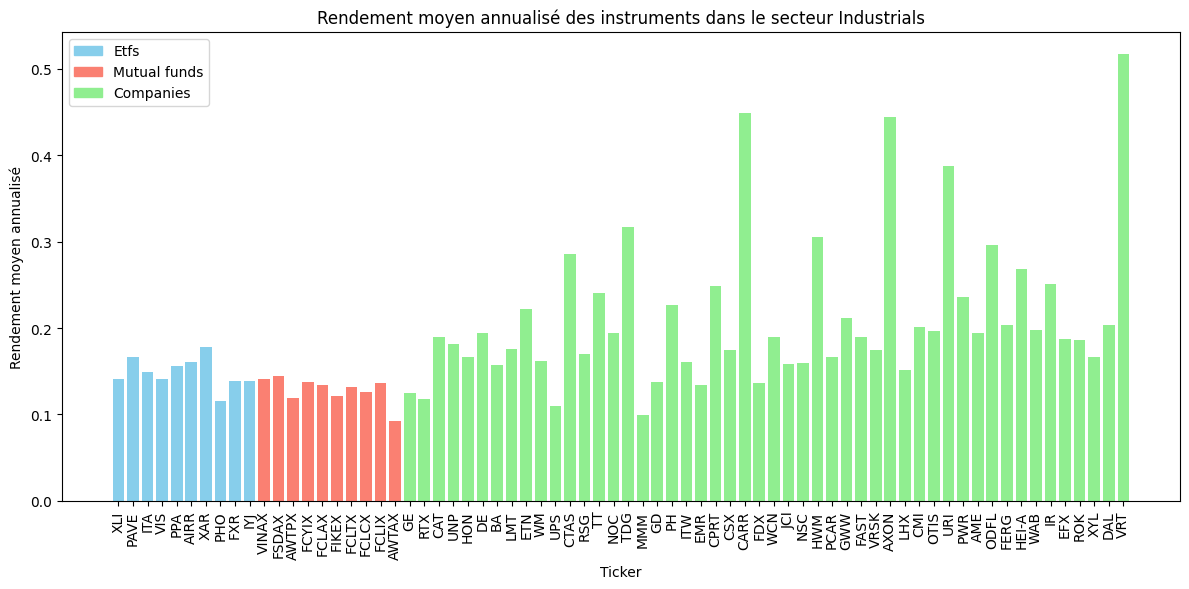

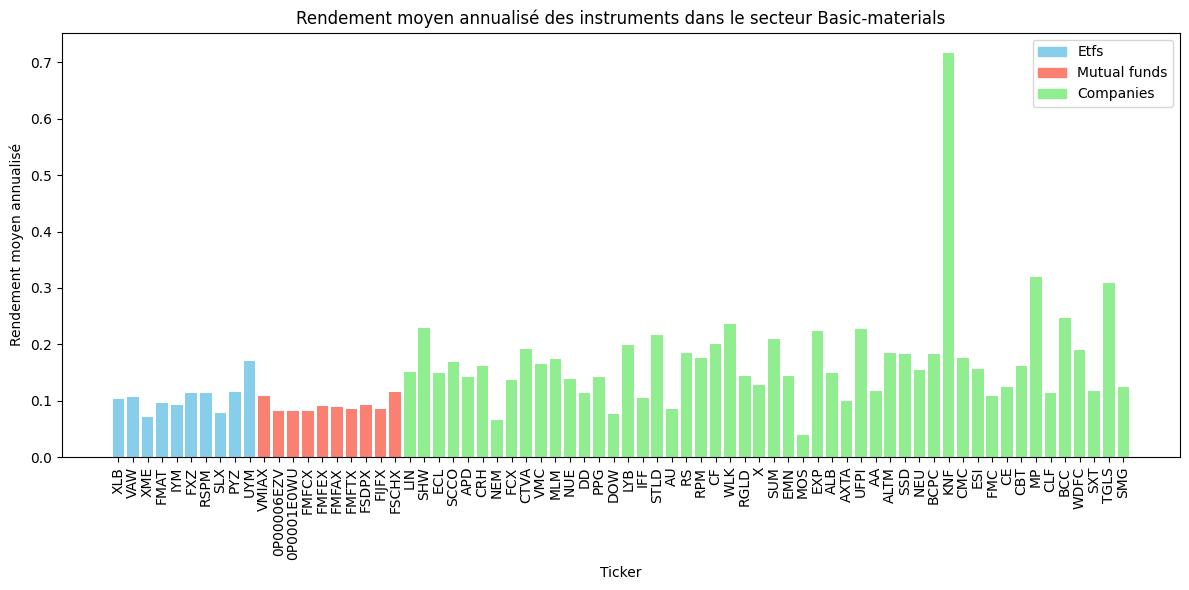

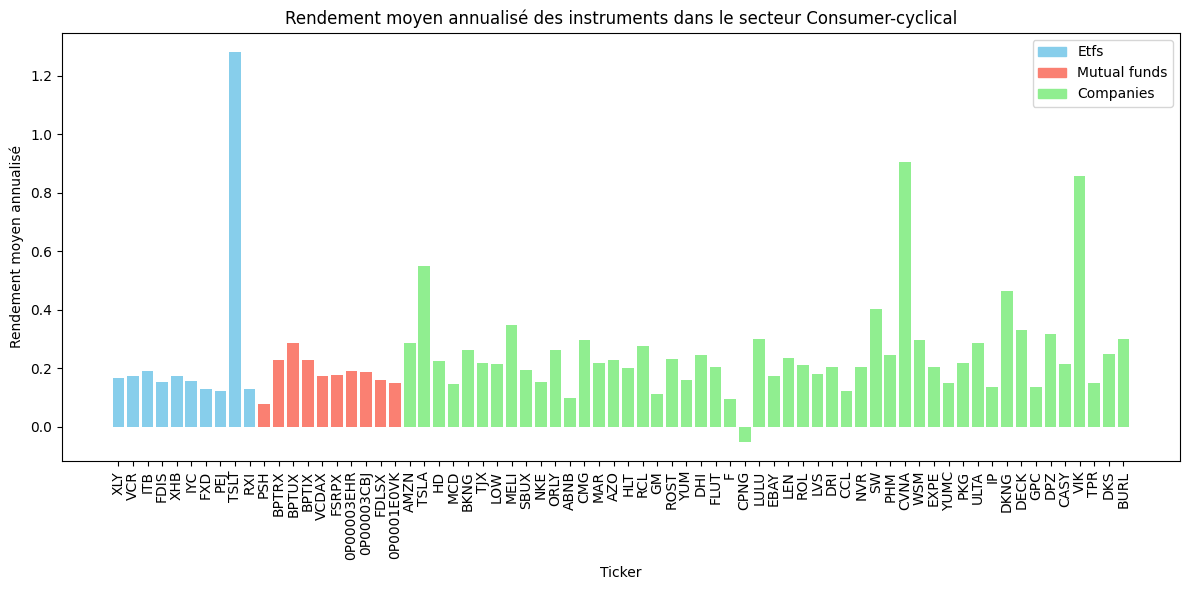

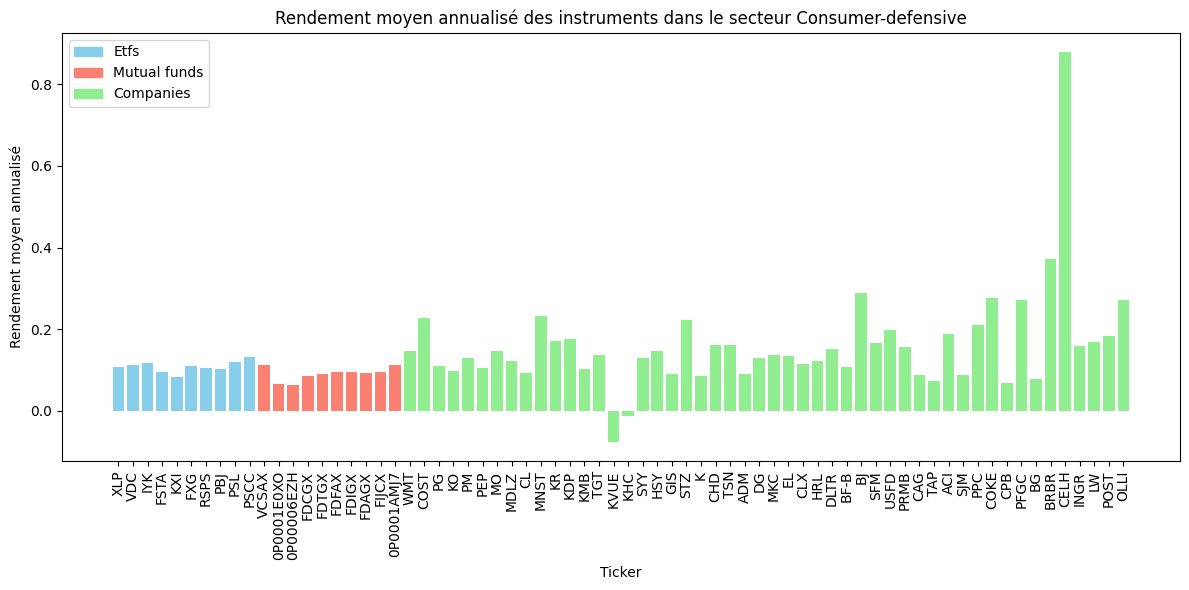

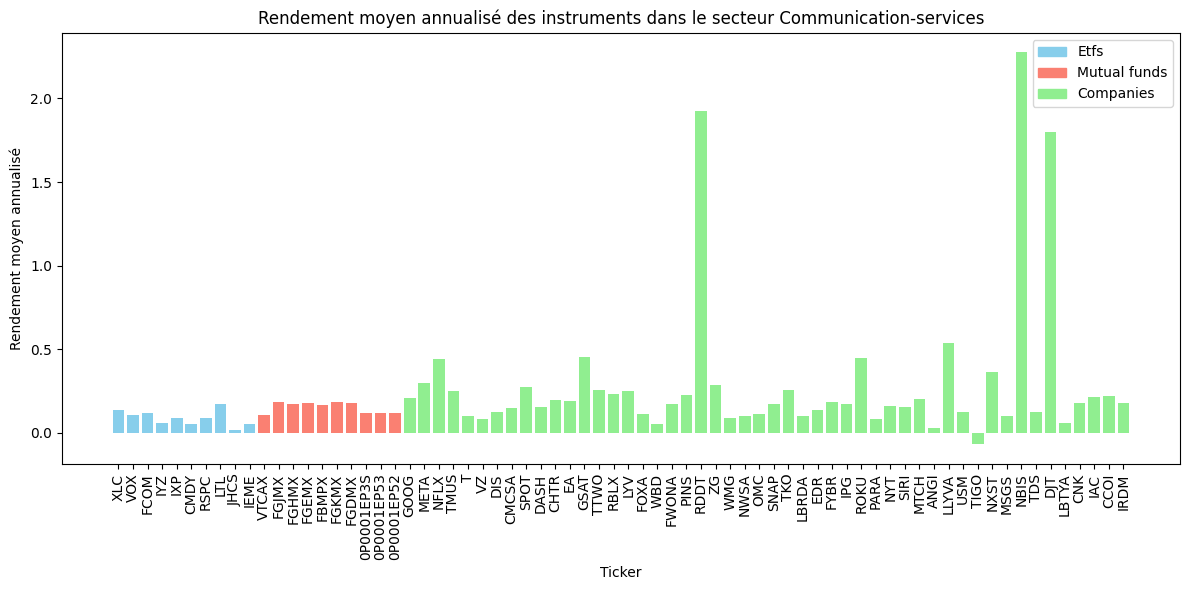

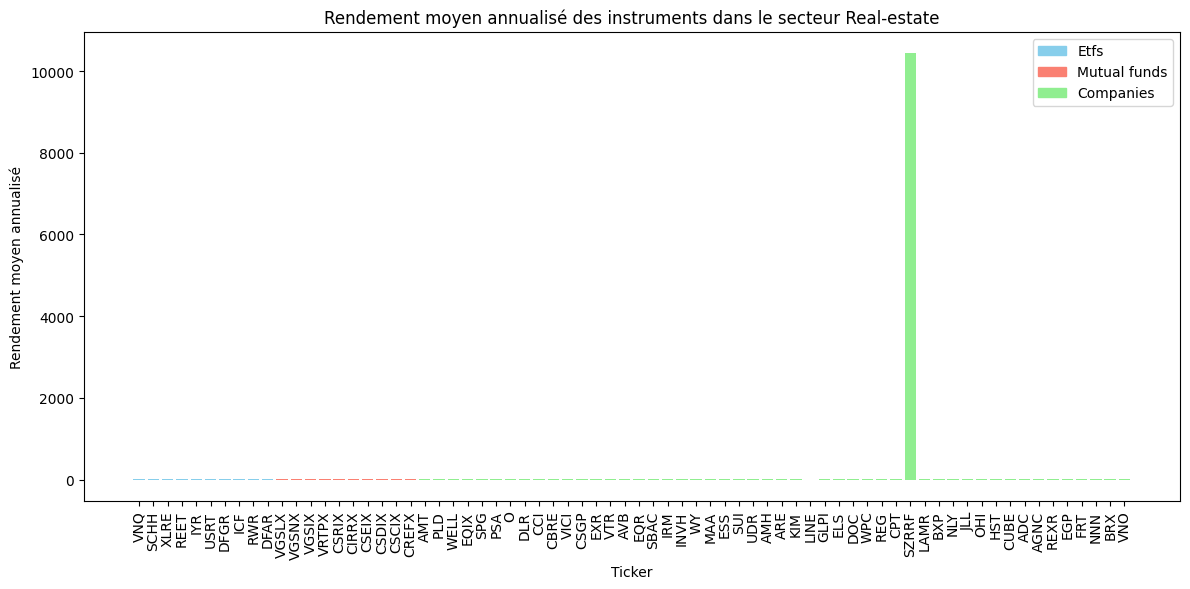

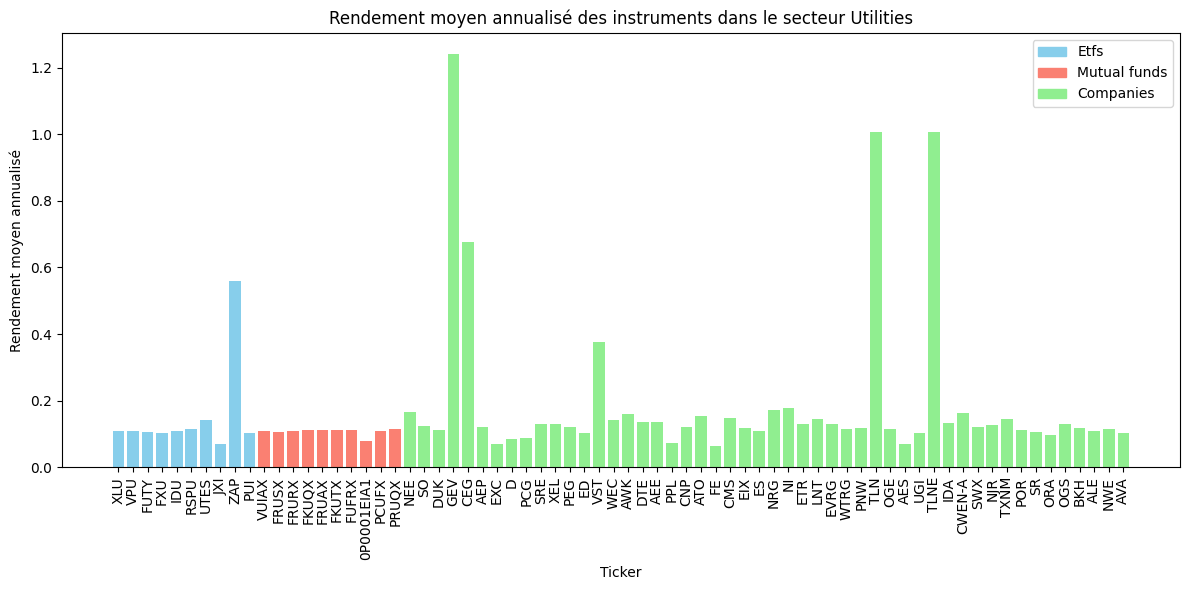

In [132]:

def get_annualized_return(ticker):
    data = yf.download(ticker, start=start_date, end=end_date, interval='1d',progress=False)
    # On utilise la colonne "Close" (vous pouvez changer en "Adj Close" si besoin)
    avg_daily_return = data["Close"].dropna().pct_change().mean()
    annualized_return = avg_daily_return * 252
    # Si annualized_return est une Series (un seul élément), on extrait sa valeur scalaire
    return annualized_return.iloc[0] # TypeError: only length-1 arrays can be converted to Python scalars



#ON STOCKE LES RENDS MOYENS de chaque truc et met dans dico : sector_ticker_returns[sector][inst_type]
# Calcul et stockage du rendement moyen annualisé pour chaque ticker, par secteur et par type d'instrument
sector_ticker_returns = {}

for sector, instruments in sector_instruments.items():
    sector_ticker_returns[sector] = {}
    for inst_type in instrument_types:
        tickers = instruments.get(inst_type, [])
        returns_dict = {}
        for ticker in tickers:
            ret = get_annualized_return(ticker)
            returns_dict[ticker] = ret
        sector_ticker_returns[sector][inst_type] = returns_dict

    
# Création d'un graphique combiné pour chaque secteur avec les 3 types d'instruments

colors = { "etfs": "skyblue", "mutual_funds": "salmon", "companies": "lightgreen" }

for sector, inst_returns in sector_ticker_returns.items():
    tickers_list = [] ; returns_list = [] ; types_list = []
    
    for inst_type in instrument_types:
        for ticker, ret in inst_returns.get(inst_type, {}).items():
            tickers_list.append(ticker) ; returns_list.append(ret) ; types_list.append(inst_type)
            
    x = np.arange(len(tickers_list))
    bar_colors = [colors[typ] for typ in types_list]
        
    plt.figure(figsize=(12, 6)) ; plt.bar(x, returns_list, color=bar_colors); plt.xticks(x, tickers_list, rotation=90)
    plt.xlabel("Ticker"); plt.ylabel("Rendement moyen annualisé"); plt.title(f"Rendement moyen annualisé des instruments dans le secteur {sector.capitalize()}")
        
    # Création d'une légende
    legend_patches = [mpatches.Patch(color=color, label=inst_type.replace('_', ' ').capitalize()) for inst_type, color in colors.items()] #import matplotlib.patches as mpatches
    plt.legend(handles=legend_patches) ; plt.tight_layout() ; plt.show()


## 3. Optimisation de Portefeuille Intrasectorielle <a class="anchor" id="section_3"></a>

L’objectif de cette étape est d’optimiser la composition d’un portefeuille **à l’intérieur de chaque secteur**, en sélectionnant les instruments (ETFs, fonds mutuels, entreprises) qui maximisent l’efficacité du couple rendement/risque.

### Méthodologie générale :

1. **Préparation des données :**  
   - Les instruments de chaque secteur sont consolidés et les rendements journaliers sont calculés pour chaque type d’actif.  
   - Les données anormales ou absentes sont filtrées pour ne conserver que les séries utilisables.

2. **Stratégies d’optimisation étudiées :**  
   - **Minimisation de la variance** : réduction maximale de la volatilité du portefeuille.  
   - **Maximisation du ratio de Sharpe** : optimisation du rendement ajusté au risque.  
   - **Maximisation du ratio de diversification** : répartition équilibrée entre actifs faiblement corrélés.

3. **Backtest avec rééquilibrage trimestriel :**  
   - Une fenêtre mobile de 3 ans sert à estimer les paramètres de chaque optimisation.  
   - Tous les 3 mois, les pondérations optimales sont recalculées et appliquées à une période de test.  
   - Cela permet de simuler un portefeuille dynamique dans le temps (approche walk-forward).

4. **Suivi des pondérations et performances :**  
   - À chaque date de rééquilibrage, les pondérations optimales sont sauvegardées par stratégie.  
   - Les performances cumulées sont enregistrées pour chaque secteur et chaque méthode.  
   - Trois graphiques sont générés pour chaque secteur :  
     - Performance naïve sans optimisation (ETF, fonds, entreprises)  
     - Rendement ex-ante annualisé à chaque rééquilibrage  
     - Performance cumulée du portefeuille optimisé selon les stratégies retenues

Cette approche permet d’évaluer la robustesse et la pertinence de chaque méthode d’optimisation **à l’échelle sectorielle**, en tenant compte de l’évolution des marchés dans le temps.



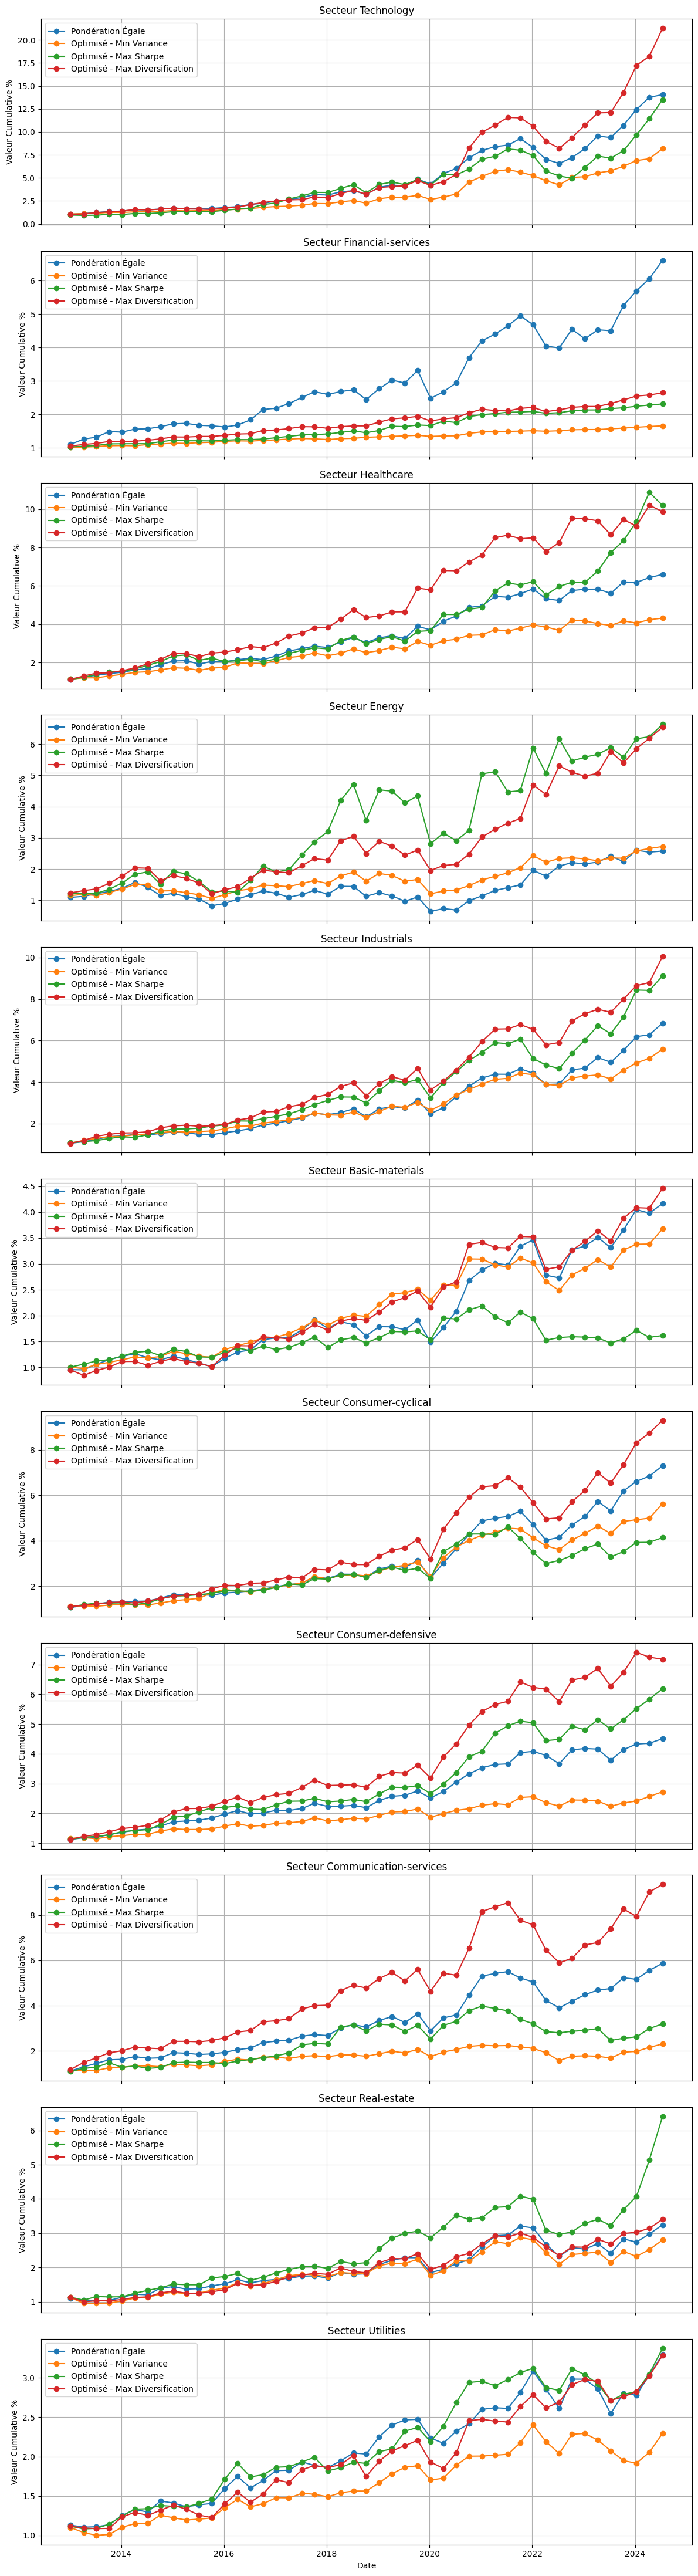

In [135]:

# --- 2. Paramètres généraux d'analyse ---
rebalance_period = 63   # environ 3 mois (jours de bourse)
window_length = 756     # environ 3 ans (252 jours * 3)

# --- 3. Fonctions de calcul et d'optimisation ---
def portfolio_metrics(weights, mean_returns, cov_matrix):
    """ Calcule rendement et volatilité d'un portefeuille. """
    port_return = np.sum(mean_returns * weights)
    port_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    return port_return, port_volatility

def objective_variance(weights, mean_returns, cov_matrix):
    """ Objectif : Minimiser la volatilité. """
    return portfolio_metrics(weights, mean_returns, cov_matrix)[1]

def objective_sharpe(weights, mean_returns, cov_matrix):
    """ Objectif : Maximiser le ratio de Sharpe (on minimise son opposé). """
    ret, vol = portfolio_metrics(weights, mean_returns, cov_matrix)
    return -ret / vol

def diversification_ratio(weights, mean_returns, cov_matrix):
    """ Calcule le ratio de diversification. """
    indiv_vols = np.sqrt(np.diag(cov_matrix))
    weighted_vol = np.sum(weights * indiv_vols)
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return weighted_vol / port_vol

def objective_diversification(weights, mean_returns, cov_matrix):
    """ Objectif : Maximiser le ratio de diversification. """
    return -diversification_ratio(weights, mean_returns, cov_matrix)

# --- 4. Backtest Walk‑Forward pour chaque secteur ---
results = {}  # Dictionnaire pour stocker les résultats par secteur

for sector in sectors:
    # Constitution de la liste des tickers pour le secteur courant
    tickers_sector = (sector_instruments[sector]["companies"] +
                      sector_instruments[sector]["etfs"] +
                      sector_instruments[sector]["mutual_funds"])
    
    # Télécharger les données de prix pour le secteur et éliminer les colonnes avec données manquantes
    prices = yf.download(tickers_sector, start=start_date, end=end_date, interval='1d', progress=False)['Close'].dropna(axis=1)
    # Mise à jour de la liste des tickers disponibles pour le secteur
    tickers_available = prices.columns.tolist()
    if len(tickers_available) == 0:
        print(f"Aucune donnée pour le secteur {sector}.")
        continue
    
    # Calcul des rendements journaliers et de la matrice de covariance
    returns = prices.pct_change().iloc[1:]
    cov_matrix = returns.cov()
    
    n_assets = len(tickers_available)
    # Poids benchmark égal
    w0 = np.ones(n_assets) / n_assets
    
    # Initialisation des valeurs cumulées (on part de 1)
    value_eq      = 1.0
    value_min_var = 1.0
    value_max_sharpe = 1.0
    value_max_div    = 1.0
    # Listes pour stocker l'évolution et les dates de rééquilibrage
    dates_walk = []
    values_eq = []
    values_min_var = []
    values_max_sharpe = []
    values_max_div = []
    
    n = len(returns)
    # Boucle walk‑forward
    for i in range(window_length, n - rebalance_period, rebalance_period):
        # Fenêtre historique pour l'optimisation
        train_data = returns.iloc[i - window_length : i]
        # Période de test (où appliquer les poids optimisés)
        test_data = returns.iloc[i : i + rebalance_period]
        
        train_mean = train_data.mean()
        train_cov = train_data.cov()
        
        bounds = tuple((0, 1) for _ in range(n_assets))
        constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        
        # Optimisation pour minimiser la variance
        res_min = minimize(objective_variance, w0, args=(train_mean, train_cov),
                           method='SLSQP', bounds=bounds, constraints=constraints)
        w_min = res_min.x if res_min.success else w0
        
        # Optimisation pour maximiser le ratio de Sharpe
        res_sharpe = minimize(objective_sharpe, w0, args=(train_mean, train_cov),
                              method='SLSQP', bounds=bounds, constraints=constraints)
        w_sharpe = res_sharpe.x if res_sharpe.success else w0
        
        # Optimisation pour maximiser le ratio de diversification
        res_div = minimize(objective_diversification, w0, args=(train_mean, train_cov),
                           method='SLSQP', bounds=bounds, constraints=constraints)
        w_div = res_div.x if res_div.success else w0
        
        # Rendements journaliers sur la période de test pour chaque stratégie
        ret_eq = test_data.dot(w0)               # Benchmark égal
        ret_min = test_data.dot(w_min)
        ret_sharpe = test_data.dot(w_sharpe)
        ret_div = test_data.dot(w_div)
        
        # Mise à jour de la valeur cumulée
        value_eq *= (1 + ret_eq).cumprod().iloc[-1]
        value_min_var *= (1 + ret_min).cumprod().iloc[-1]
        value_max_sharpe *= (1 + ret_sharpe).cumprod().iloc[-1]
        value_max_div *= (1 + ret_div).cumprod().iloc[-1]
        
        dates_walk.append(returns.index[i])
        values_eq.append(value_eq)
        values_min_var.append(value_min_var)
        values_max_sharpe.append(value_max_sharpe)
        values_max_div.append(value_max_div)
    
    # Stockage des résultats pour le secteur courant
    results[sector] = {
        "dates": dates_walk,
        "equal": values_eq,
        "min_var": values_min_var,
        "max_sharpe": values_max_sharpe,
        "max_div": values_max_div
    }

# --- 5. Visualisation des résultats par secteur ---
n_sectors = len(results)
fig, axs = plt.subplots(n_sectors, 1, figsize=(12, 4 * n_sectors), sharex=True)
if n_sectors == 1:
    axs = [axs]
    
for ax, sector in zip(axs, results.keys()):
    data = results[sector]
    ax.plot(data["dates"], data["equal"], marker='o', linestyle='-', label="Pondération Égale")
    ax.plot(data["dates"], data["min_var"], marker='o', linestyle='-', label="Optimisé - Min Variance")
    ax.plot(data["dates"], data["max_sharpe"], marker='o', linestyle='-', label="Optimisé - Max Sharpe")
    ax.plot(data["dates"], data["max_div"], marker='o', linestyle='-', label="Optimisé - Max Diversification")
    ax.set_title(f"Secteur {sector.capitalize()}")
    ax.set_ylabel("Valeur Cumulative %")
    ax.legend()
    ax.grid(True)
    
plt.xlabel("Date")
plt.tight_layout()
plt.show()


## 4. Optimisation et Comparaison Intersectorielle <a class="anchor" id="section_4"></a>

Cette section vise à déterminer la **répartition optimale entre secteurs** et à **comparer plusieurs stratégies d’investissement globales** sur la période 2010–2024.

### Deux approches d’optimisation sont explorées :

- **Optimisation intersectorielle :**  
  Chaque secteur est représenté par un indicateur synthétique (ex. rendement moyen des ETFs), et on applique des fonctions classiques d’optimisation (variance minimale, ratio de Sharpe maximal, diversification maximale) pour allouer les pondérations entre secteurs.

- **Optimisation globale sur l’ensemble des actions :**  
  Tous les instruments sont considérés indépendamment, sans tenir compte de leur appartenance sectorielle. L’objectif est de construire un portefeuille optimal à partir de la totalité des actions disponibles.

### Benchmarks et comparaisons :

Les stratégies optimisées sont comparées à plusieurs portefeuilles de référence :

- L’indice **S&P500**  
- Un portefeuille **équi-pondéré entre secteurs**  
- Un portefeuille **intersectoriel optimisé**  
- Un portefeuille **global optimisé sur toutes les actions**

Cette approche permet de mettre en perspective les performances relatives des portefeuilles sectoriels et globaux selon différents critères de gestion du risque.



### Agrégation des performances sectorielles à partir des ETFs <a class="anchor" id="section_4_1"></a>

Pour chaque secteur, on estime un **rendement moyen représentatif** à partir des performances historiques des principaux ETFs sectoriels.  
Ces rendements agrégés serviront de base pour déterminer la répartition optimale entre secteurs lors de l’optimisation intersectorielle.  
Un graphique circulaire permet de visualiser la contribution moyenne de chaque secteur sur la période 2010–2024.


In [136]:

# -------------------------------
# 1. Agrégation des performances sectorielles (en utilisant les ETFs)
# -------------------------------
# Pour chaque secteur, on utilise les ETFs pour obtenir une série de rendement agrégé
sector_agg_returns = {}
for sector in sectors:
    tickers_etfs = sector_instruments[sector]["etfs"]
    prices = yf.download(tickers_etfs, start=start_date, end=end_date, interval="1d", progress=False)["Close"].dropna(axis=1)

    returns = prices.pct_change().dropna()
    # On agrège en prenant la moyenne journalière
    agg_return = returns.mean(axis=1)
    sector_agg_returns[sector] = agg_return

# On ne conserve que les secteurs pour lesquels nous avons des données
agg_returns_df = pd.DataFrame(sector_agg_returns).dropna()
sector_names = agg_returns_df.columns.tolist()
n_sectors = len(sector_names)



### Optimisation de la répartition globale entre secteurs <a class="anchor" id="section_4_2"></a>

Les rendements moyens journaliers sont d’abord estimés pour chaque secteur à partir des performances de leurs ETFs.  
À partir de ces rendements, on construit une matrice de covariance, puis on applique trois méthodes d’optimisation pour déterminer les poids sectoriels idéaux :

- **Minimisation de la variance** : réduire le risque global du portefeuille.  
- **Maximisation du ratio de Sharpe** : rechercher le meilleur compromis rendement/risque.  
- **Maximisation du ratio de diversification** : répartir les investissements de manière à limiter les corrélations internes.

Les pondérations optimales sont affichées pour chaque stratégie, accompagnées de deux types de visualisations :

- Un **graphique en secteurs** représentant la répartition entre les différents secteurs.  
- Un **graphique en secteurs secondaires** illustrant la répartition des poids entre les ETFs, en fonction des pondérations sectorielles.


Optimisation Intersectorielle – Répartition à chaque rééquilibrage:

T = 2013-01-07 00:00:00 - Rééquilibrage
  Min_Variance: {'technology': np.float64(0.0), 'financial-services': np.float64(0.0), 'healthcare': np.float64(0.0), 'energy': np.float64(0.0), 'industrials': np.float64(0.0), 'basic-materials': np.float64(0.0), 'consumer-cyclical': np.float64(0.0), 'consumer-defensive': np.float64(55.82), 'communication-services': np.float64(0.0), 'real-estate': np.float64(0.0), 'utilities': np.float64(44.18)}
  Max_Sharpe:   {'technology': np.float64(0.0), 'financial-services': np.float64(0.0), 'healthcare': np.float64(0.0), 'energy': np.float64(0.0), 'industrials': np.float64(0.0), 'basic-materials': np.float64(0.0), 'consumer-cyclical': np.float64(4.25), 'consumer-defensive': np.float64(95.75), 'communication-services': np.float64(0.0), 'real-estate': np.float64(0.0), 'utilities': np.float64(0.0)}
  Max_Diversification: {'technology': np.float64(17.66), 'financial-services': np.float64(0.0)

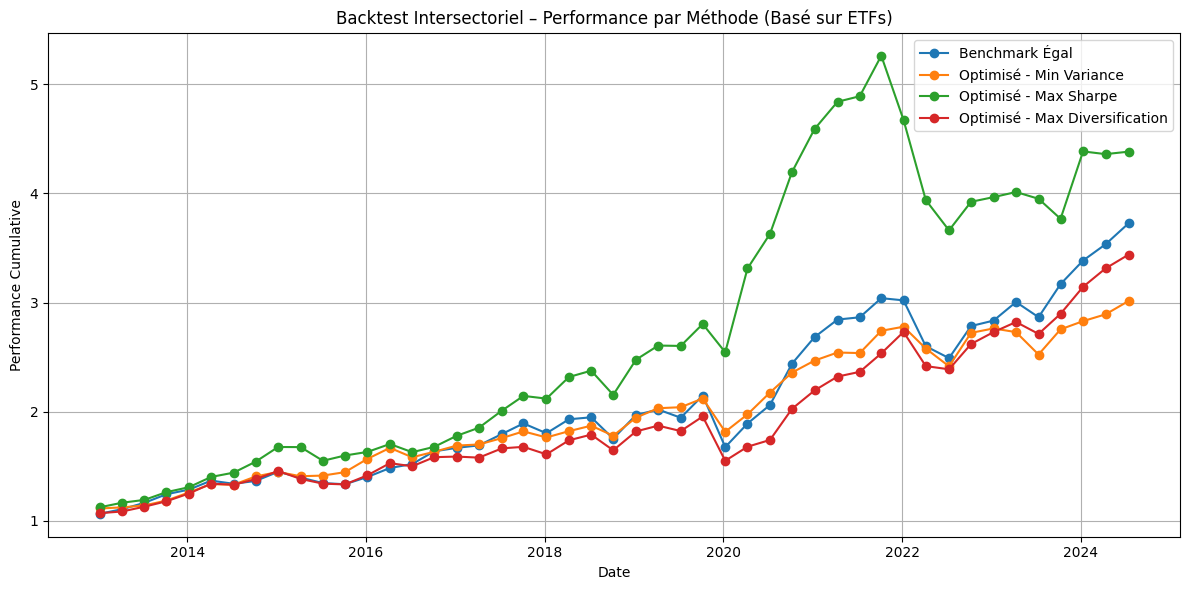

In [138]:

# -------------------------------
# 2. Backtest Walk‑Forward Intersectoriel
# -------------------------------
# Paramètres de rééquilibrage
rebalance_period = 63   # environ 3 mois
window_length = 756     # environ 3 ans d'historique

n = len(agg_returns_df)
w0_inter = np.ones(n_sectors) / n_sectors

# Initialisation des performances cumulées pour chaque méthode
perf_equal = 1.0 ; perf_min_var = 1.0 ; perf_sharpe  = 1.0 ; perf_div = 1.0

# Listes pour stocker les dates et les compositions (répartition entre secteurs)
dates_inter = [] ; comp_min_list = [] ; comp_sharpe_list = [] ; comp_div_list = []

perf_equal_list = [] ; perf_min_list = [] ; perf_sharpe_list = []; perf_div_list = []

for i in range(window_length, n - rebalance_period, rebalance_period):
    rebal_date = agg_returns_df.index[i]
    train_data = agg_returns_df.iloc[i - window_length : i]
    test_data = agg_returns_df.iloc[i : i + rebalance_period]
    
    train_mean = train_data.mean()
    train_cov = train_data.cov()
    
    bounds = tuple((0, 1) for _ in range(n_sectors))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # Pour le benchmark égal, on garde w0_inter
    w_equal = w0_inter
    
    # Optimisation pour minimiser la variance
    res_min = minimize(objective_variance, w0_inter, args=(train_mean, train_cov), method="SLSQP", bounds=bounds, constraints=constraints)
    weights_min = res_min.x if res_min.success else w0_inter
    
    # Optimisation pour maximiser le ratio de Sharpe
    res_sharpe = minimize(objective_sharpe, w0_inter, args=(train_mean, train_cov), method="SLSQP", bounds=bounds, constraints=constraints)
    weights_sharpe = res_sharpe.x if res_sharpe.success else w0_inter
    
    # Optimisation pour maximiser le ratio de diversification
    res_div = minimize(objective_diversification, w0_inter, args=(train_mean, train_cov), method="SLSQP", bounds=bounds, constraints=constraints)
    weights_div = res_div.x if res_div.success else w0_inter
    
    # Calcul des rendements journaliers sur la période de test pour chaque méthode
    ret_equal = test_data.dot(w_equal)
    ret_min = test_data.dot(weights_min)
    ret_sharpe = test_data.dot(weights_sharpe)
    ret_div = test_data.dot(weights_div)
    
    perf_equal *= (1 + ret_equal).cumprod().iloc[-1]
    perf_min_var *= (1 + ret_min).cumprod().iloc[-1]
    perf_sharpe  *= (1 + ret_sharpe).cumprod().iloc[-1]
    perf_div     *= (1 + ret_div).cumprod().iloc[-1]
    
    dates_inter.append(rebal_date)
    perf_equal_list.append(perf_equal)
    perf_min_list.append(perf_min_var)
    perf_sharpe_list.append(perf_sharpe)
    perf_div_list.append(perf_div)
    

    # Stocker la composition (les poids en pourcentage) pour chaque méthode
    comp_min_list.append(dict(zip(sector_names, (weights_min*100).round(2))))
    comp_sharpe_list.append(dict(zip(sector_names, (weights_sharpe*100).round(2))))
    comp_div_list.append(dict(zip(sector_names, (weights_div*100).round(2))))

# -------------------------------
# 3. Affichage de la répartition intersectorielle à chaque rééquilibrage
# -------------------------------
print("Optimisation Intersectorielle – Répartition à chaque rééquilibrage:")
for i, date in enumerate(dates_inter):
    print(f"\nT = {date} - Rééquilibrage")
    print(f"  Min_Variance: {comp_min_list[i]}")
    print(f"  Max_Sharpe:   {comp_sharpe_list[i]}")
    print(f"  Max_Diversification: {comp_div_list[i]}")


# -------------------------------
# 4. Visualisation de la performance cumulative globale
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(dates_inter, perf_equal_list, marker='o', linestyle='-', label="Benchmark Égal")
plt.plot(dates_inter, perf_min_list, marker='o', linestyle='-', label="Optimisé - Min Variance")
plt.plot(dates_inter, perf_sharpe_list, marker='o', linestyle='-', label="Optimisé - Max Sharpe")
plt.plot(dates_inter, perf_div_list, marker='o', linestyle='-', label="Optimisé - Max Diversification")
plt.xlabel("Date")
plt.ylabel("Performance Cumulative")
plt.title("Backtest Intersectoriel – Performance par Méthode (Basé sur ETFs)")
plt.legend() ; plt.grid(True) ; plt.tight_layout() ; plt.show()



4 Failed downloads:
['ZAP']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='guce.yahoo.com', port=443): Read timed out. (read timeout=30)"))
['FNGU']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='www.yahoo.com', port=443): Read timed out. (read timeout=30)"))
['IGV']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='fr.yahoo.com', port=443): Read timed out. (read timeout=30)"))
['IGM']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query1.finance.yahoo.com', port=443): Read timed out. (read timeout=30)"))

1 Failed download:
['ZAP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1704085200")')


Minimum Variance Portfolio Weights:
technology: 0.0000
financial-services: 0.0000
healthcare: 0.0076
energy: 0.0000
industrials: 0.0000
basic-materials: 0.0000
consumer-cyclical: 0.0000
consumer-defensive: 0.8976
communication-services: 0.0000
real-estate: 0.0000
utilities: 0.0947

Maximum Sharpe Ratio Portfolio Weights:
technology: 0.6042
financial-services: 0.0000
healthcare: 0.0149
energy: 0.0000
industrials: 0.0000
basic-materials: 0.0000
consumer-cyclical: 0.0000
consumer-defensive: 0.3809
communication-services: 0.0000
real-estate: 0.0000
utilities: 0.0000

Maximum Diversification Ratio Portfolio Weights:
technology: 0.0000
financial-services: 0.0000
healthcare: 0.0101
energy: 0.0000
industrials: 0.0000
basic-materials: 0.0000
consumer-cyclical: 0.0000
consumer-defensive: 0.8949
communication-services: 0.0000
real-estate: 0.0000
utilities: 0.0951


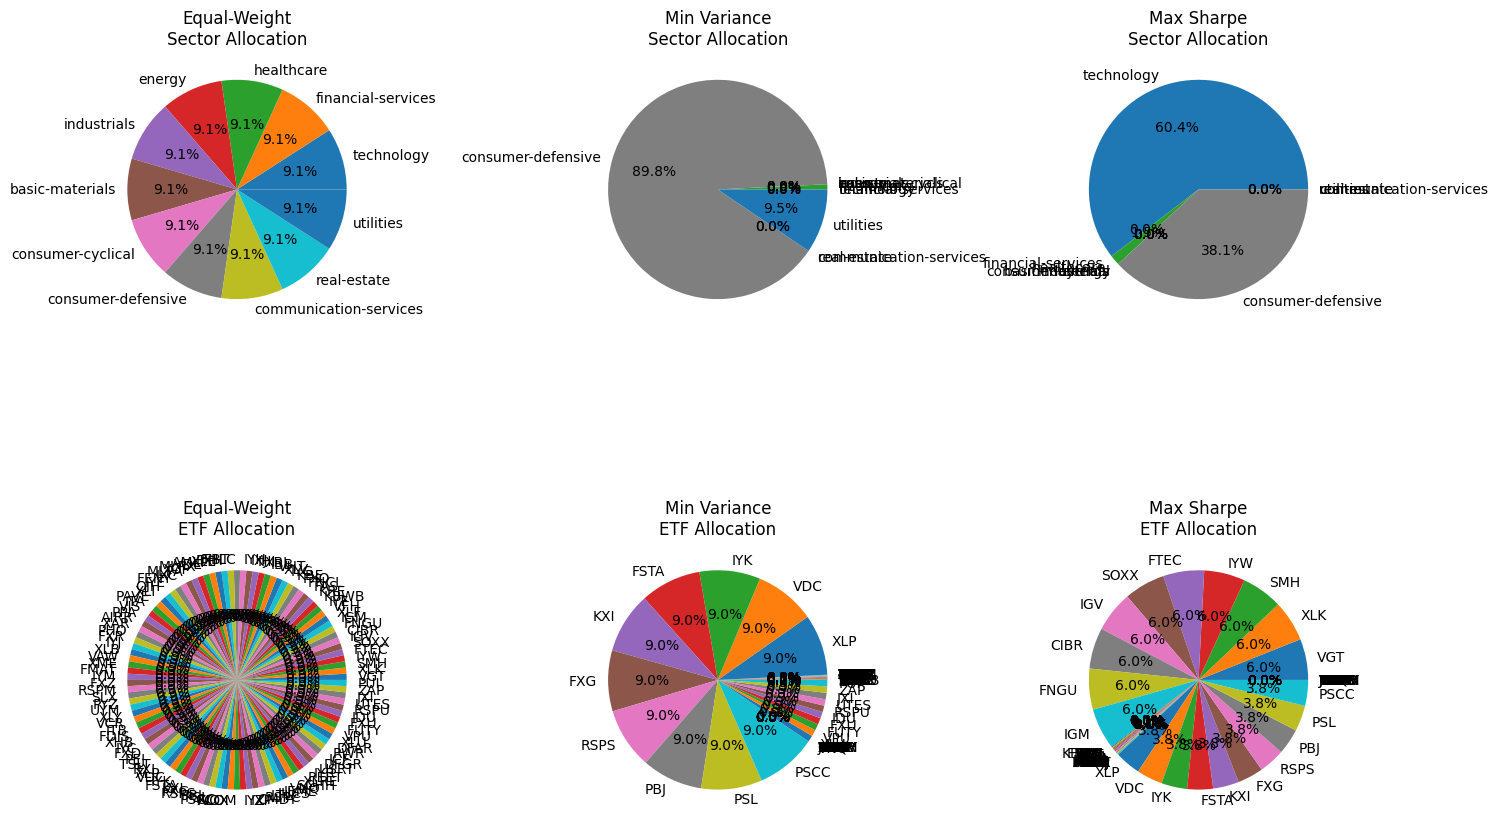

In [120]:
#Optimisation de la répartition globale entre secteurs :
#Appliquez les mêmes fonctions d’optimisation (minimisation de la variance, maximisation du ratio de Sharpe, et maximisation du ratio de diversification)
#pour déterminer la répartition optimale entre les secteurs.
from scipy.optimize import minimize


# Récupération des rendements quotidiens pour chaque ETF (pour covariance)
def get_sector_returns(sector_etfs):
    data = yf.download(sector_etfs, start=start_date, end=end_date, progress=False)["Close"].dropna(axis=1)
    returns = data.pct_change().iloc[1:]
    return returns

# Calcul des rendements quotidiens pour chaque secteur
sector_daily_returns = {}
for sector, instruments in sector_instruments.items():
    etfs = instruments["etfs"]
    sector_daily_returns[sector] = get_sector_returns(etfs)

# Conversion des rendements quotidiens en DataFrame
returns_df = pd.DataFrame({sector: sector_daily_returns[sector].mean(axis=1) for sector in sector_instruments})
returns_df = returns_df.dropna()  # Nettoyage des données


# Calcul de la matrice de covariance des rendements
cov_matrix = returns_df.cov() * 252  # Annualisation de la covariance

# Fonction pour calculer les métriques d'un portefeuille
def portfolio_metrics(weights, returns, cov_matrix):
    port_return = np.sum(returns.mean() * weights) * 252  # Rendement annualisé
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Volatilité annualisée
    sharpe_ratio = (port_return - RISK_FREE_RATE) / port_volatility  # Ratio de Sharpe
    return port_return, port_volatility, sharpe_ratio

# Optimisation du portefeuille : Minimisation de la variance
def min_variance_portfolio(cov_matrix):
    n_sectors = len(cov_matrix)
    initial_weights = np.ones(n_sectors) / n_sectors
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n_sectors))

    result = minimize(
        lambda w: portfolio_metrics(w, returns_df, cov_matrix)[1],  # Minimisation de la volatilité
        initial_weights,
        constraints=constraints,
        bounds=bounds,
        method='SLSQP'
    )
    return result

# Optimisation du portefeuille : Maximisation du ratio de Sharpe
def max_sharpe_portfolio(cov_matrix):
    n_sectors = len(cov_matrix)
    initial_weights = np.ones(n_sectors) / n_sectors
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n_sectors))

    result = minimize(
        lambda w: -portfolio_metrics(w, returns_df, cov_matrix)[2],  # Maximisation du ratio de Sharpe
        initial_weights,
        constraints=constraints,
        bounds=bounds,
        method='SLSQP'
    )
    return result

# Optimisation du portefeuille : Maximisation du ratio de diversification
def max_diversification_portfolio(cov_matrix):
    n_sectors = len(cov_matrix)
    initial_weights = np.ones(n_sectors) / n_sectors
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n_sectors))

    result = minimize(
        lambda w: -diversification_ratio(w, cov_matrix),  # Maximisation du ratio de diversification
        initial_weights,
        constraints=constraints,
        bounds=bounds,
        method='SLSQP'
    )
    return result

# Fonction pour calculer le ratio de diversification
def diversification_ratio(weights, cov_matrix):
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    diversifying_factor = np.sum(weights) / portfolio_volatility  # Simuler une mesure de diversification
    return diversifying_factor

# Résultats de l'optimisation
sector_min_var_result = min_variance_portfolio(cov_matrix)
sector_max_sharpe_result = max_sharpe_portfolio(cov_matrix)
sector_max_diversification_result = max_diversification_portfolio(cov_matrix)

# Affichage des résultats
print("Minimum Variance Portfolio Weights:")
for sector, weight in zip(sector_instruments.keys(), sector_min_var_result.x):
    print(f"{sector}: {weight:.4f}")

print("\nMaximum Sharpe Ratio Portfolio Weights:")
for sector, weight in zip(sector_instruments.keys(), sector_max_sharpe_result.x):
    print(f"{sector}: {weight:.4f}")

print("\nMaximum Diversification Ratio Portfolio Weights:")
for sector, weight in zip(sector_instruments.keys(), sector_max_diversification_result.x):
    print(f"{sector}: {weight:.4f}")


#Nombre de secteurs
n_sectors = len(sector_instruments)

# Création des différentes stratégies de portefeuille
portfolios = {
    'Equal-Weight': np.ones(n_sectors)/n_sectors,
    'Min Variance': sector_min_var_result.x,
    'Max Sharpe': sector_max_sharpe_result.x
}

# Fonction pour obtenir les poids des ETFs en fonction des poids sectoriels
def sector_to_etf_weights(sector_weights, sector_instruments):
    etf_weights = {}
    for sector, weight in zip(sector_instruments.keys(), sector_weights):
        etfs = sector_instruments[sector]['etfs']
        etf_weights[sector] = {etf: weight / len(etfs) for etf in etfs}
    return etf_weights

# Créer la visualisation
plt.figure(figsize=(15, 10))

# Pour chaque stratégie de portefeuille
for idx, (name, weights) in enumerate(portfolios.items(), 1):
    # Affichage de la répartition sectorielle
    plt.subplot(2, 3, idx)
    plt.pie(weights, labels=sector_instruments.keys(), autopct='%1.1f%%')
    plt.title(f'{name}\nSector Allocation')

    # Affichage de la répartition des ETFs pour chaque secteur
    plt.subplot(2, 3, idx+3)
    etf_weights = sector_to_etf_weights(weights, sector_instruments)

    # Création d'une liste à plat de tous les ETFs et de leurs poids
    all_etfs = []
    all_weights = []
    for sector, etfs in etf_weights.items():
        all_etfs.extend(list(etfs.keys()))
        all_weights.extend(list(etfs.values()))

    plt.pie(all_weights, labels=all_etfs, autopct='%1.1f%%')
    plt.title(f'{name}\nETF Allocation')

plt.tight_layout()
plt.show()

### Optimisation sur l’ensemble des actions (hors structure sectorielle) <a class="anchor" id="section_4_3"></a>

Cette approche vise à optimiser un portefeuille construit uniquement à partir de l’ensemble des **entreprises cotées**, sans tenir compte de leur appartenance sectorielle.

Les étapes sont les suivantes :  
- **Collecte des données :** tous les tickers d’entreprises sont extraits, nettoyés et filtrés pour ne conserver que les séries exploitables.  
- **Calcul des rendements quotidiens** et de la **matrice de covariance annualisée**.  
- Application des trois stratégies classiques :  
  - **Minimisation de la variance** : réduction maximale du risque.  
  - **Maximisation du ratio de Sharpe** : meilleur compromis rendement/risque.  
  - **Maximisation du ratio de diversification** : pondération équilibrée sur des actifs faiblement corrélés.  
- Les pondérations optimales sont ensuite affichées pour les 10 actions les plus représentées dans chaque stratégie.  
- Enfin, des **graphes circulaires** permettent de visualiser la composition finale des portefeuilles optimisés.

Cette méthode permet de comparer l’efficacité d’un portefeuille construit de manière totalement libre, sans contrainte sectorielle.



Nombre total d'actions sélectionnées (initialement) : 250


[*********************100%***********************]  250 of 250 completed

1 Failed download:
['LB']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1704085200")')


Les tickers suivants n'ont pas de données et seront ignorés : ['LB']
Nombre d'actions après filtrage : 249

--- Optimisation sur les actions indépendamment ---

Portefeuille Minimum Variance:
GEHC: 0.3000
DTM: 0.2514
RPRX: 0.1314
OTIS: 0.0974
JNJ: 0.0778
FERG: 0.0170
EXE: 0.0169
ABBV: 0.0165
DGX: 0.0155
MRK: 0.0136

Portefeuille Maximum Sharpe Ratio:
LLY: 0.1921
FERG: 0.1488
TPL: 0.0947
CARR: 0.0617
REGN: 0.0580
AVGO: 0.0545
ODFL: 0.0503
LNG: 0.0473
AXON: 0.0376
DXCM: 0.0371

Portefeuille Maximum Diversification Ratio:
GEHC: 0.3000
DTM: 0.2515
RPRX: 0.1324
OTIS: 0.0968
JNJ: 0.0770
FERG: 0.0172
ABBV: 0.0166
EXE: 0.0166
DGX: 0.0153
MRK: 0.0137


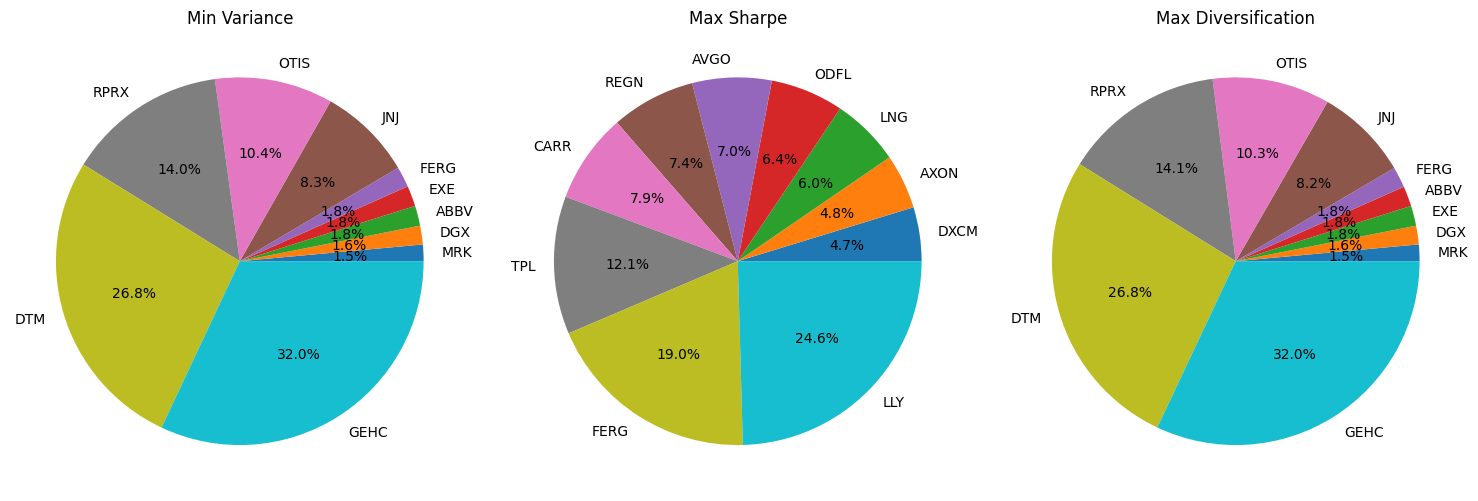

In [80]:

# 1. Récupération de tous les tickers "companies" issus de chaque secteur
all_companies = []
for sector, instruments in sector_instruments.items():
    all_companies.extend(instruments['companies'])

# Supprimer les doublons
all_companies = list(set(all_companies))
print(f"Nombre total d'actions sélectionnées (initialement) : {len(all_companies)}")

# 2. Téléchargement des données historiques pour toutes ces actions
data_all = yf.download(all_companies, start=start_date, end=end_date)["Close"]

# Supprimer les colonnes pour lesquelles aucune donnée n'a été téléchargée
data_all = data_all.dropna(axis=1, how='all')

# Afficher un avertissement si certains tickers n'ont pas de données
downloaded_tickers = set(data_all.columns)
missing_tickers = [ticker for ticker in all_companies if ticker not in downloaded_tickers]
if missing_tickers:
    print(f"Les tickers suivants n'ont pas de données et seront ignorés : {missing_tickers}")

# IMPORTANT : mettre à jour la liste all_companies en fonction des colonnes réelles du DataFrame
all_companies = list(data_all.columns)
print(f"Nombre d'actions après filtrage : {len(all_companies)}")

# Prétraitement : remplir les valeurs manquantes (forward et backward fill) et garder que les dates complètes
data_all = data_all.ffill().bfill().dropna()

# Calcul des rendements quotidiens
returns_all = data_all.pct_change().dropna()

# 3. Calcul de la matrice de covariance annualisée (en supposant TRADING_DAYS=252)
cov_matrix_all = returns_all.cov() * TRADING_DAYS

# 4. Définition des fonctions pour calculer les métriques du portefeuille

def portfolio_metrics_individual(weights, returns, cov_matrix):
    port_return = np.sum(returns.mean() * weights) * TRADING_DAYS
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (port_return - RISK_FREE_RATE) / port_volatility
    return port_return, port_volatility, sharpe_ratio

def diversification_ratio_individual(weights, cov_matrix):
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return np.sum(weights) / port_volatility

# 5. Définition des contraintes et bornes
n_assets = len(all_companies)
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, MAX_ALLOCATION) for _ in range(n_assets))

# 6. Définition des fonctions d’optimisation sur l’ensemble des actions

def min_variance_portfolio_ind(returns, cov_matrix):
    initial_weights = np.ones(n_assets) / n_assets
    result = minimize(
        lambda w: portfolio_metrics_individual(w, returns, cov_matrix)[1],
        initial_weights,
        constraints=constraints,
        bounds=bounds,
        method='SLSQP'
    )
    return result

def max_sharpe_portfolio_ind(returns, cov_matrix):
    initial_weights = np.ones(n_assets) / n_assets
    result = minimize(
        lambda w: -portfolio_metrics_individual(w, returns, cov_matrix)[2],
        initial_weights,
        constraints=constraints,
        bounds=bounds,
        method='SLSQP'
    )
    return result

def max_diversification_portfolio_ind(returns, cov_matrix):
    initial_weights = np.ones(n_assets) / n_assets
    result = minimize(
        lambda w: -diversification_ratio_individual(w, cov_matrix),
        initial_weights,
        constraints=constraints,
        bounds=bounds,
        method='SLSQP'
    )
    return result

# 7. Application des optimisations sur l’ensemble des actions
min_var_result_ind = min_variance_portfolio_ind(returns_all, cov_matrix_all)
max_sharpe_result_ind = max_sharpe_portfolio_ind(returns_all, cov_matrix_all)
max_div_result_ind = max_diversification_portfolio_ind(returns_all, cov_matrix_all)

# 8. Affichage des résultats
print("\n--- Optimisation sur les actions indépendamment ---")
print("\nPortefeuille Minimum Variance:")
sorted_min_var = sorted(zip(all_companies, min_var_result_ind.x), key=lambda x: -x[1])
for company, weight in sorted_min_var[:10]:
    print(f"{company}: {weight:.4f}")

print("\nPortefeuille Maximum Sharpe Ratio:")
sorted_max_sharpe = sorted(zip(all_companies, max_sharpe_result_ind.x), key=lambda x: -x[1])
for company, weight in sorted_max_sharpe[:10]:
    print(f"{company}: {weight:.4f}")

print("\nPortefeuille Maximum Diversification Ratio:")
sorted_max_div = sorted(zip(all_companies, max_div_result_ind.x), key=lambda x: -x[1])
for company, weight in sorted_max_div[:10]:
    print(f"{company}: {weight:.4f}")

# 9. Visualisation
plt.figure(figsize=(15, 5))
strategies = {
    'Min Variance': min_var_result_ind.x,
    'Max Sharpe': max_sharpe_result_ind.x,
    'Max Diversification': max_div_result_ind.x
}
for i, (name, weights) in enumerate(strategies.items(), 1):
    plt.subplot(1, 3, i)
    sorted_idx = np.argsort(weights)[-10:]
    top_weights = weights[sorted_idx]
    top_companies = np.array(all_companies)[sorted_idx]
    plt.pie(top_weights, labels=top_companies, autopct='%1.1f%%')
    plt.title(name)
plt.tight_layout()
plt.show()

### Comparaison des performances cumulées : portefeuilles optimisés vs S&P500 <a class="anchor" id="section_4_4"></a>

Cette dernière étape permet de **mesurer et comparer** les performances des portefeuilles construits précédemment, en utilisant les **métriques standardisées** suivantes :  
- **Rendement annualisé**  
- **Volatilité annualisée**  
- **Ratio de Sharpe**

Les portefeuilles comparés incluent :  
- Le **S&P500**, en tant que benchmark de marché.  
- Un portefeuille **équi-pondéré entre les secteurs**.  
- Les portefeuilles **sectoriels optimisés** (variance minimale, Sharpe maximal, diversification maximale).  
- Les portefeuilles **globaux optimisés** sur les actions individuellement.

Une **visualisation synthétique** (graphe des rendements cumulés) permet d’apprécier l’évolution de la valeur de chaque portefeuille sur la période 2010–2024.



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TSLT']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2023-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1672549200")')

1 Failed download:
['ZAP']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2023-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1672549200")')

376 Failed downloads:
['VIK', 'LLYVA', 'SW', 'TLNE', '0P0001S0HL', 'TSLT', 'PSH', 'KNF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2023-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1672549200")')
['IBB', 'ZBH', 'MDLZ', 'WTRG', 'AON', 'VGSIX', 'AU', 'TTWO', 'ZG', 'MSCI', 'HLT', 'ADBE', 'EMN', 'CTAS', 'DHR', 'FXH', 'FANG', 'CNX', 'GPC', 'CVX', 'WES', 'IRDM', 'META', 'TAP', 'FSRPX', 'FXG', 'IP', 'ROK', 'CHX', 'RBLX', 'BK', 'FERG', 'F

------ Performance Annualisée ------
S&P500:
  Rendement: 5.64%, Volatilité: 25.45%, Sharpe: 0.22

Portefeuilles sectoriels :
  Équi-pondéré par secteur:
    Rendement: 8.34%, Volatilité: 26.86%, Sharpe: 0.31
  Optimisé - Min Variance:
    Rendement: 6.48%, Volatilité: 20.89%, Sharpe: 0.31
  Optimisé - Max Sharpe:
    Rendement: 14.40%, Volatilité: 28.91%, Sharpe: 0.50
  Optimisé - Max Diversification:
    Rendement: 12.22%, Volatilité: 27.65%, Sharpe: 0.44

Portefeuilles sur actions :
  Optimisé - Min Variance:
    Rendement: 5.78%, Volatilité: 5.67%, Sharpe: 1.02
  Optimisé - Max Sharpe:
    Rendement: 25.83%, Volatilité: 11.15%, Sharpe: 2.32
  Optimisé - Max Diversification:
    Rendement: 21.97%, Volatilité: 17.74%, Sharpe: 1.24


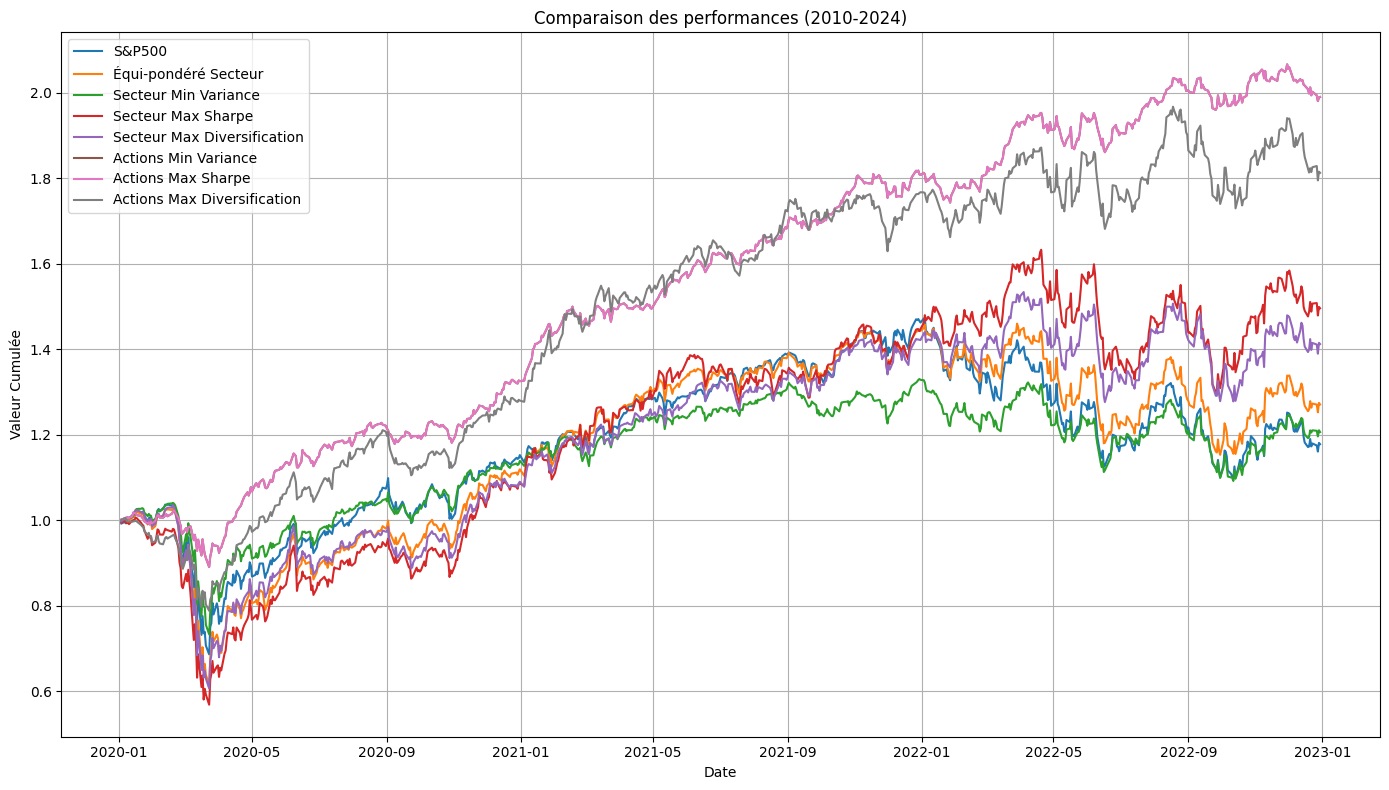

In [ ]:

# -------------------------------
# 1. Paramètres et constantes
# -------------------------------
TRADING_DAYS = 252
RISK_FREE_RATE = 0.02/252
MAX_ALLOCATION = 0.3  # allocation maximale par actif/secteur

# -------------------------------
# 2. Récupération des données S&P500
# -------------------------------
sp500_data = yf.download("^GSPC", start=start_date, end=end_date)["Close"]
sp500_returns = sp500_data.pct_change().iloc[1:]
sp500_cum = (1 + sp500_returns).cumprod()


# -------------------------------
# 3. Agrégation des performances sectorielles (à partir des ETFs)
# -------------------------------
# Pour représenter chaque secteur, on utilise le rendement moyen des ETFs.
sector_agg_returns = {}
for sector in sectors:
    tickers_etfs = sector_instruments[sector]["etfs"]
 
    prices = yf.download(tickers_etfs, start=start_date, end=end_date, interval="1d", progress=False)["Close"].dropna(axis=1)
    returns_sec = prices.pct_change().dropna()
    # Agrégation : moyenne journalière
    agg_return = returns_sec.mean(axis=1)
    sector_agg_returns[sector] = agg_return

# DataFrame des rendements agrégés par secteur
returns_df = pd.DataFrame(sector_agg_returns).dropna()
# Pour le benchmark sectoriel, on utilisera uniquement les secteurs pour lesquels nous avons des données.
sectors_available = returns_df.columns.tolist()

# Portefeuille équi-pondéré par secteur
n_sectors = len(sectors_available)
equal_weights_sector = np.ones(n_sectors) / n_sectors
eq_sector_daily = returns_df.dot(equal_weights_sector)
eq_sector_cum = (1 + eq_sector_daily).cumprod()

# -------------------------------
# 4. Optimisation intersectorielle sur les agrégats
# -------------------------------
# Calcul des statistiques (rendus quotidiens)
mean_returns_sector = returns_df.mean()  # rendement moyen quotidien
cov_sector = returns_df.cov()

# Fonctions d'optimisation (déjà définies)
def portfolio_metrics(weights, mean_returns, cov_matrix):
    port_return = np.sum(mean_returns * weights)
    port_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    return port_return, port_volatility

def objective_variance(weights, mean_returns, cov_matrix):
    return portfolio_metrics(weights, mean_returns, cov_matrix)[1]

def objective_sharpe(weights, mean_returns, cov_matrix):
    ret, vol = portfolio_metrics(weights, mean_returns, cov_matrix)
    return -ret / vol

def diversification_ratio(weights, mean_returns, cov_matrix):
    indiv_vols = np.sqrt(np.diag(cov_matrix))
    weighted_vol = np.sum(weights * indiv_vols)
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return weighted_vol / port_vol

def objective_diversification(weights, mean_returns, cov_matrix):
    return -diversification_ratio(weights, mean_returns, cov_matrix)

# Optimisation
w0_sector = np.ones(n_sectors) / n_sectors
bounds_sector = tuple((0, MAX_ALLOCATION) for _ in range(n_sectors))
constraints_sector = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

sector_min_var_result = minimize(objective_variance, w0_sector, args=(mean_returns_sector, cov_sector),
                                   method="SLSQP", bounds=bounds_sector, constraints=constraints_sector)
sector_max_sharpe_result = minimize(objective_sharpe, w0_sector, args=(mean_returns_sector, cov_sector),
                                    method="SLSQP", bounds=bounds_sector, constraints=constraints_sector)
sector_max_diversification_result = minimize(objective_diversification, w0_sector, args=(mean_returns_sector, cov_sector),
                                             method="SLSQP", bounds=bounds_sector, constraints=constraints_sector)

sector_min_var_daily = returns_df.dot(sector_min_var_result.x)
sector_min_var_cum = (1 + sector_min_var_daily).cumprod()

sector_max_sharpe_daily = returns_df.dot(sector_max_sharpe_result.x)
sector_max_sharpe_cum = (1 + sector_max_sharpe_daily).cumprod()

sector_max_div_daily = returns_df.dot(sector_max_diversification_result.x)
sector_max_div_cum = (1 + sector_max_div_daily).cumprod()

# -------------------------------
# 5. Optimisation globale sur l’ensemble des actions
# -------------------------------
# Consolidation de tous les tickers de tous les secteurs
all_tickers = []
for assets in sector_instruments.values():
    all_tickers += assets["etfs"] + assets["mutual_funds"] + assets["companies"]
all_tickers = list(set(all_tickers))

prices_all = yf.download(all_tickers, start=start_date, end=end_date, interval='1d', progress=False)["Close"].dropna(axis=1)
prices_all = prices_all.ffill().bfill().dropna(axis=1)
returns_all = prices_all.pct_change().dropna()

n_assets_all = len(returns_all.columns)
w0_all = np.ones(n_assets_all) / n_assets_all
bounds_all = tuple((0, MAX_ALLOCATION) for _ in range(n_assets_all))
constraints_all = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

min_var_result_ind = minimize(objective_variance, w0_all, args=(returns_all.mean(), returns_all.cov()),
                              method="SLSQP", bounds=bounds_all, constraints=constraints_all)
max_sharpe_result_ind = minimize(objective_sharpe, w0_all, args=(returns_all.mean(), returns_all.cov()),
                                 method="SLSQP", bounds=bounds_all, constraints=constraints_all)
max_div_result_ind = minimize(objective_diversification, w0_all, args=(returns_all.mean(), returns_all.cov()),
                              method="SLSQP", bounds=bounds_all, constraints=constraints_all)

ind_min_var_daily = returns_all.dot(min_var_result_ind.x)
ind_min_var_cum = (1 + ind_min_var_daily).cumprod()

ind_max_sharpe_daily = returns_all.dot(max_sharpe_result_ind.x)
ind_max_sharpe_cum = (1 + ind_max_sharpe_daily).cumprod()

ind_max_div_daily = returns_all.dot(max_div_result_ind.x)
ind_max_div_cum = (1 + ind_max_div_daily).cumprod()

# -------------------------------
# 6. Fonction de calcul des métriques de performance
# -------------------------------
def performance_metrics(daily_returns):
    # Si daily_returns est un DataFrame à une seule colonne, on le convertit en Series
    if isinstance(daily_returns, pd.DataFrame):
        daily_returns = daily_returns.squeeze()
    arr = daily_returns.values  # conversion en tableau numpy
    annual_return = np.prod(1 + arr) ** (TRADING_DAYS / len(arr)) - 1
    annual_vol = np.std(arr) * np.sqrt(TRADING_DAYS)
    sharpe = (annual_return - RISK_FREE_RATE) / annual_vol
    return annual_return, annual_vol, sharpe

# -------------------------------
# 7. Calcul des métriques
# -------------------------------
# Pour S&P500
sp500_metrics = performance_metrics(sp500_returns)

# Pour les portefeuilles sectoriels
eq_sector_metrics = performance_metrics(eq_sector_daily)
sector_min_var_metrics = performance_metrics(sector_min_var_daily)
sector_max_sharpe_metrics = performance_metrics(sector_max_sharpe_daily)
sector_max_div_metrics = performance_metrics(sector_max_div_daily)

# Pour les portefeuilles sur actions
ind_min_var_metrics = performance_metrics(ind_min_var_daily)
ind_max_sharpe_metrics = performance_metrics(ind_max_sharpe_daily)
ind_max_div_metrics = performance_metrics(ind_max_div_daily)

# -------------------------------
# 8. Affichage des résultats
# -------------------------------
print("------ Performance Annualisée ------")
print(f"S&P500:\n  Rendement: {sp500_metrics[0]:.2%}, Volatilité: {sp500_metrics[1]:.2%}, Sharpe: {sp500_metrics[2]:.2f}\n")
print("Portefeuilles sectoriels :")
print(f"  Équi-pondéré par secteur:\n    Rendement: {eq_sector_metrics[0]:.2%}, Volatilité: {eq_sector_metrics[1]:.2%}, Sharpe: {eq_sector_metrics[2]:.2f}")
print(f"  Optimisé - Min Variance:\n    Rendement: {sector_min_var_metrics[0]:.2%}, Volatilité: {sector_min_var_metrics[1]:.2%}, Sharpe: {sector_min_var_metrics[2]:.2f}")
print(f"  Optimisé - Max Sharpe:\n    Rendement: {sector_max_sharpe_metrics[0]:.2%}, Volatilité: {sector_max_sharpe_metrics[1]:.2%}, Sharpe: {sector_max_sharpe_metrics[2]:.2f}")
print(f"  Optimisé - Max Diversification:\n    Rendement: {sector_max_div_metrics[0]:.2%}, Volatilité: {sector_max_div_metrics[1]:.2%}, Sharpe: {sector_max_div_metrics[2]:.2f}\n")

print("Portefeuilles sur actions :")
print(f"  Optimisé - Min Variance:\n    Rendement: {ind_min_var_metrics[0]:.2%}, Volatilité: {ind_min_var_metrics[1]:.2%}, Sharpe: {ind_min_var_metrics[2]:.2f}")
print(f"  Optimisé - Max Sharpe:\n    Rendement: {ind_max_sharpe_metrics[0]:.2%}, Volatilité: {ind_max_sharpe_metrics[1]:.2%}, Sharpe: {ind_max_sharpe_metrics[2]:.2f}")
print(f"  Optimisé - Max Diversification:\n    Rendement: {ind_max_div_metrics[0]:.2%}, Volatilité: {ind_max_div_metrics[1]:.2%}, Sharpe: {ind_max_div_metrics[2]:.2f}")

# -------------------------------
# 9. Visualisation des rendements cumulés
# -------------------------------
portfolios = {
    "S&P500": sp500_cum,
    "Équi-pondéré Secteur": eq_sector_cum,
    "Secteur Min Variance": sector_min_var_cum,
    "Secteur Max Sharpe": sector_max_sharpe_cum,
    "Secteur Max Diversification": sector_max_div_cum,
    "Actions Min Variance":ind_max_sharpe_cum,
    "Actions Max Diversification": ind_max_div_cum,
    "Actions Max Sharpe": ind_max_sharpe_cum
    
}

plt.figure(figsize=(14, 8))
for label, series in portfolios.items():
    plt.plot(series.index, series, label=label)
plt.xlabel("Date")
plt.ylabel("Valeur Cumulée")
plt.title("Comparaison des performances (2010-2024)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 5. Clustering et Optimisation par Groupes d’Actifs <a class="anchor" id="section_5"></a>

Dans cette dernière approche, l'objectif est de regrouper les instruments financiers en **clusters homogènes** à l’aide de méthodes de **clustering non supervisé** (notamment K-Means ou Agglomerative Clustering), sur la base de leurs rendements historiques.

L’optimisation s’effectue en deux étapes :  
- Chaque **groupe (cluster)** est considéré comme une entité équi-pondérée (portefeuille intra-cluster).  
- Une **optimisation inter-cluster** est ensuite réalisée pour déterminer les poids globaux de chaque groupe, en imposant une contrainte de **poids maximal par cluster**, afin de diversifier le risque.

Cette approche permet de contourner les classifications sectorielles traditionnelles en exploitant les similarités statistiques entre actifs.



### Clustering Dynamique et Optimisation Globale de Portefeuille <a class="anchor" id="section_5_2"></a>

Cette dernière section combine **clustering non supervisé** et **optimisation de portefeuille globale**. À chaque date de rééquilibrage trimestriel, les actifs sont regroupés dynamiquement en **clusters homogènes** via un algorithme de clustering hiérarchique agglomératif (basé sur leurs rendements historiques).  

Chaque cluster est traité comme une entité équi-pondérée, et une **optimisation inter-cluster** est ensuite réalisée pour déterminer la meilleure répartition globale, en limitant le poids maximum attribué à un cluster. Des visualisations spécifiques (répartition par cluster, frontière efficiente, pondérations temporelles, PCA) permettent d’évaluer l’impact et la stabilité de cette méthode sur la période 2010–2024.




1 Failed download:
['VIK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1704085200")')

1 Failed download:
['SW']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1704085200")')

1 Failed download:
['0P0001S0HL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1704085200")')

1 Failed download:
['LINE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1704085200")')

1 Failed download:
['NBIS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2024-01-01) (Yahoo error = "Data doesn\'t e

Rééquilibrage à T=2013-01-07 00:00:00
Poids optimaux par groupe à T=2013-01-07 00:00:00 : [0.4  0.02 0.4  0.11 0.07]


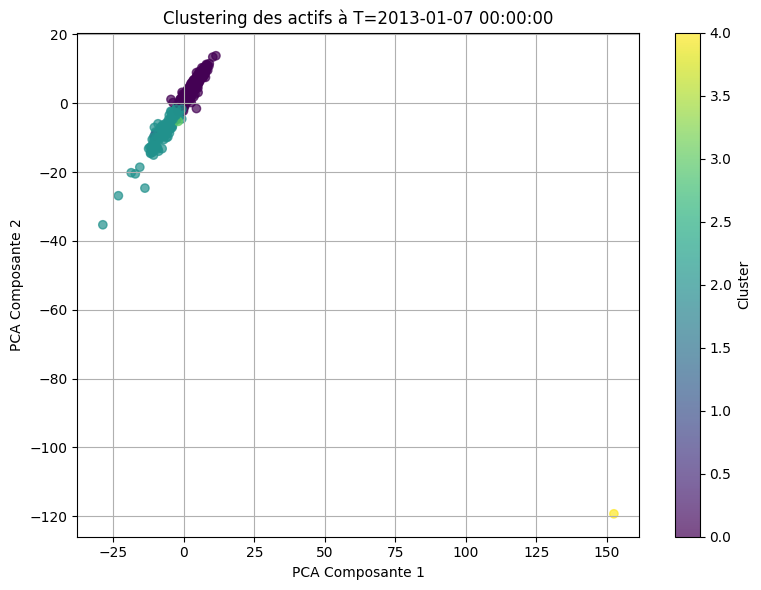

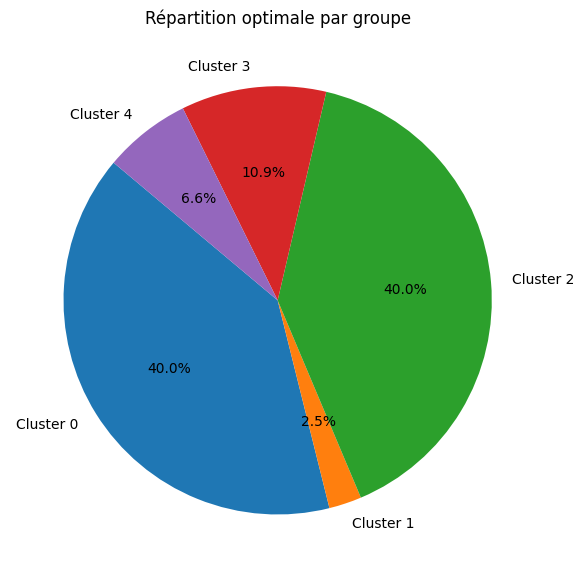

Rééquilibrage à T=2013-04-09 00:00:00
Poids optimaux par groupe à T=2013-04-09 00:00:00 : [0.4  0.03 0.4  0.11 0.06]


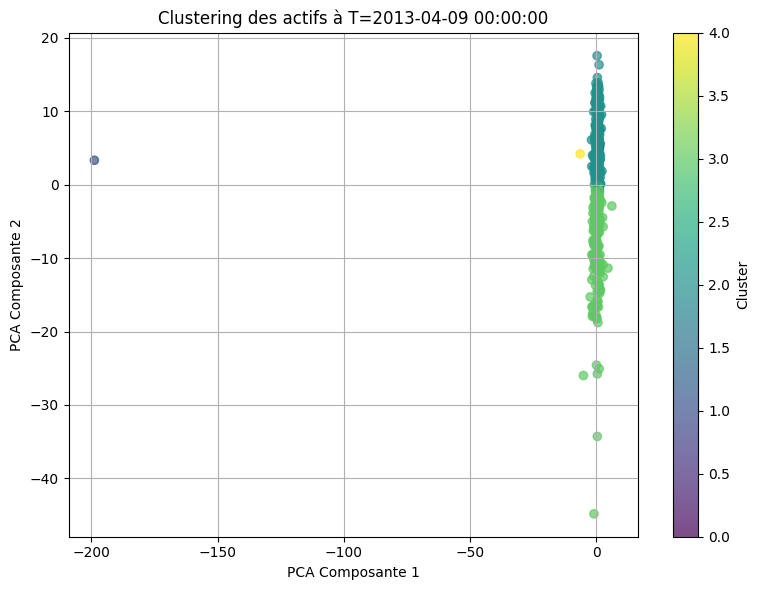

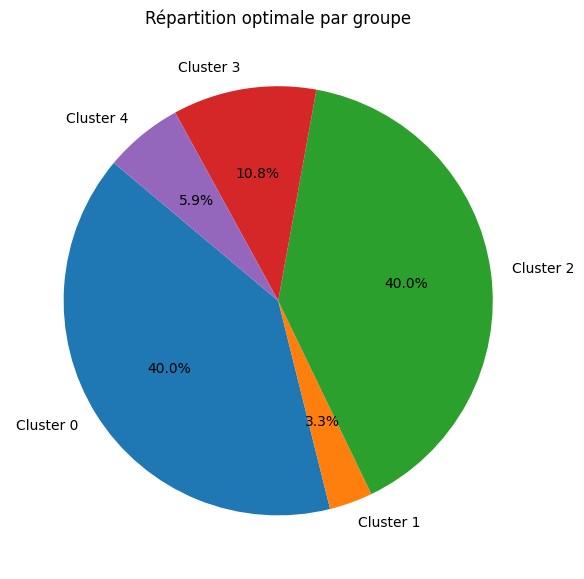

Rééquilibrage à T=2013-07-09 00:00:00
Poids optimaux par groupe à T=2013-07-09 00:00:00 : [0.16 0.   0.4  0.04 0.4 ]


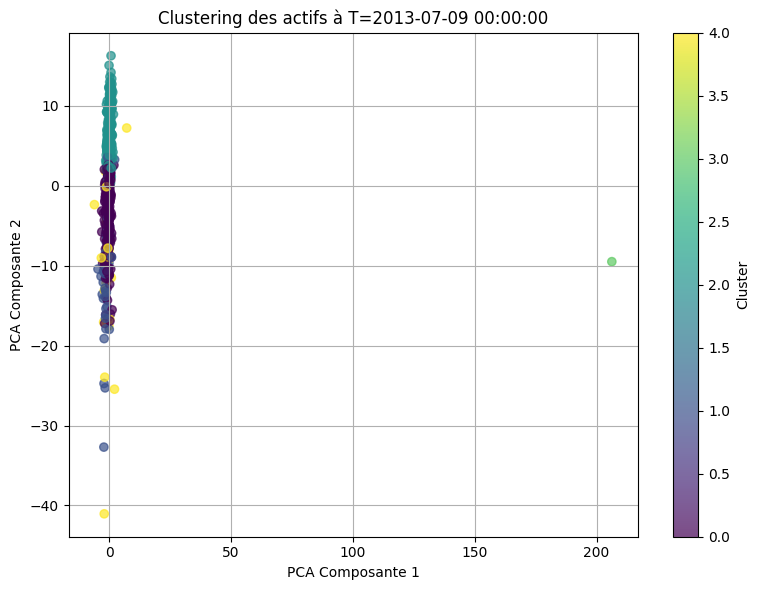

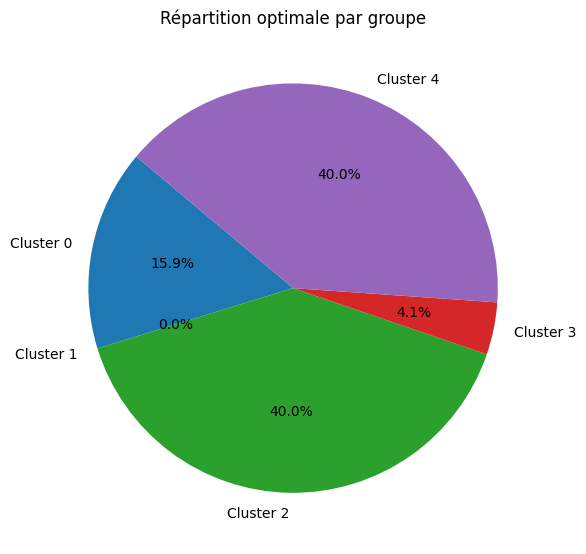

Rééquilibrage à T=2013-10-07 00:00:00
Poids optimaux par groupe à T=2013-10-07 00:00:00 : [0.4  0.4  0.   0.05 0.15]


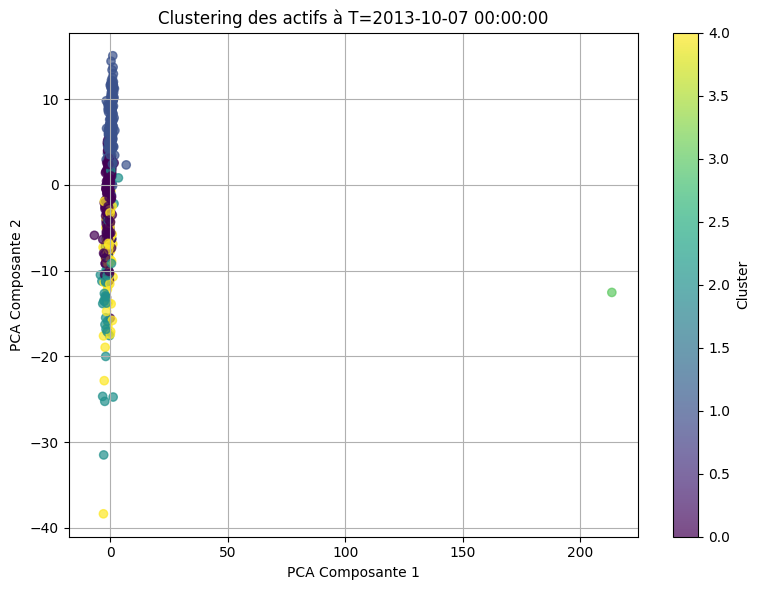

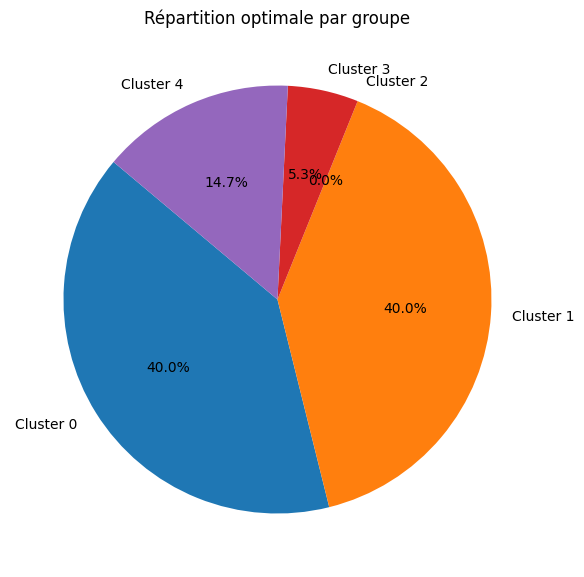

Rééquilibrage à T=2014-01-07 00:00:00
Poids optimaux par groupe à T=2014-01-07 00:00:00 : [0.16 0.08 0.2  0.4  0.16]


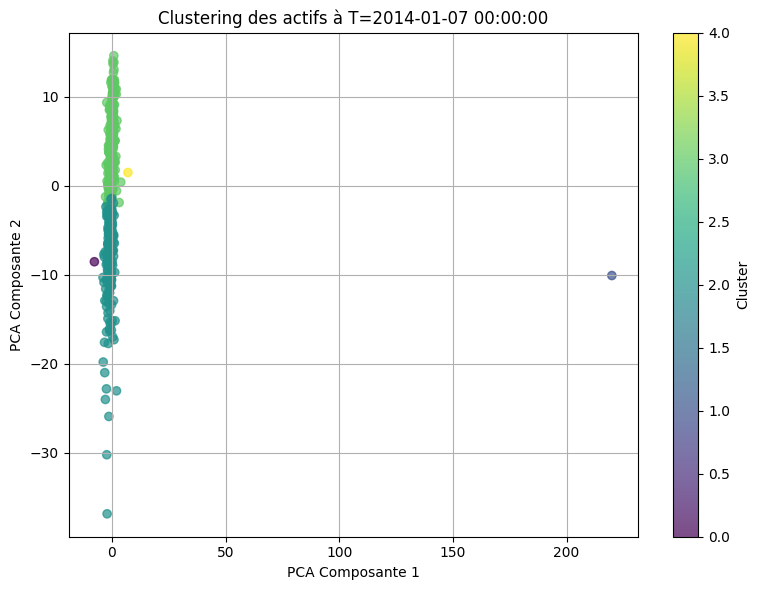

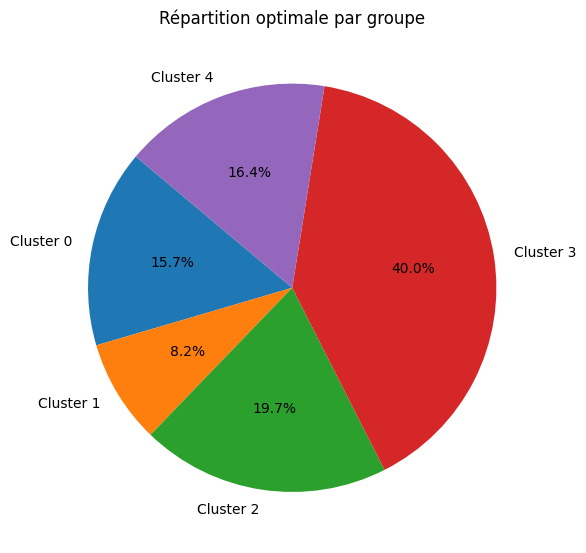

Rééquilibrage à T=2014-04-08 00:00:00
Poids optimaux par groupe à T=2014-04-08 00:00:00 : [0.   0.08 0.4  0.35 0.17]


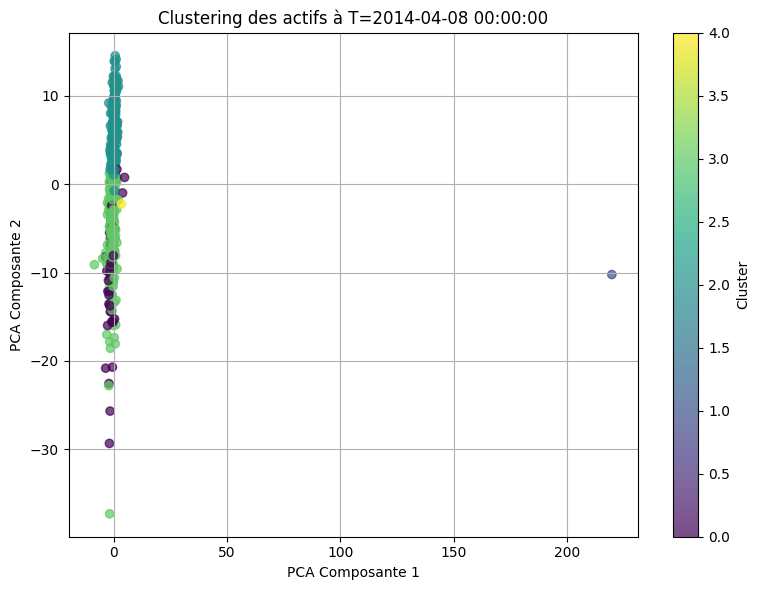

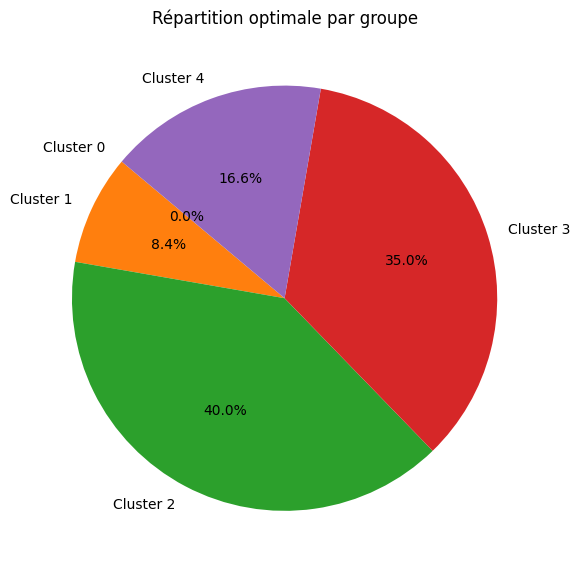

Rééquilibrage à T=2014-07-09 00:00:00
Poids optimaux par groupe à T=2014-07-09 00:00:00 : [0.02 0.11 0.4  0.4  0.08]


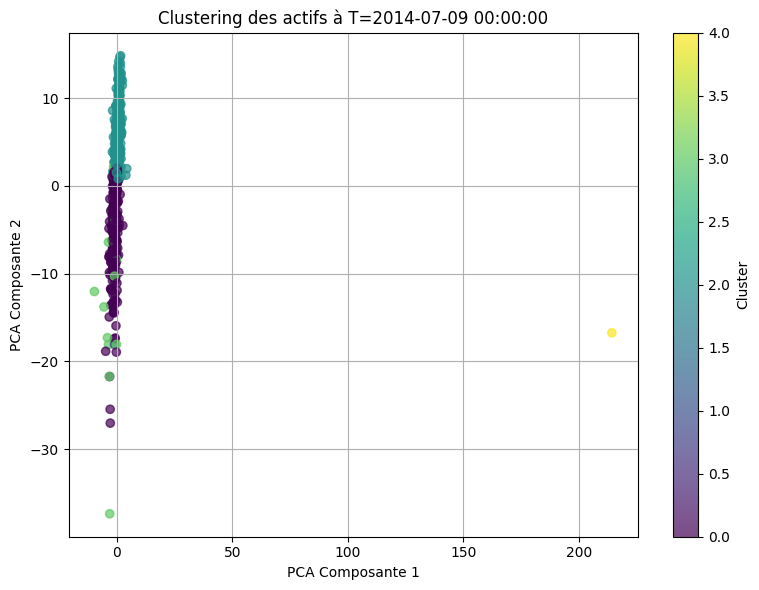

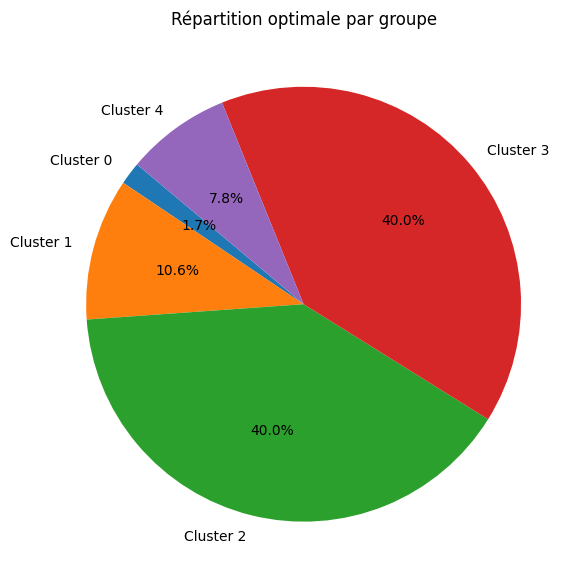

Rééquilibrage à T=2014-10-07 00:00:00
Poids optimaux par groupe à T=2014-10-07 00:00:00 : [0.4  0.07 0.4  0.08 0.05]


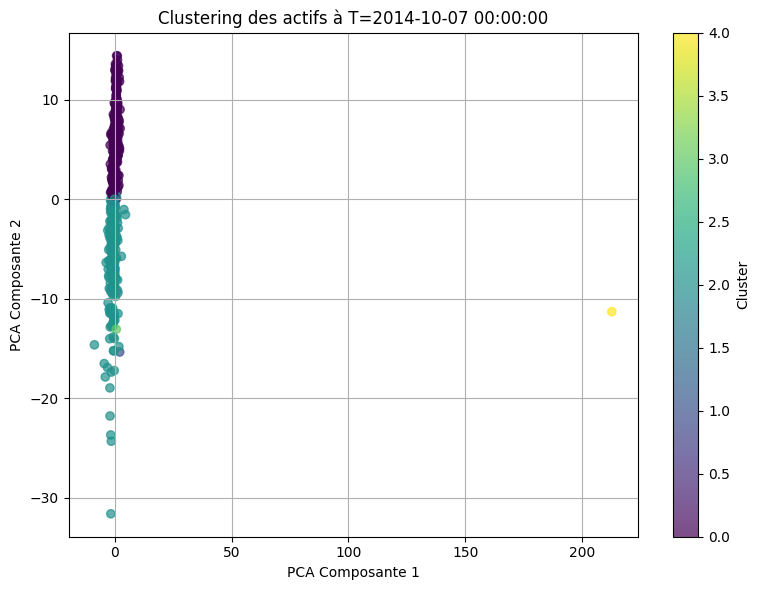

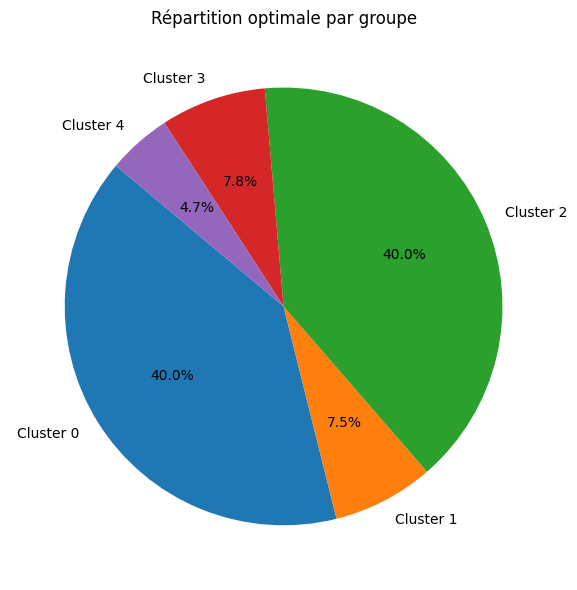

Rééquilibrage à T=2015-01-07 00:00:00
Poids optimaux par groupe à T=2015-01-07 00:00:00 : [0.11 0.4  0.39 0.04 0.07]


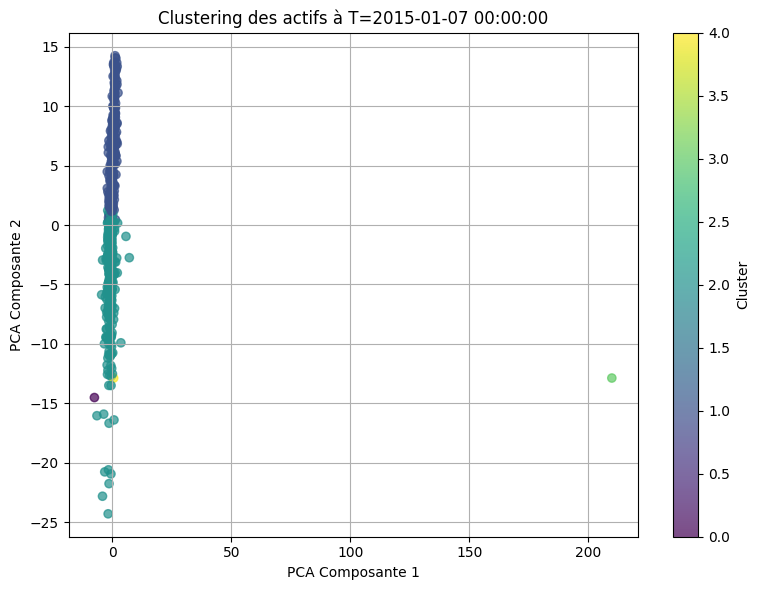

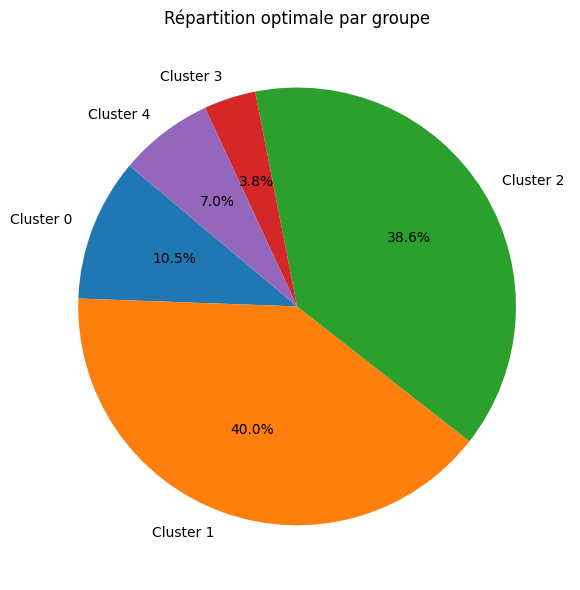

Rééquilibrage à T=2015-04-09 00:00:00
Poids optimaux par groupe à T=2015-04-09 00:00:00 : [0.4  0.4  0.16 0.   0.04]


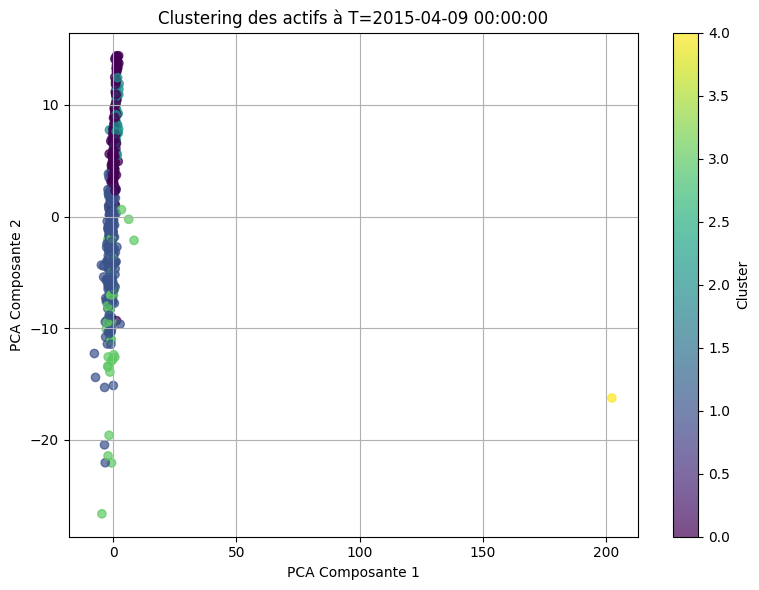

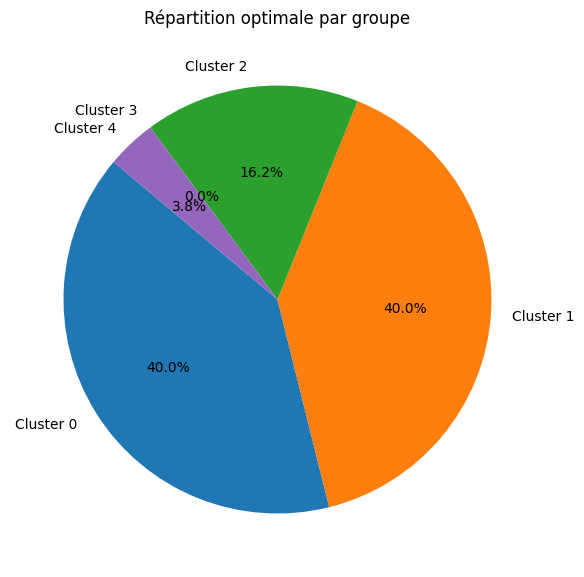

Rééquilibrage à T=2015-07-09 00:00:00
Poids optimaux par groupe à T=2015-07-09 00:00:00 : [0.4  0.06 0.   0.4  0.14]


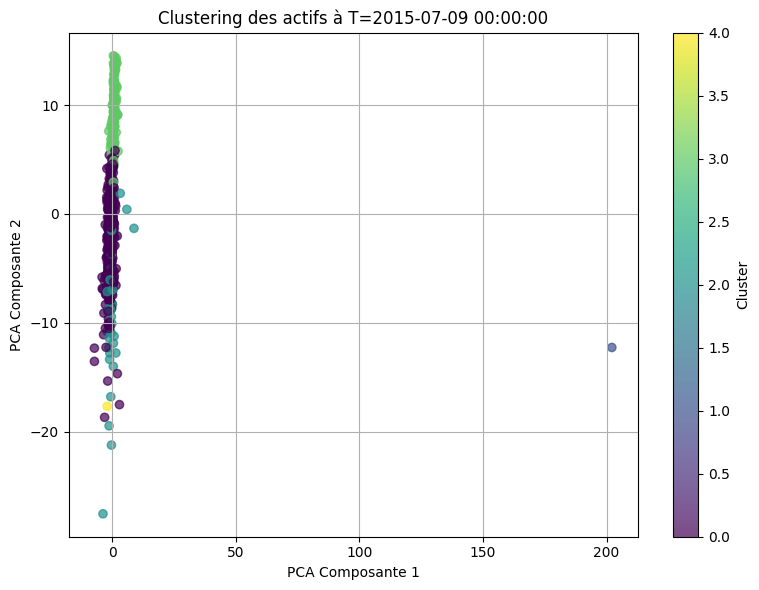

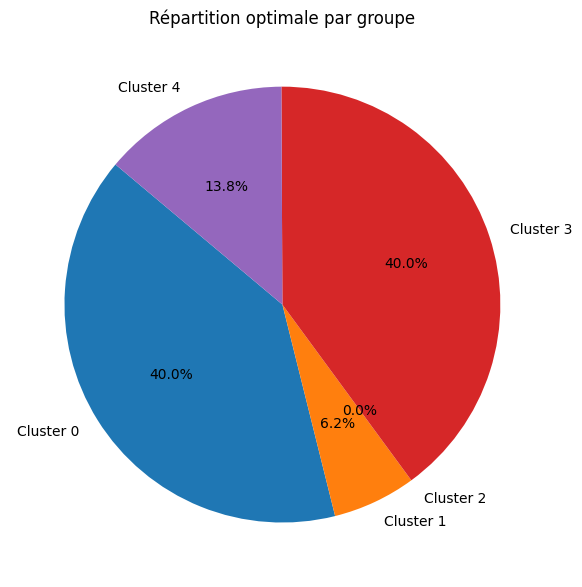

Rééquilibrage à T=2015-10-07 00:00:00
Poids optimaux par groupe à T=2015-10-07 00:00:00 : [0.4  0.4  0.06 0.14 0.  ]


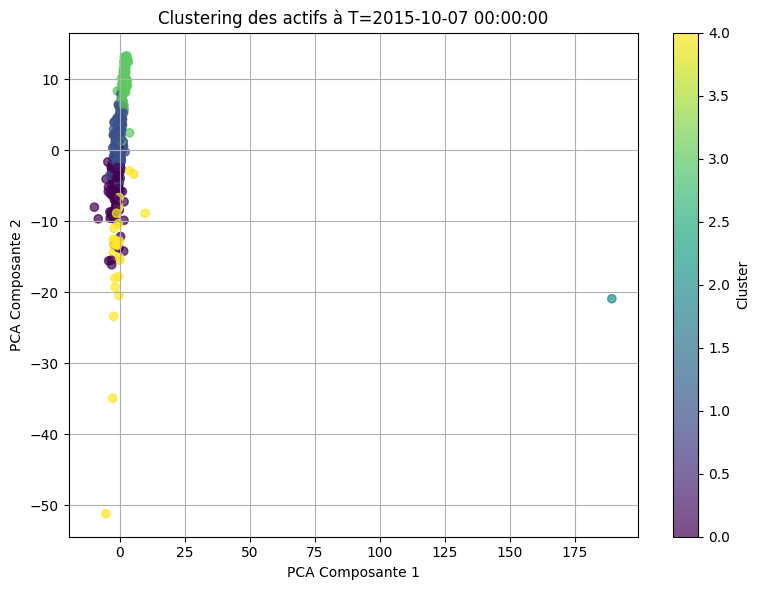

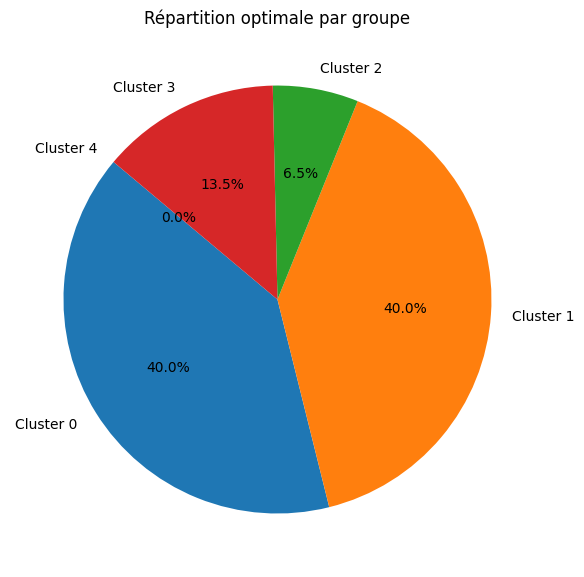

Rééquilibrage à T=2016-01-07 00:00:00
Poids optimaux par groupe à T=2016-01-07 00:00:00 : [0.4  0.11 0.09 0.4  0.  ]


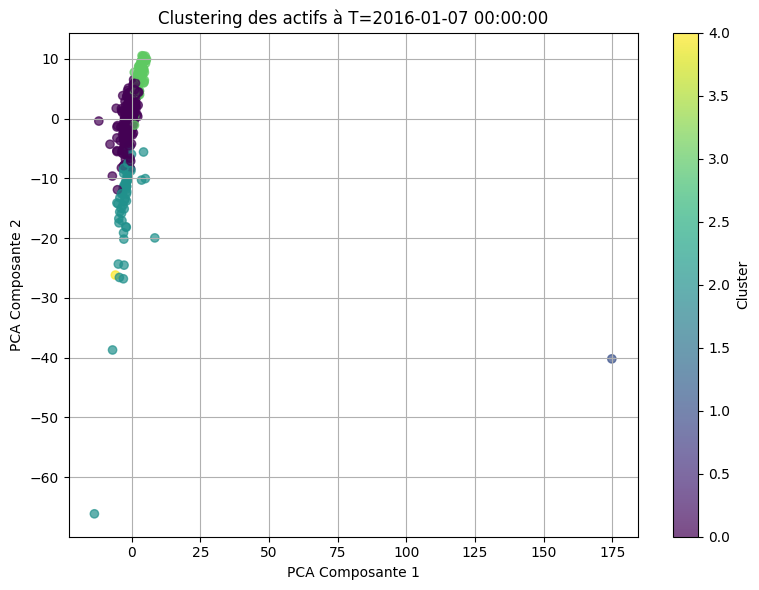

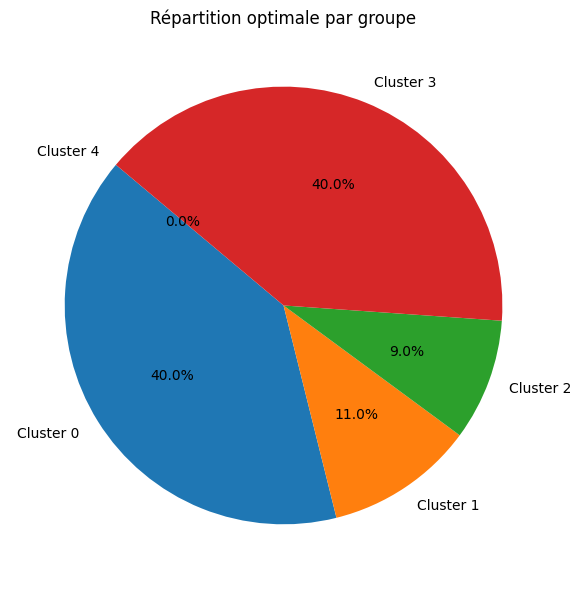

Rééquilibrage à T=2016-04-08 00:00:00
Poids optimaux par groupe à T=2016-04-08 00:00:00 : [0.4  0.   0.27 0.08 0.25]


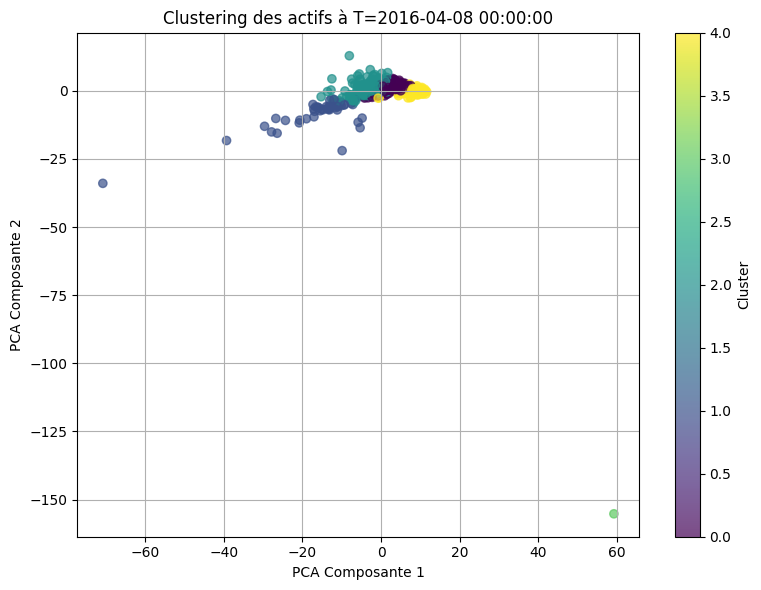

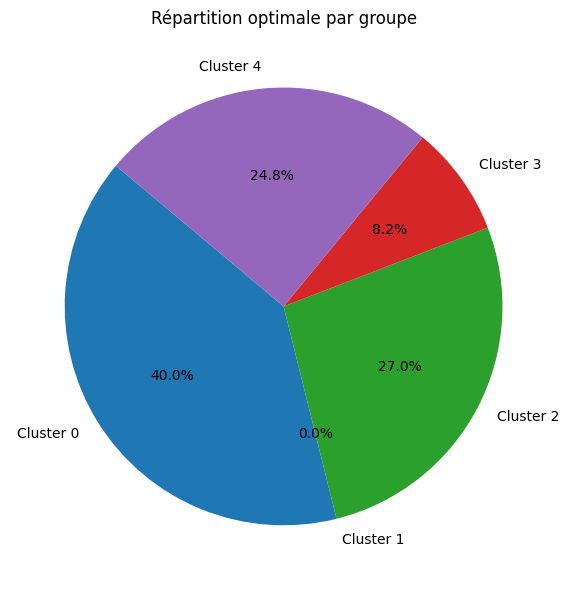

Rééquilibrage à T=2016-07-08 00:00:00
Poids optimaux par groupe à T=2016-07-08 00:00:00 : [0.4  0.05 0.4  0.11 0.03]


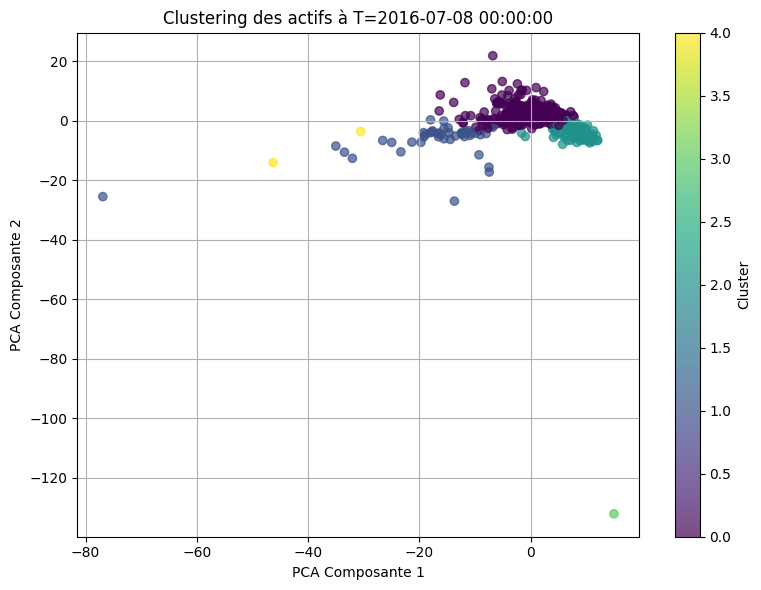

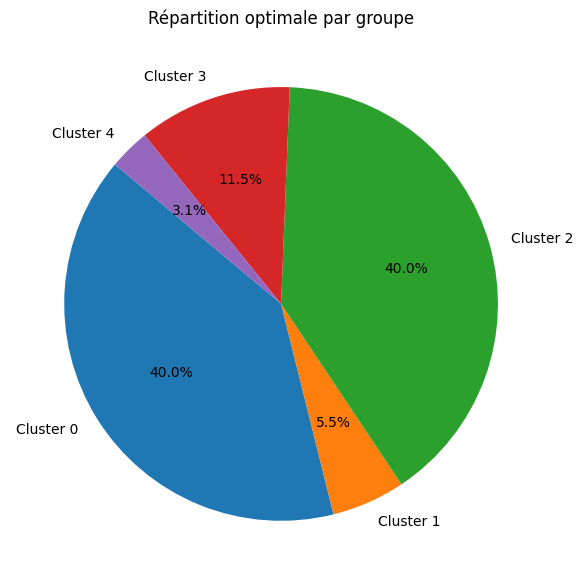

Rééquilibrage à T=2016-10-06 00:00:00
Poids optimaux par groupe à T=2016-10-06 00:00:00 : [0.22 0.   0.3  0.09 0.4 ]


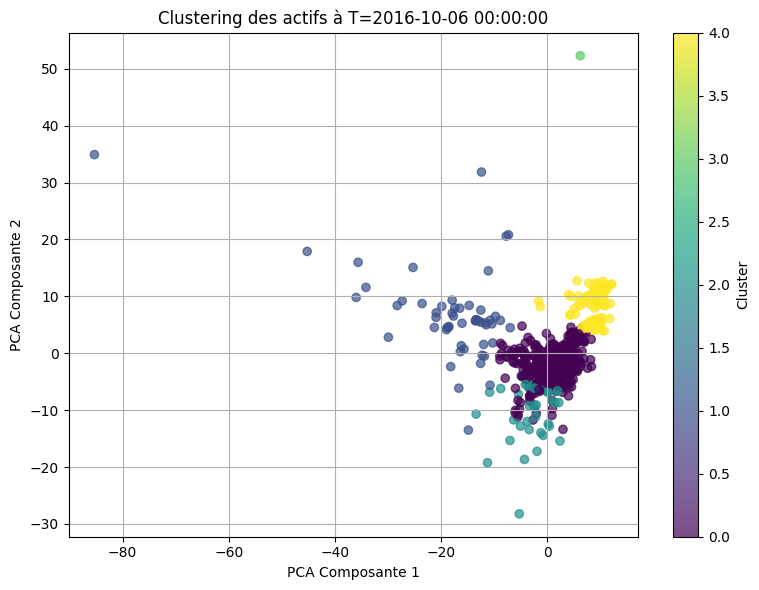

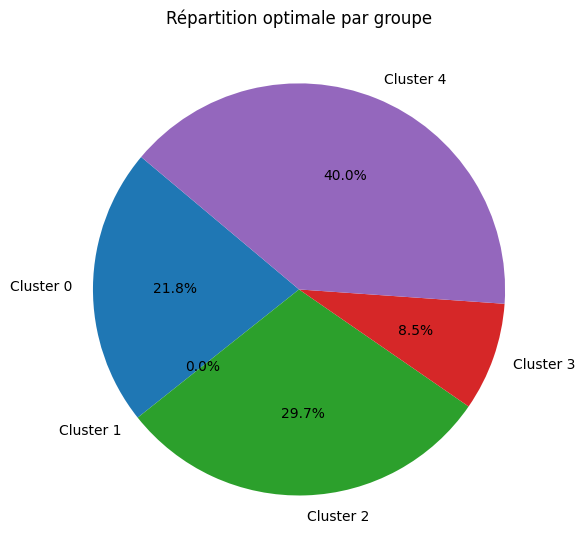

Rééquilibrage à T=2017-01-06 00:00:00
Poids optimaux par groupe à T=2017-01-06 00:00:00 : [0.4  0.06 0.14 0.4  0.  ]


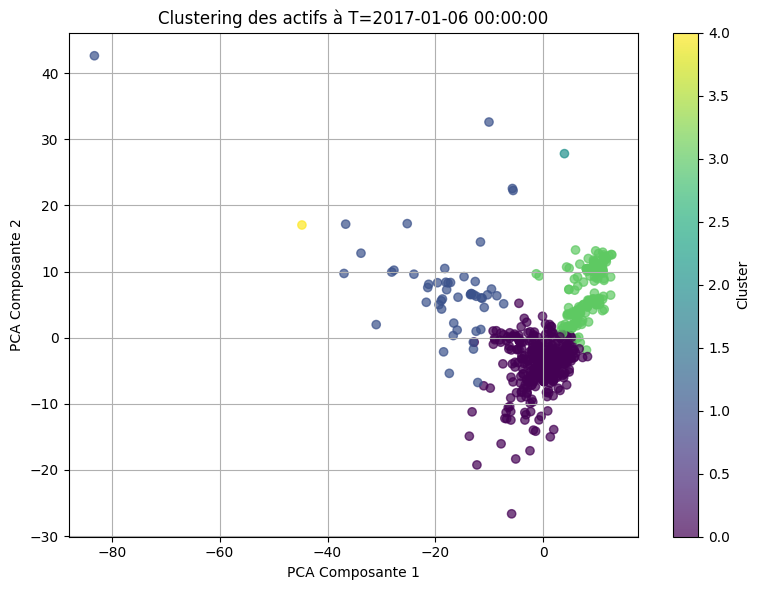

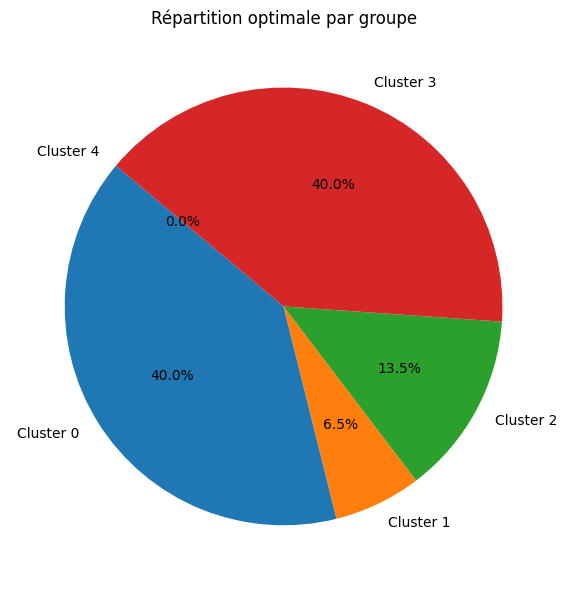

Rééquilibrage à T=2017-04-07 00:00:00
Poids optimaux par groupe à T=2017-04-07 00:00:00 : [0.11 0.4  0.09 0.4  0.  ]


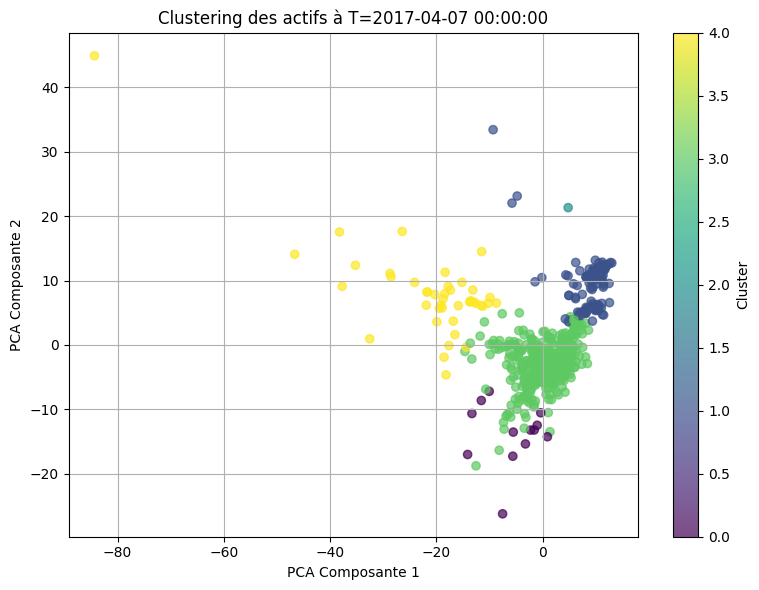

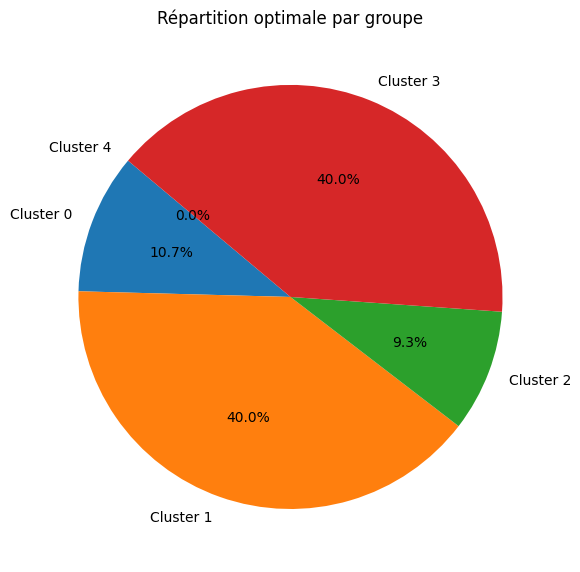

Rééquilibrage à T=2017-07-10 00:00:00
Poids optimaux par groupe à T=2017-07-10 00:00:00 : [0.2 0.4 0.4 0.  0. ]


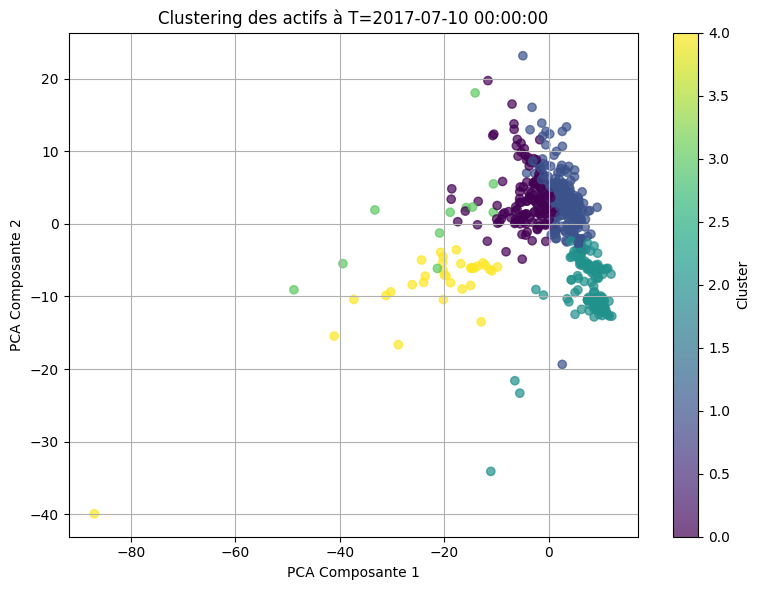

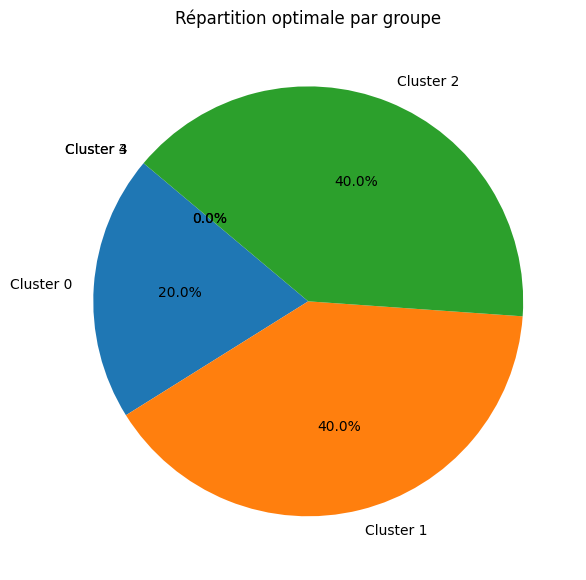

Rééquilibrage à T=2017-10-06 00:00:00
Poids optimaux par groupe à T=2017-10-06 00:00:00 : [0.08 0.4  0.12 0.4  0.  ]


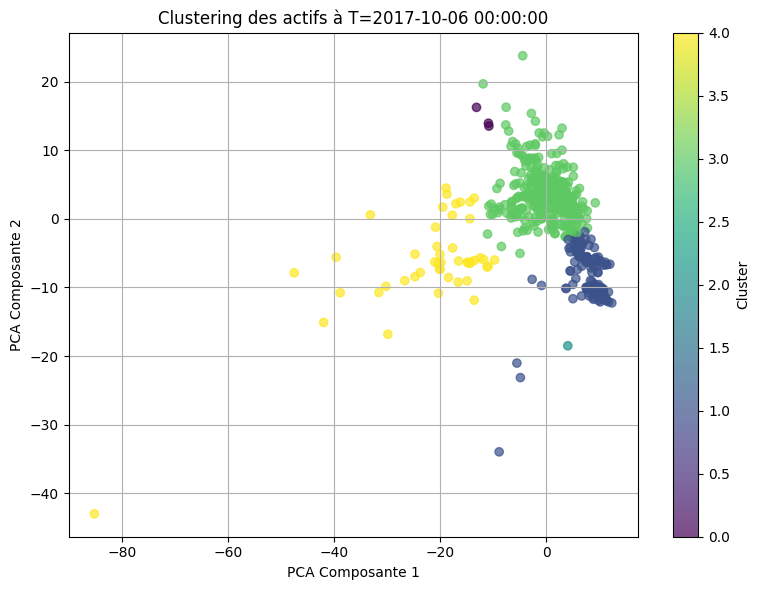

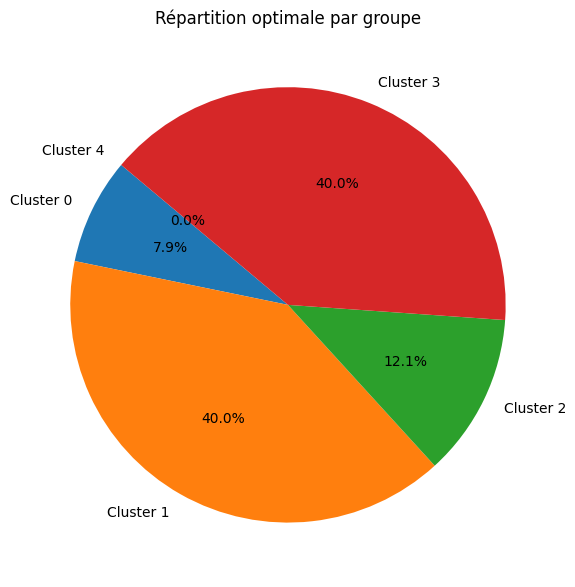

Rééquilibrage à T=2018-01-08 00:00:00
Poids optimaux par groupe à T=2018-01-08 00:00:00 : [0.19 0.   0.01 0.4  0.4 ]


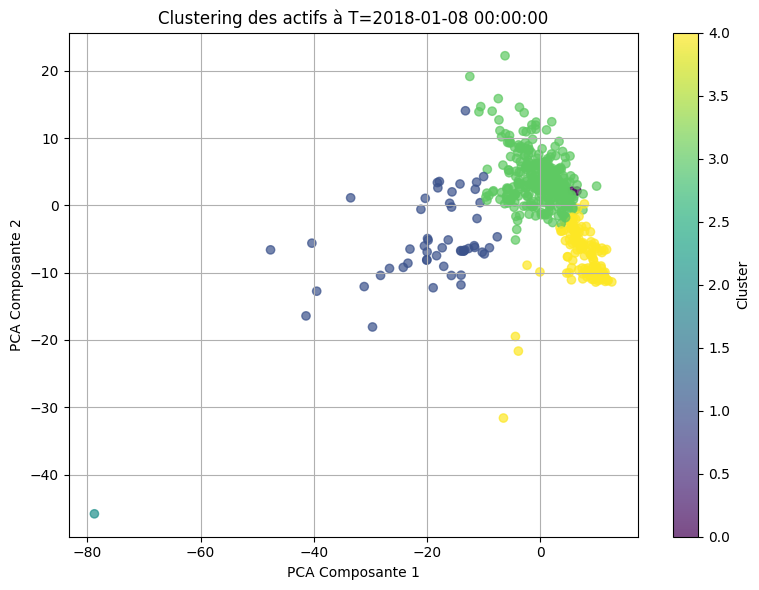

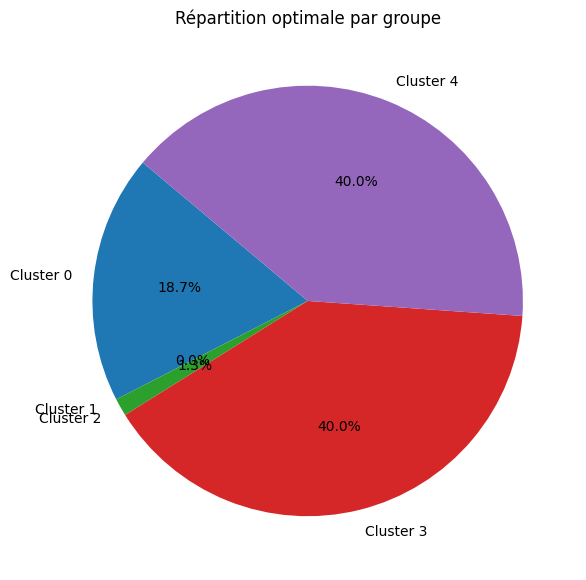

Rééquilibrage à T=2018-04-10 00:00:00
Poids optimaux par groupe à T=2018-04-10 00:00:00 : [0.4  0.01 0.   0.4  0.19]


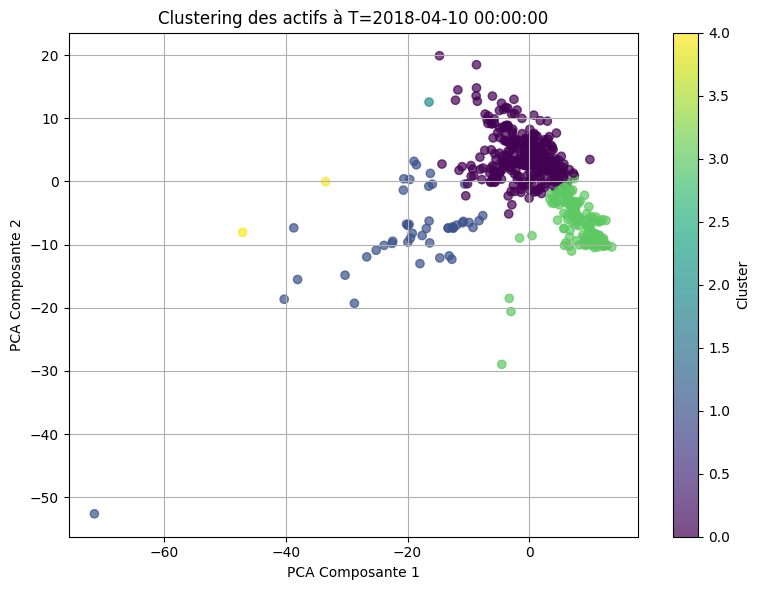

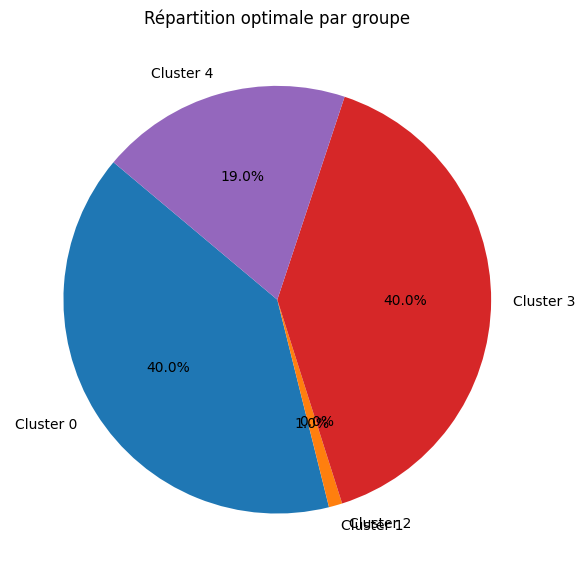

Rééquilibrage à T=2018-07-10 00:00:00
Poids optimaux par groupe à T=2018-07-10 00:00:00 : [0.15 0.01 0.04 0.4  0.4 ]


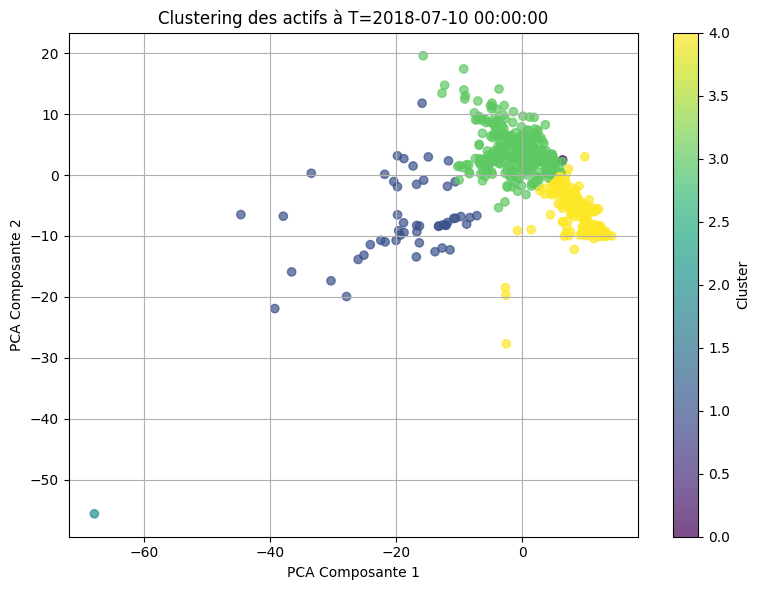

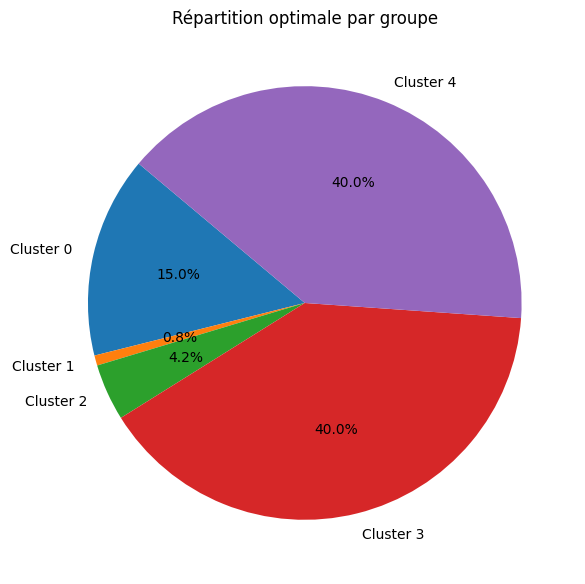

Rééquilibrage à T=2018-10-08 00:00:00
Poids optimaux par groupe à T=2018-10-08 00:00:00 : [0.4  0.14 0.   0.06 0.4 ]


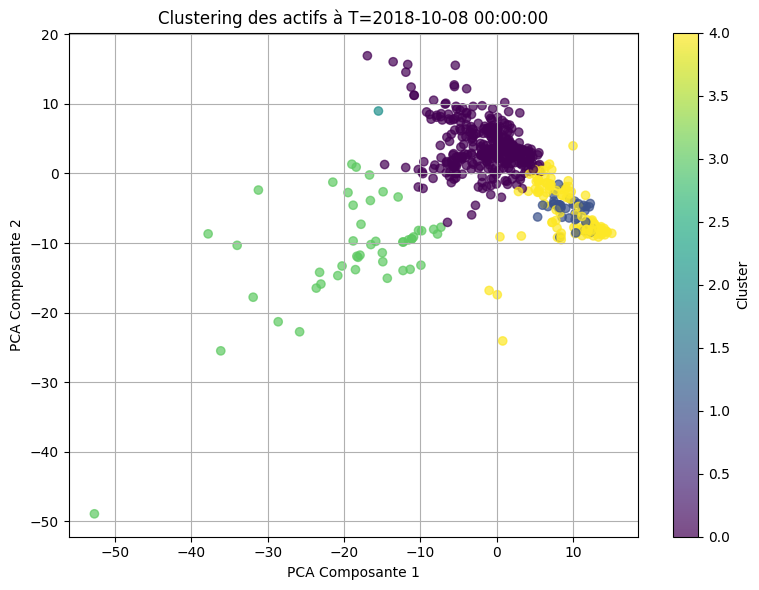

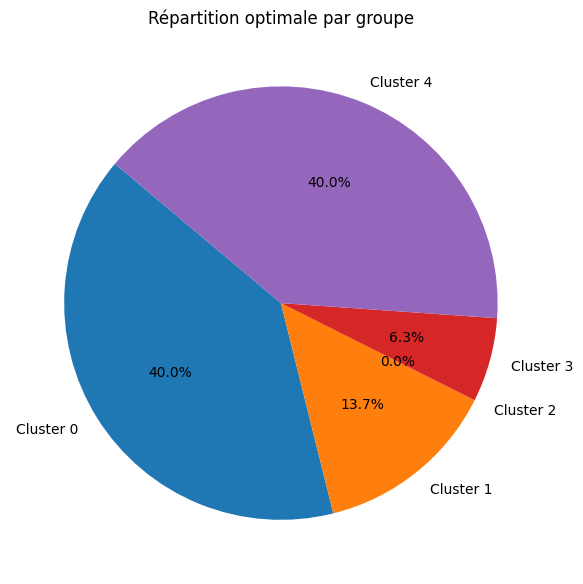

Rééquilibrage à T=2019-01-09 00:00:00
Poids optimaux par groupe à T=2019-01-09 00:00:00 : [0.   0.4  0.4  0.02 0.18]


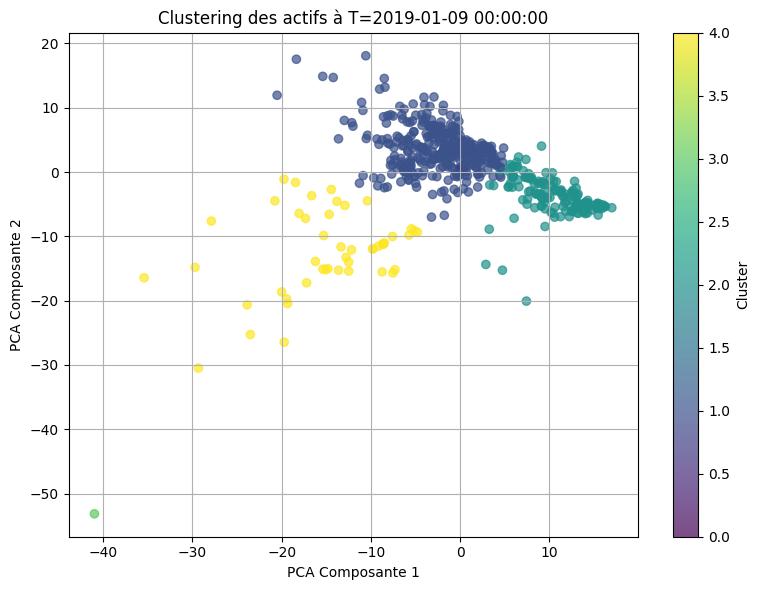

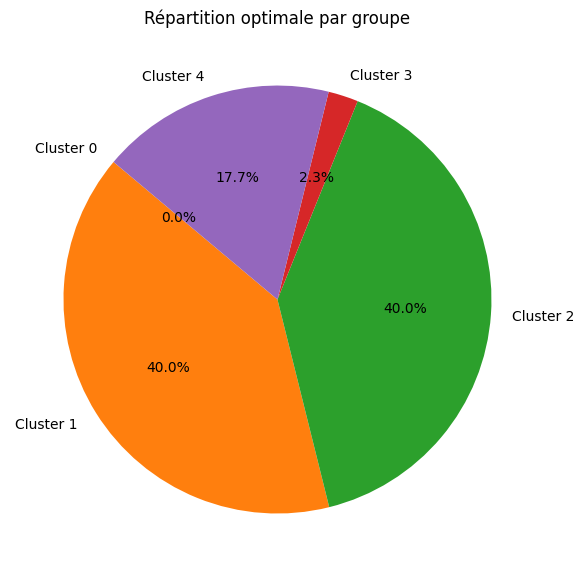

Rééquilibrage à T=2019-04-10 00:00:00
Poids optimaux par groupe à T=2019-04-10 00:00:00 : [0.2 0.  0.  0.4 0.4]


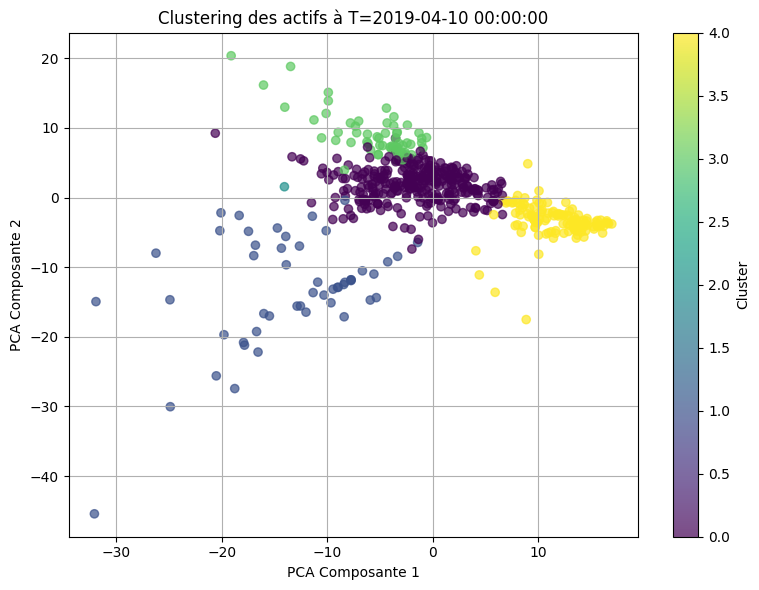

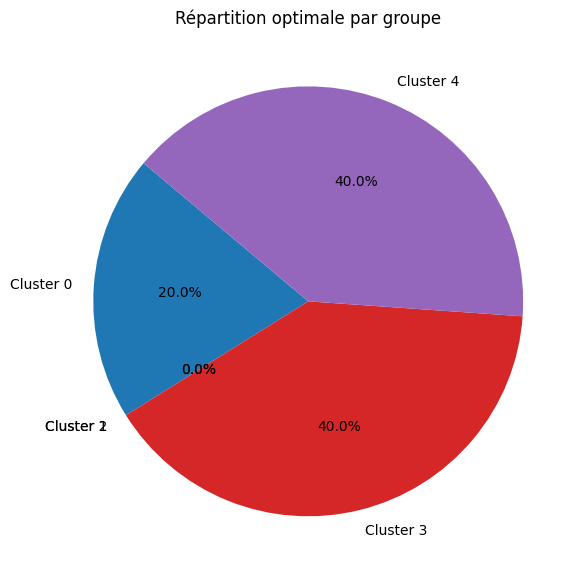

Rééquilibrage à T=2019-07-11 00:00:00
Poids optimaux par groupe à T=2019-07-11 00:00:00 : [0.4  0.28 0.   0.32 0.  ]


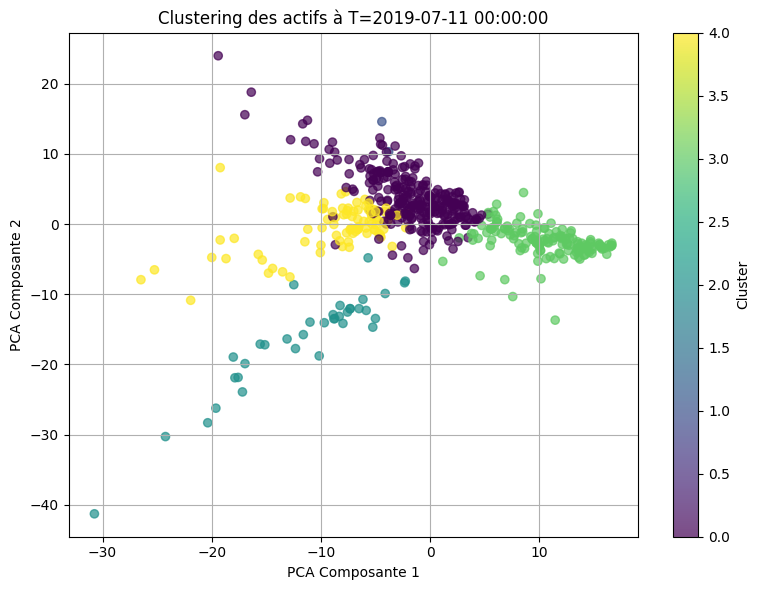

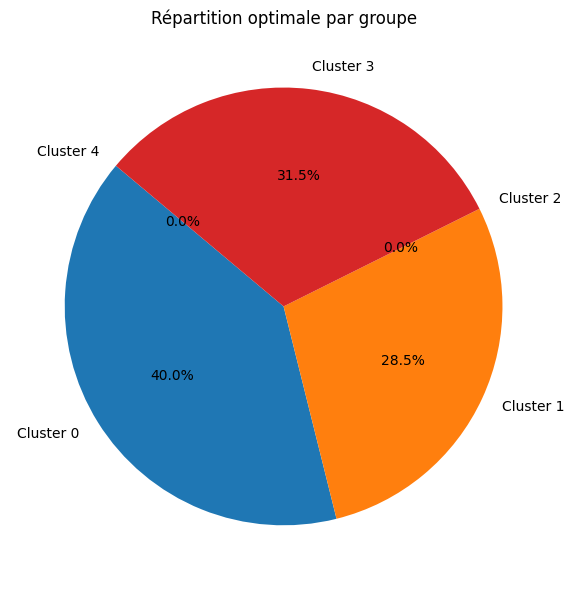

Rééquilibrage à T=2019-10-09 00:00:00
Poids optimaux par groupe à T=2019-10-09 00:00:00 : [0.2 0.4 0.  0.4 0. ]


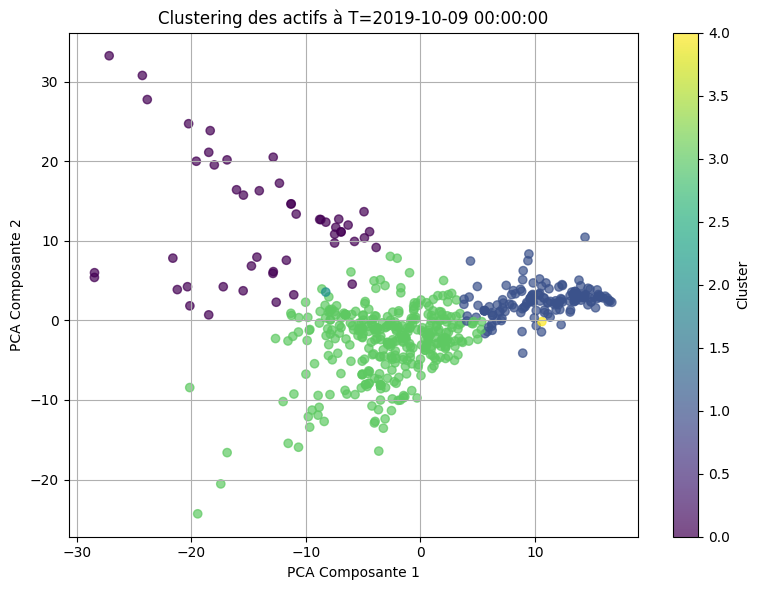

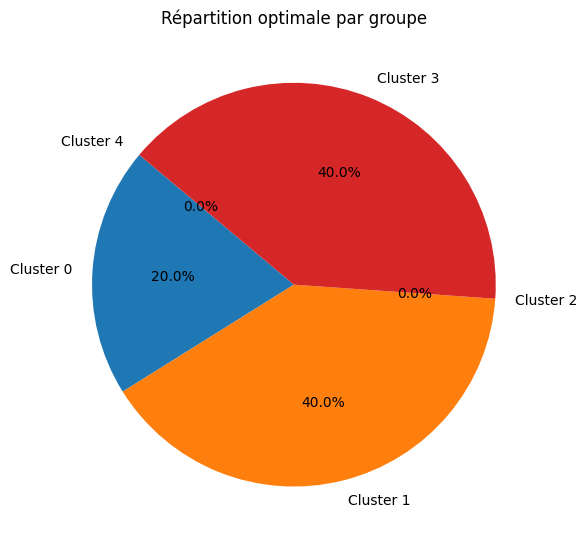

Rééquilibrage à T=2020-01-09 00:00:00
Poids optimaux par groupe à T=2020-01-09 00:00:00 : [0.  0.4 0.2 0.  0.4]


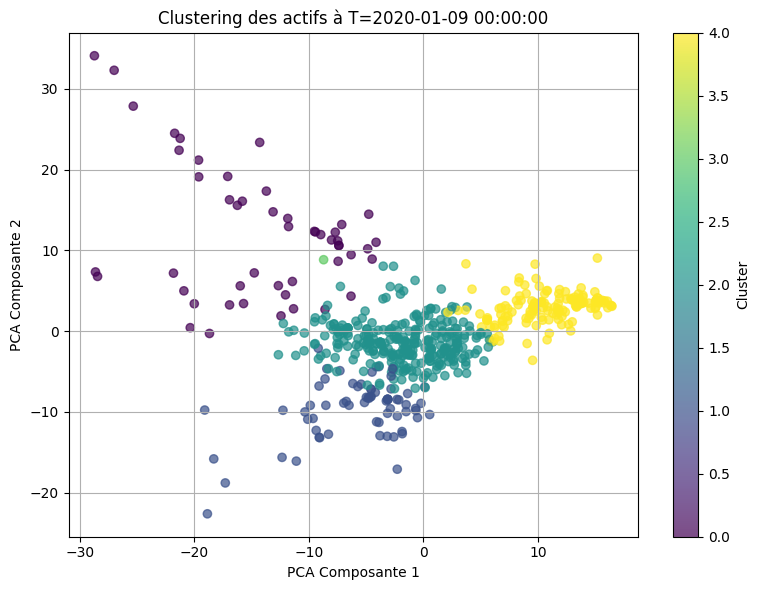

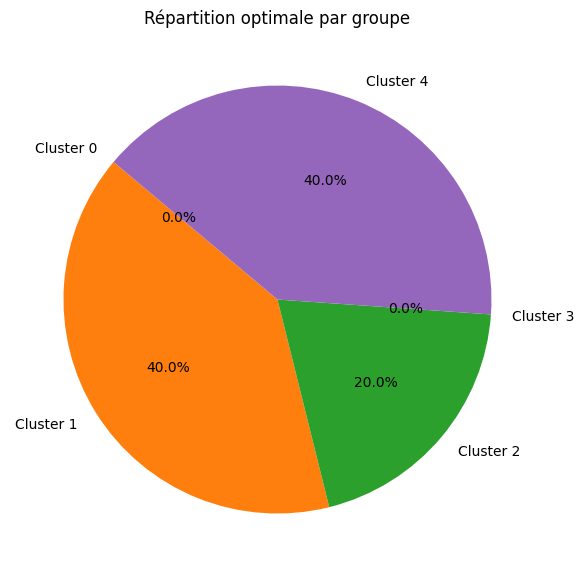

Rééquilibrage à T=2020-04-09 00:00:00
Poids optimaux par groupe à T=2020-04-09 00:00:00 : [0.2 0.  0.  0.4 0.4]


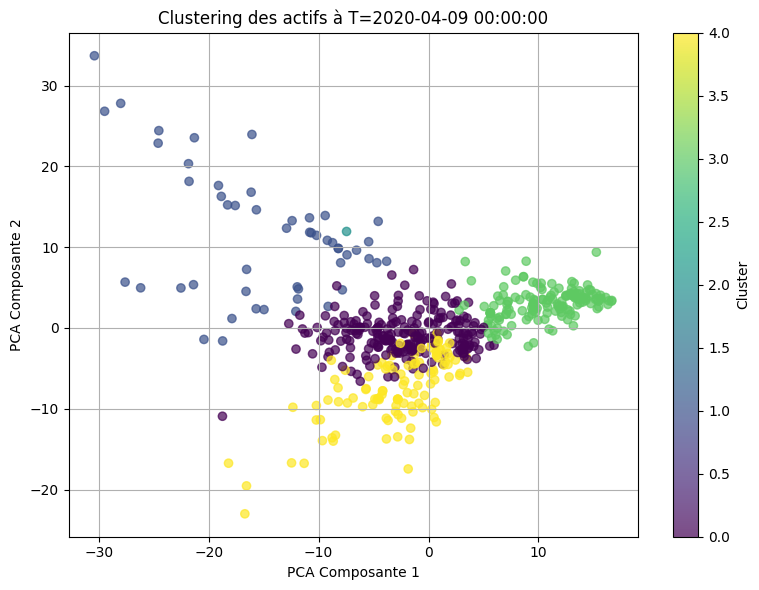

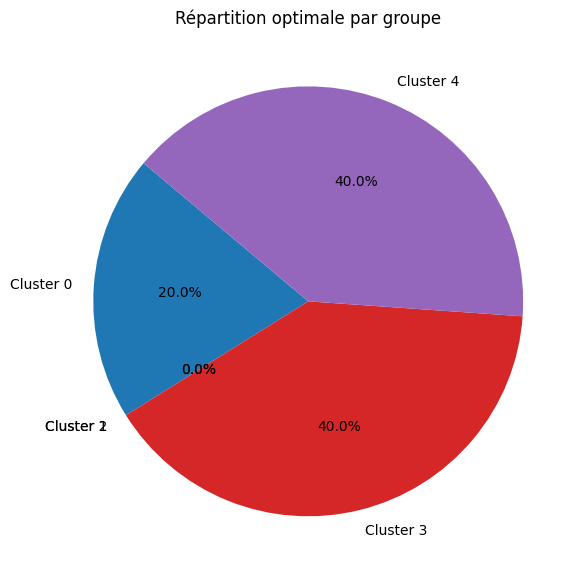

Rééquilibrage à T=2020-07-10 00:00:00
Poids optimaux par groupe à T=2020-07-10 00:00:00 : [0.2 0.  0.  0.4 0.4]


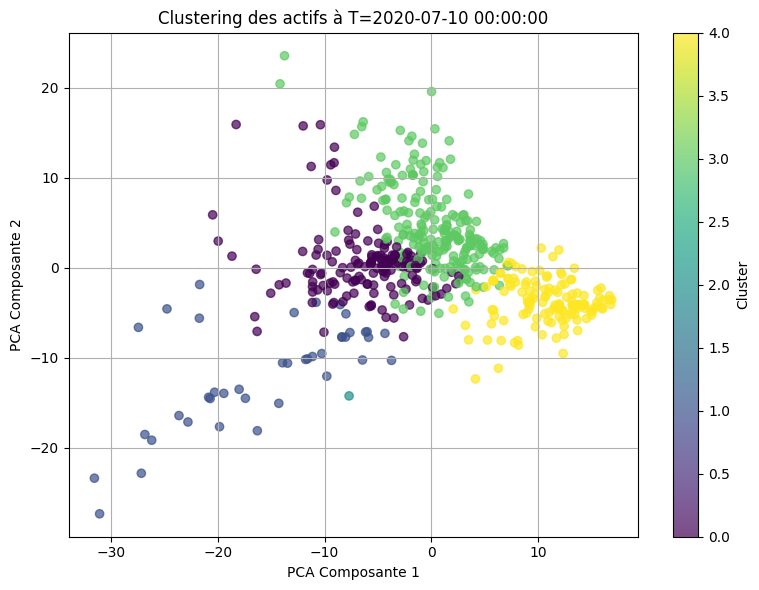

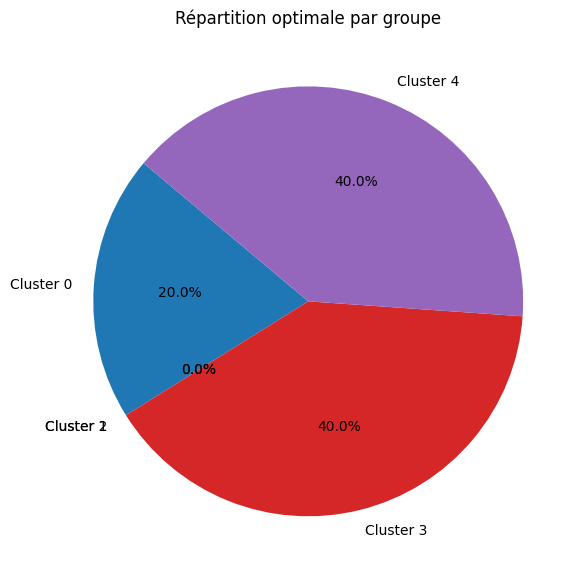

Rééquilibrage à T=2020-10-08 00:00:00
Poids optimaux par groupe à T=2020-10-08 00:00:00 : [0.  0.  0.2 0.4 0.4]


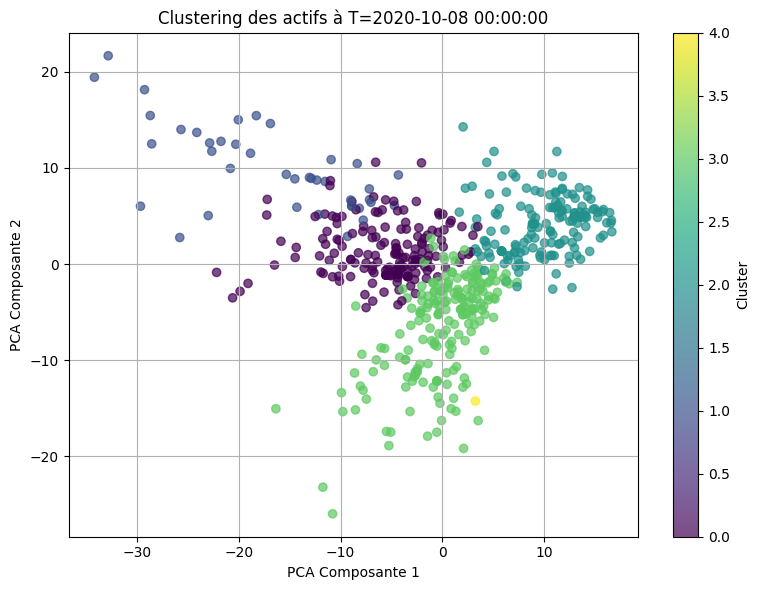

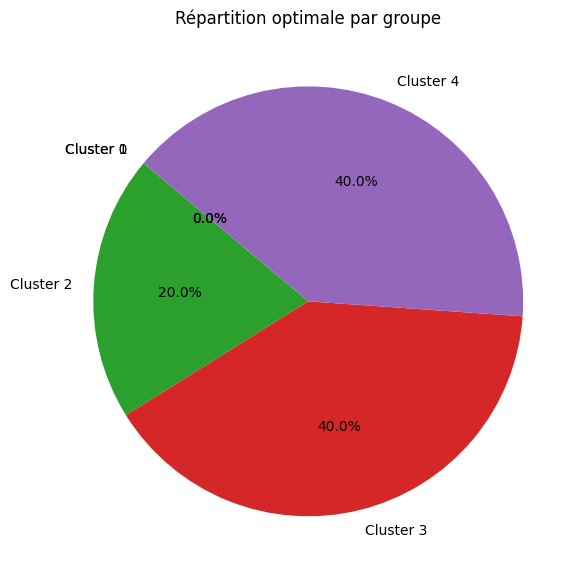

Rééquilibrage à T=2021-01-08 00:00:00
Poids optimaux par groupe à T=2021-01-08 00:00:00 : [0.  0.4 0.2 0.4 0. ]


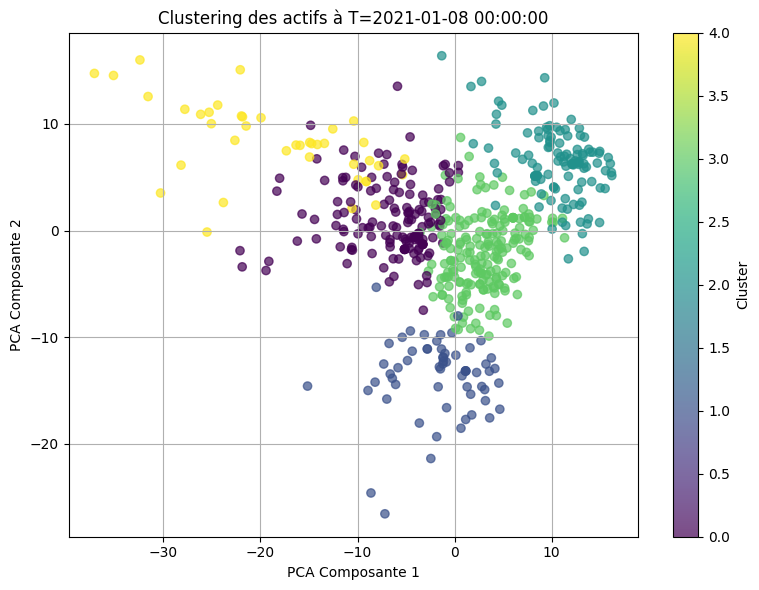

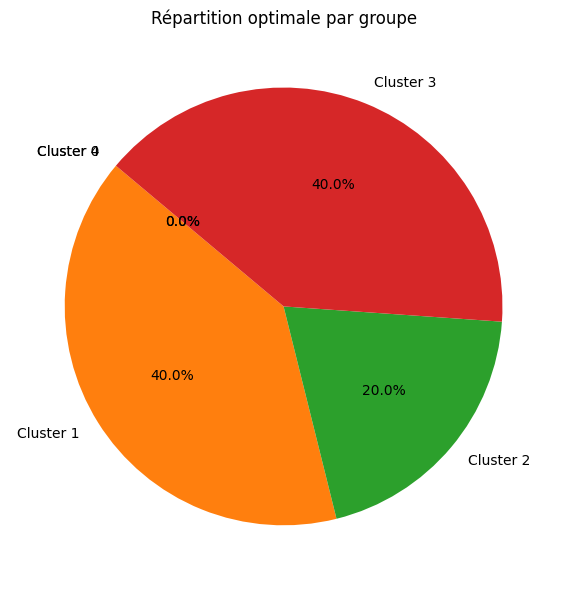

Rééquilibrage à T=2021-04-12 00:00:00
Poids optimaux par groupe à T=2021-04-12 00:00:00 : [0.08 0.4  0.4  0.12 0.  ]


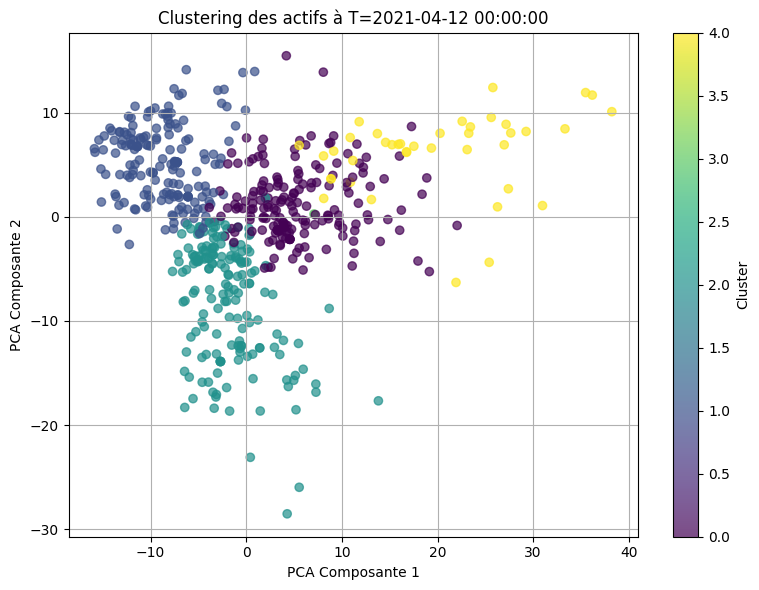

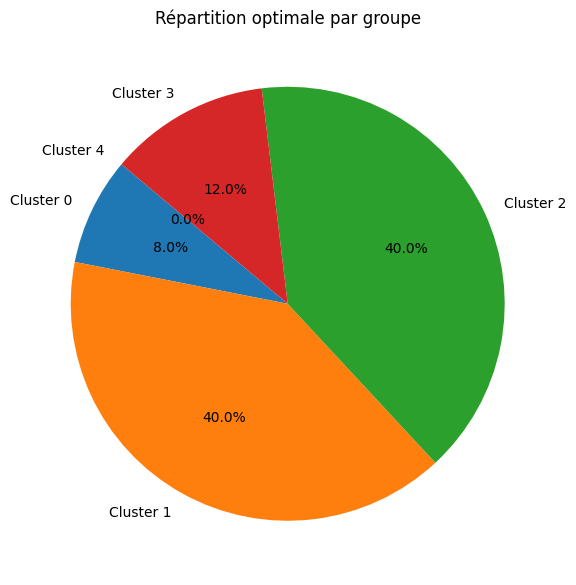

Rééquilibrage à T=2021-07-12 00:00:00
Poids optimaux par groupe à T=2021-07-12 00:00:00 : [0.4  0.   0.16 0.4  0.04]


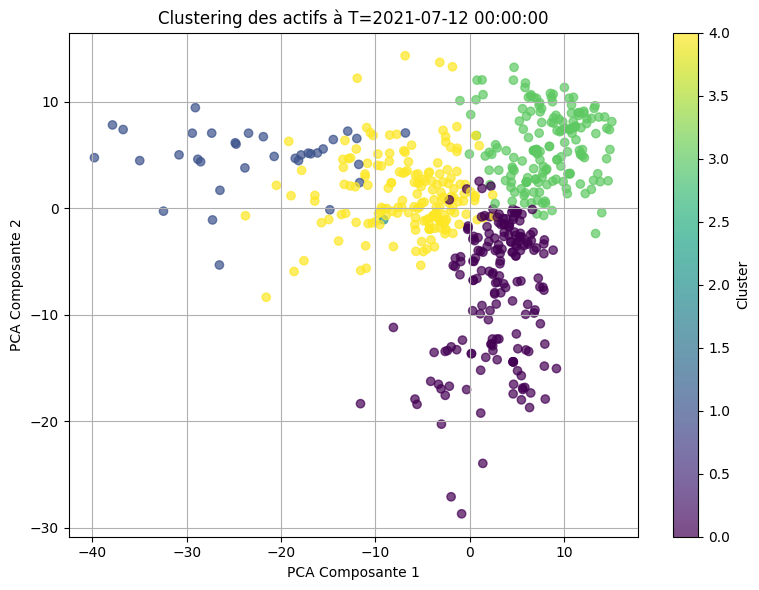

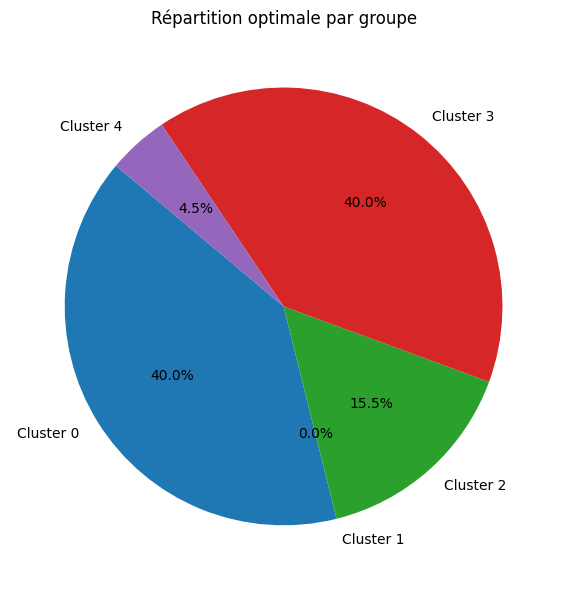

Rééquilibrage à T=2021-10-08 00:00:00
Poids optimaux par groupe à T=2021-10-08 00:00:00 : [0.4  0.4  0.15 0.   0.05]


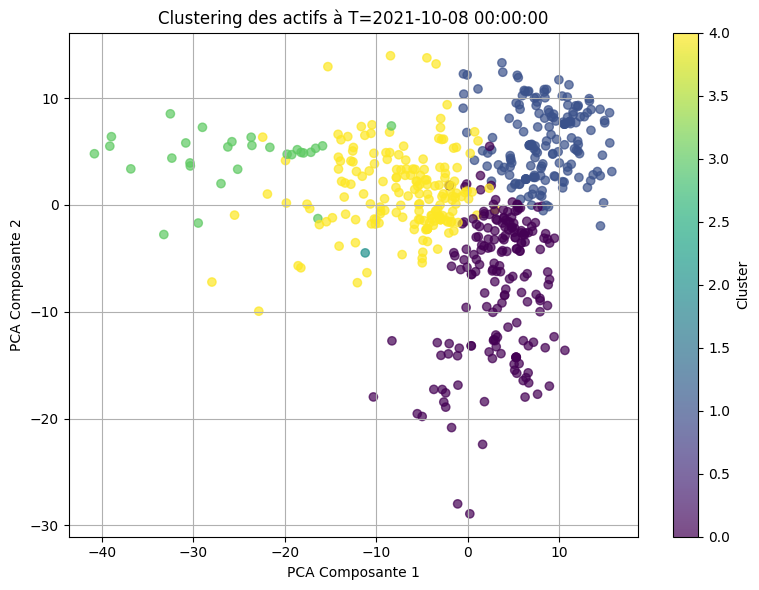

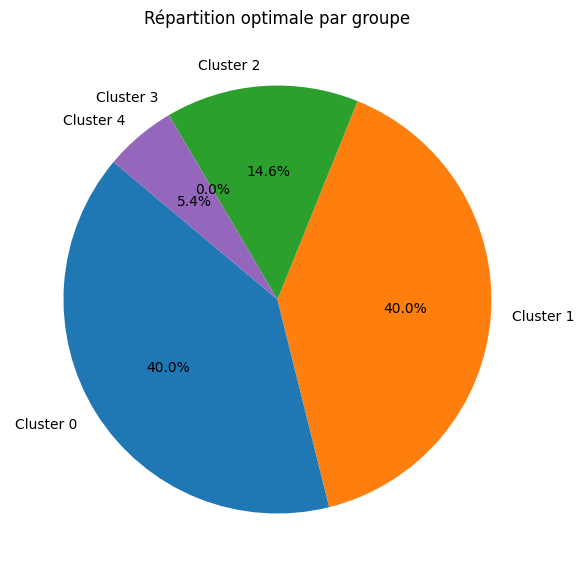

Rééquilibrage à T=2022-01-07 00:00:00
Poids optimaux par groupe à T=2022-01-07 00:00:00 : [0.4  0.4  0.08 0.   0.12]


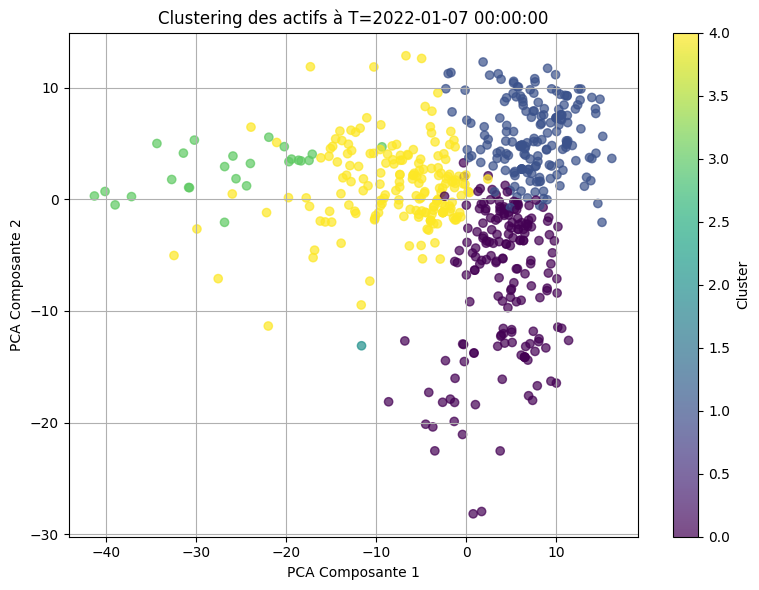

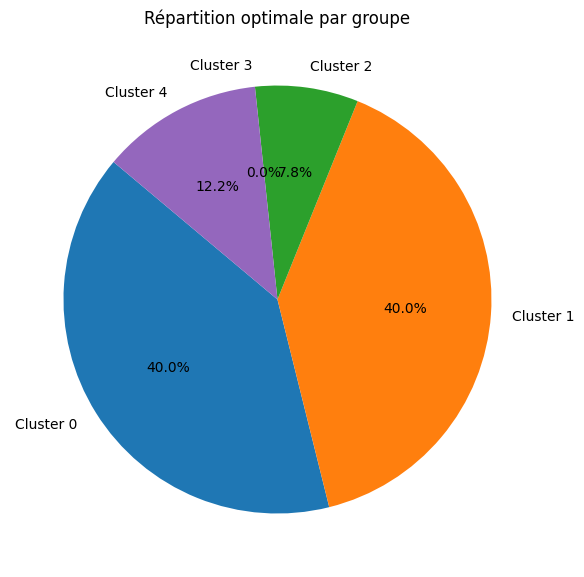

Rééquilibrage à T=2022-04-08 00:00:00
Poids optimaux par groupe à T=2022-04-08 00:00:00 : [0.03 0.4  0.17 0.4  0.  ]


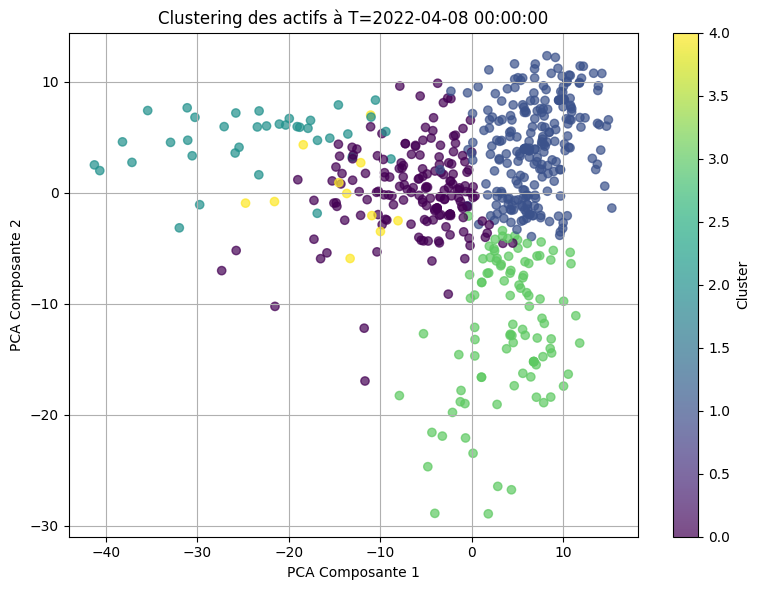

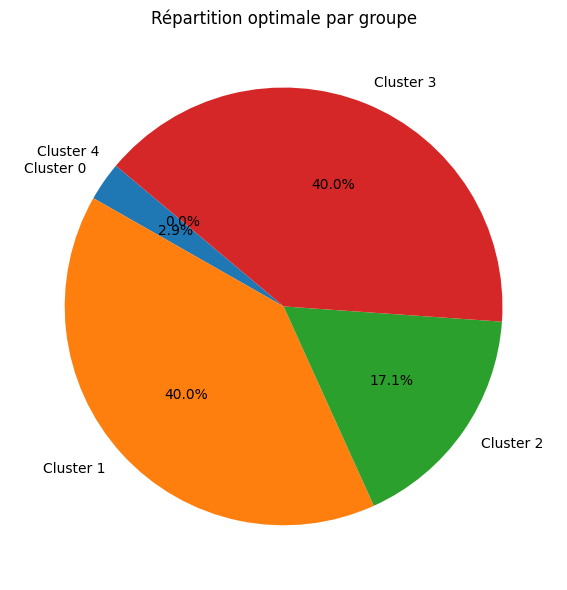

Rééquilibrage à T=2022-07-12 00:00:00
Poids optimaux par groupe à T=2022-07-12 00:00:00 : [0.   0.4  0.15 0.2  0.24]


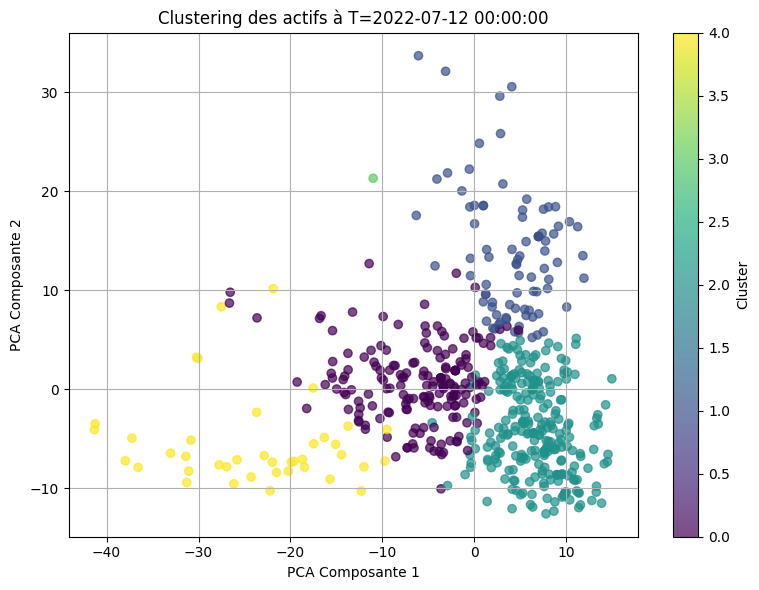

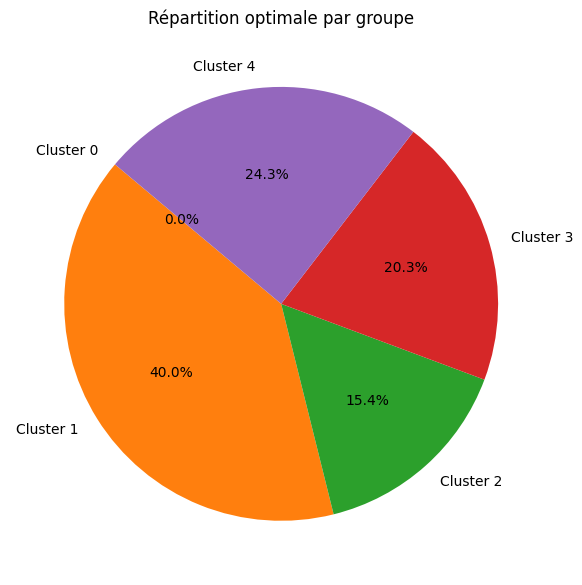

Rééquilibrage à T=2022-10-10 00:00:00
Poids optimaux par groupe à T=2022-10-10 00:00:00 : [0.   0.   0.4  0.24 0.36]


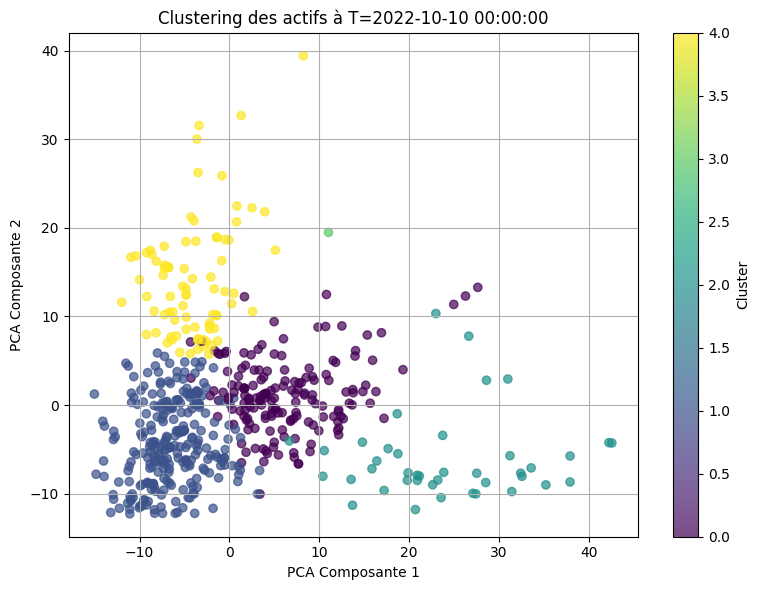

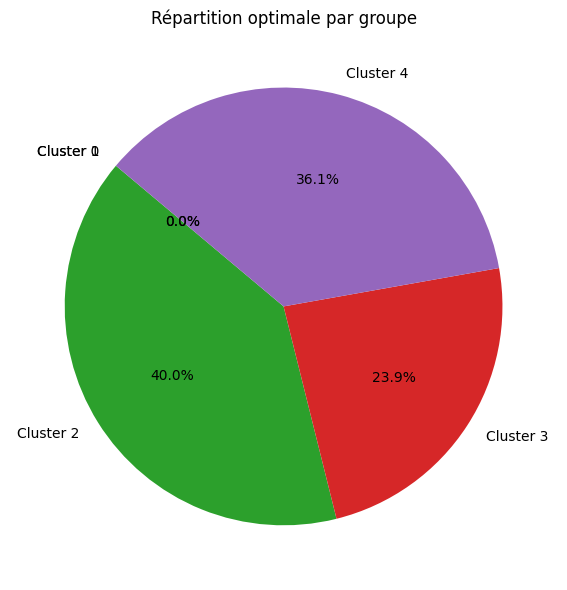

Rééquilibrage à T=2023-01-10 00:00:00
Poids optimaux par groupe à T=2023-01-10 00:00:00 : [0.4  0.31 0.29 0.   0.  ]


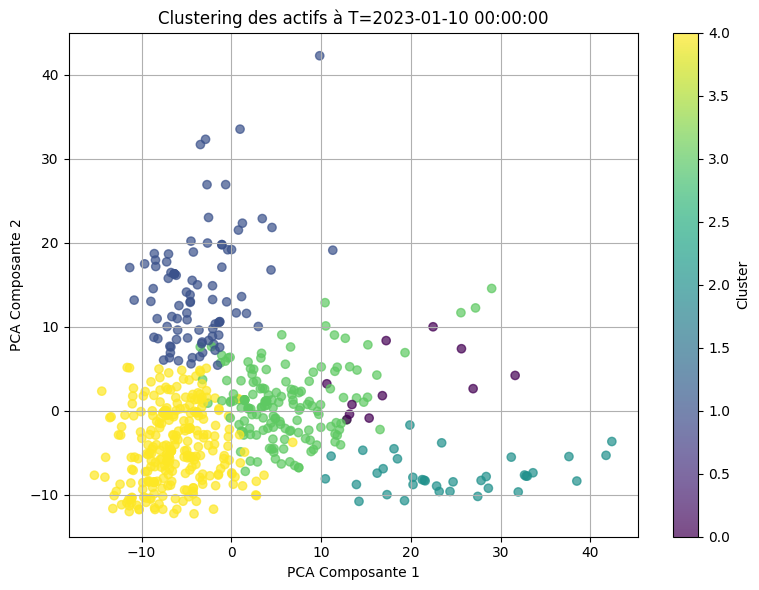

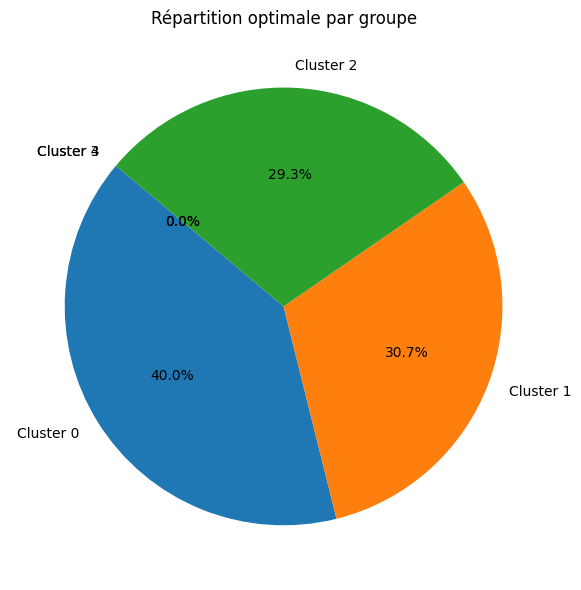

Rééquilibrage à T=2023-04-12 00:00:00
Poids optimaux par groupe à T=2023-04-12 00:00:00 : [0.28 0.   0.37 0.35 0.  ]


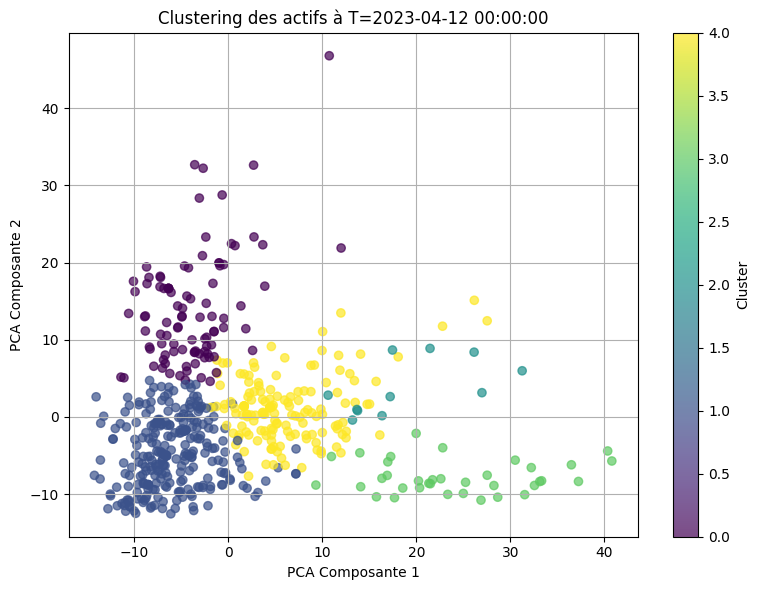

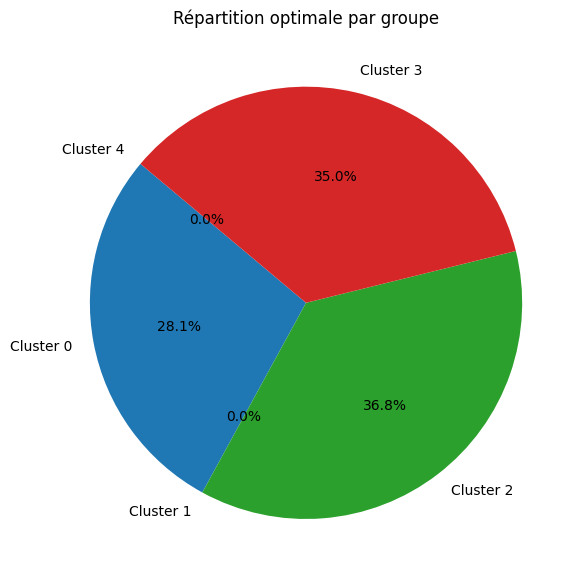

Rééquilibrage à T=2023-07-13 00:00:00
Poids optimaux par groupe à T=2023-07-13 00:00:00 : [0.08 0.4  0.08 0.4  0.04]


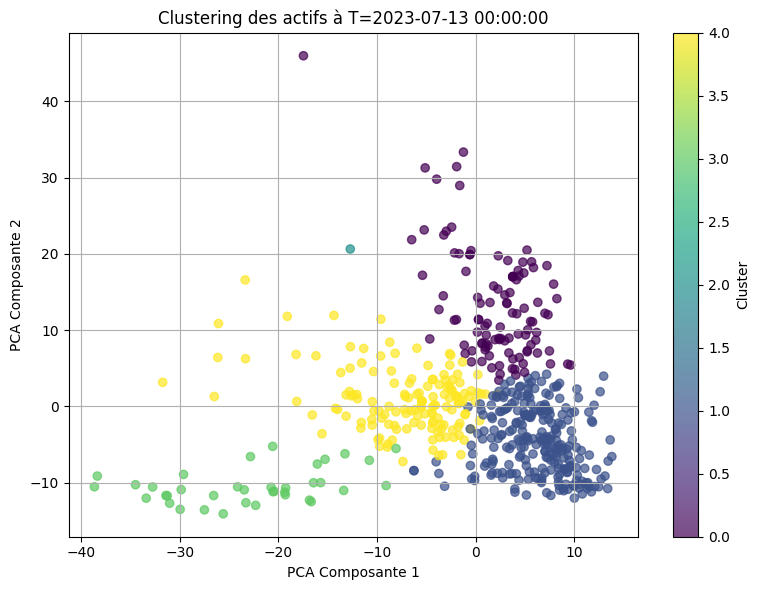

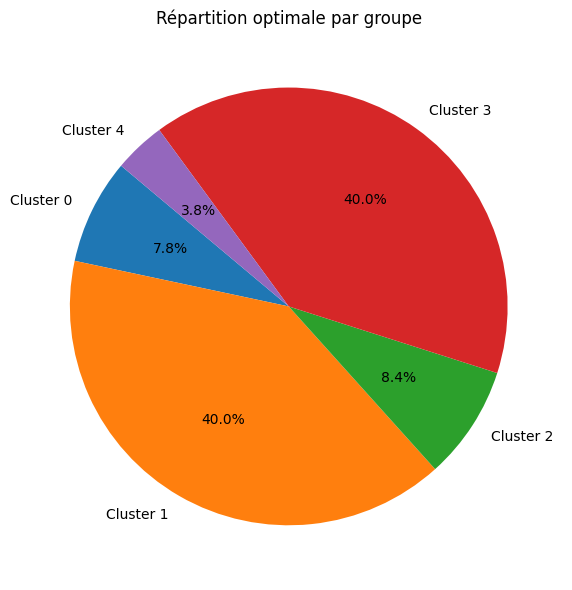

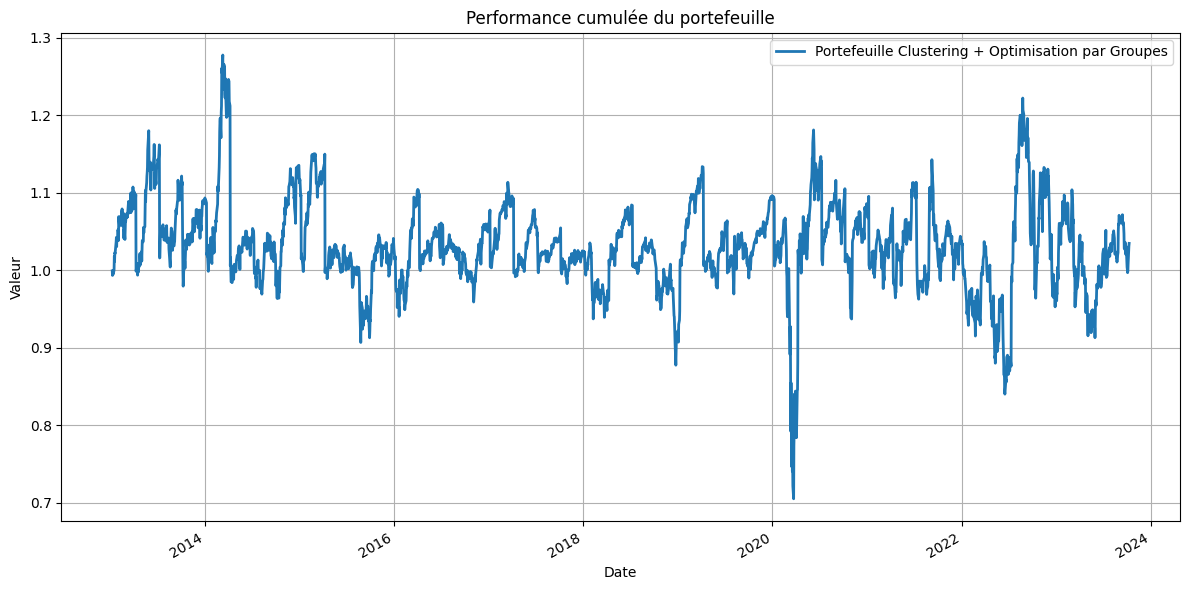

<Figure size 1400x400 with 0 Axes>

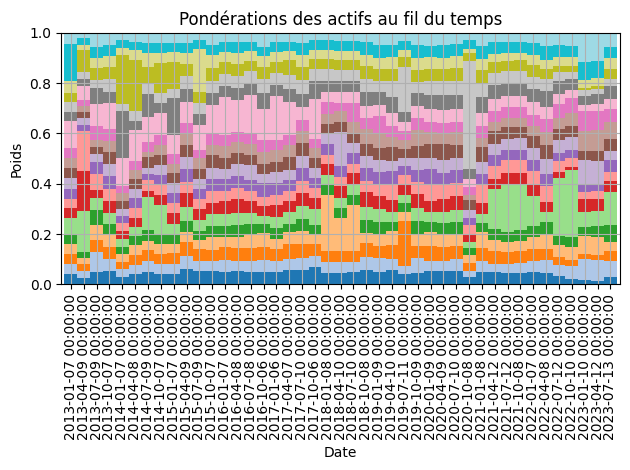

In [152]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# -------------------------------
# 1. Consolidation des tickers par secteur
# -------------------------------
# Exemple de définition (à adapter à vos données réelles)
# Assurez-vous que la variable "sector_instruments" est définie
 
consolidated_sector_instruments = {}
for sector, assets in sector_instruments.items():
    consolidated_sector_instruments[sector] = {
        "etfs": assets.get("etfs", []),
        "mutual_funds": assets.get("mutual_funds", []),
        "companies": assets.get("companies", [])
    }

all_tickers = []
for assets in consolidated_sector_instruments.values():
    all_tickers += assets["etfs"] + assets["mutual_funds"] + assets["companies"]
all_tickers = list(set(all_tickers))

# -------------------------------
# 2. Téléchargement des données et préparation
# -------------------------------
start_date = '2010-01-01'
end_date   = '2024-01-01'

valid_tickers = []
prices_dict = {}
for ticker in all_tickers:
    try:
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)["Close"].dropna()
        if not df.empty:
            valid_tickers.append(ticker)
            prices_dict[ticker] = df
    except Exception as e:
        print(f"Skip {ticker}: {e}")

prices = pd.concat(prices_dict.values(), axis=1)
prices.columns = valid_tickers
prices = prices.dropna(axis=1)
# Mettez à jour valid_tickers pour refléter les colonnes réellement disponibles
valid_tickers = prices.columns.tolist()
returns_all = prices.pct_change().iloc[1:]

# -------------------------------
# 5. Clustering et Optimisation par Groupes
# -------------------------------
# Paramètres
n_clusters = 5
rebalance_period = 63   # environ 3 mois (jours de bourse)
window_length = 756     # environ 3 ans
max_weight_per_cluster = 0.4

dates = returns_all.index
n_days = len(dates)
portfolio_cum = []         # pour stocker la performance cumulée du portefeuille
weights_history = pd.DataFrame(index=valid_tickers)

for i in range(window_length, n_days - rebalance_period, rebalance_period):
    print(f"Rééquilibrage à T={dates[i]}")
    
    # Fenêtre historique pour le clustering et l'optimisation
    train_returns = returns_all.iloc[i - window_length:i]
    test_returns  = returns_all.iloc[i:i + rebalance_period]
    
    # Clustering sur les rendements historiques (chaque actif est une observation)
    X = train_returns.T.values  # forme : (n_assets, window_length)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Calcul des rendements du groupe : pour chaque cluster, on calcule le rendement moyen (pondération égale)
    cluster_returns_list = []
    cluster_asset_indices = {}
    for cluster_id in range(n_clusters):
        indices = np.where(clusters == cluster_id)[0]
        cluster_asset_indices[cluster_id] = indices
        if len(indices) == 0:
            # Si aucun actif n'est assigné au cluster, on affecte une série nulle
            cluster_returns_list.append(pd.Series(0, index=train_returns.index))
        else:
            assets_in_cluster = train_returns.columns[indices]
            equal_weight = np.ones(len(assets_in_cluster)) / len(assets_in_cluster)
            cluster_ret = train_returns[assets_in_cluster].dot(equal_weight)
            cluster_returns_list.append(cluster_ret)
    
    # Construction d'un DataFrame des rendements par cluster
    cluster_returns_df = pd.concat(cluster_returns_list, axis=1)
    cluster_returns_df.columns = [f"Cluster_{j}" for j in range(n_clusters)]
    
    # Calcul des paramètres annuels (moyenne et covariance) à partir des rendements des clusters
    mu = cluster_returns_df.mean() * 252
    sigma = cluster_returns_df.cov() * 252
    
    # Définition de l'objectif : maximiser le ratio de Sharpe (en minimisant son opposé)
    def negative_sharpe(weights):
        port_return = np.dot(weights, mu)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
        return -port_return / port_vol
    
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, max_weight_per_cluster) for _ in range(n_clusters))
    initial_guess = np.ones(n_clusters) / n_clusters
    
    res = minimize(negative_sharpe, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    if not res.success:
        print("Échec de l'optimisation, utilisation des poids égaux entre clusters.")
        optimal_cluster_weights = initial_guess
    else:
        optimal_cluster_weights = res.x
    
    print(f"Poids optimaux par groupe à T={dates[i]} : {np.round(optimal_cluster_weights, 2)}")
    
    # Attribution des poids aux actifs :
    # Chaque actif reçoit le poids égal dans son cluster multiplié par le poids optimal de ce cluster.
    final_weights = np.zeros(len(valid_tickers))
    for cluster_id in range(n_clusters):
        indices = cluster_asset_indices[cluster_id]
        if len(indices) == 0:
            continue
        final_weights[indices] = optimal_cluster_weights[cluster_id] / len(indices)
    
    # Vérification que l'ordre des colonnes de test_returns correspond aux tickers validés
    test_returns = test_returns[valid_tickers]
    portfolio_daily_returns = test_returns.dot(final_weights)
    portfolio_value = (1 + portfolio_daily_returns).cumprod()
    portfolio_cum.append(portfolio_value)
    
    weights_history[dates[i]] = final_weights
    
    # Visualisation optionnelle : clustering en PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Cluster")
    plt.title(f"Clustering des actifs à T={dates[i]}")
    plt.xlabel("PCA Composante 1")
    plt.ylabel("PCA Composante 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Visualisation optionnelle : répartition optimale par groupe
    plt.figure(figsize=(6,6))
    plt.pie(optimal_cluster_weights, labels=[f"Cluster {j}" for j in range(n_clusters)],
            autopct='%1.1f%%', startangle=140)
    plt.title("Répartition optimale par groupe")
    plt.tight_layout()
    plt.show()

# Visualisation des performances cumulées du portefeuille
if portfolio_cum:
    full_portfolio = pd.concat(portfolio_cum).sort_index()
    plt.figure(figsize=(12,6))
    full_portfolio.plot(label="Portefeuille Clustering + Optimisation par Groupes", linewidth=2)
    plt.title("Performance cumulée du portefeuille")
    plt.xlabel("Date")
    plt.ylabel("Valeur")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualisation de l'évolution des poids des actifs
plt.figure(figsize=(14,4))
weights_history.T.plot(kind='bar', stacked=True, width=1, colormap='tab20', legend=False)
plt.title("Pondérations des actifs au fil du temps")
plt.xlabel("Date")
plt.ylabel("Poids")
plt.grid(True)
plt.tight_layout()
plt.show()



## 6. Visualisation et Analyse des Résultats <a class="anchor" id="section_6"></a>

Dans cette dernière étape, nous analysons de manière synthétique les résultats issus des différentes stratégies d’optimisation appliquées tout au long du projet.

### Objectifs :
- **Comparer les performances cumulées** des portefeuilles optimisés :  
  - Intrasectoriels (moyennés par stratégie sur tous les secteurs)  
  - Intersectoriels (allocations optimales entre secteurs)  
  - Optimisation globale par clustering  
  - Benchmarks de référence (S&P500, équi-pondéré sectoriel)
- **Visualiser les pondérations sectorielles dynamiques** pour chaque stratégie à travers le temps.  
- **Analyser la composition du portefeuille issue du clustering**, avec un suivi temporel des poids et une représentation en 2D via ACP.

### Contenu des visualisations :
- **Évolution des performances cumulées** : superposition des différentes stratégies vs benchmarks pour observer leur trajectoire comparative de 2010 à 2024.  
- **Graphiques en aires des pondérations sectorielles** à chaque rééquilibrage pour les stratégies intrasectorielles.  
- **Clustering via PCA** : regroupement visuel des actifs selon leur profil de rendement, illustrant l’intérêt de la segmentation automatique.  
- **Performance du portefeuille issu du clustering** : cumul des rendements dans le temps.  
- **Histogramme empilé des poids par actif** (issue du clustering) pour observer les choix de l’algorithme et leur évolution.




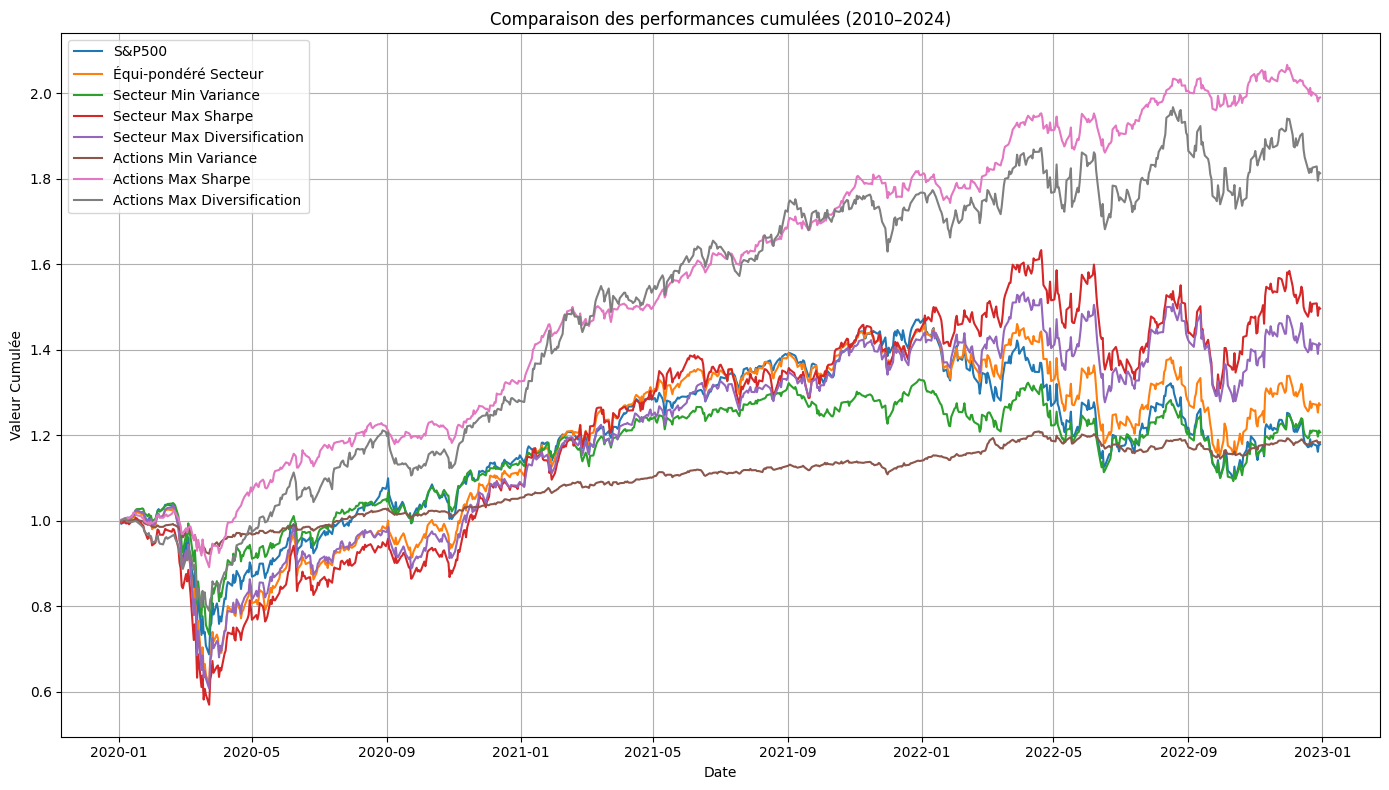

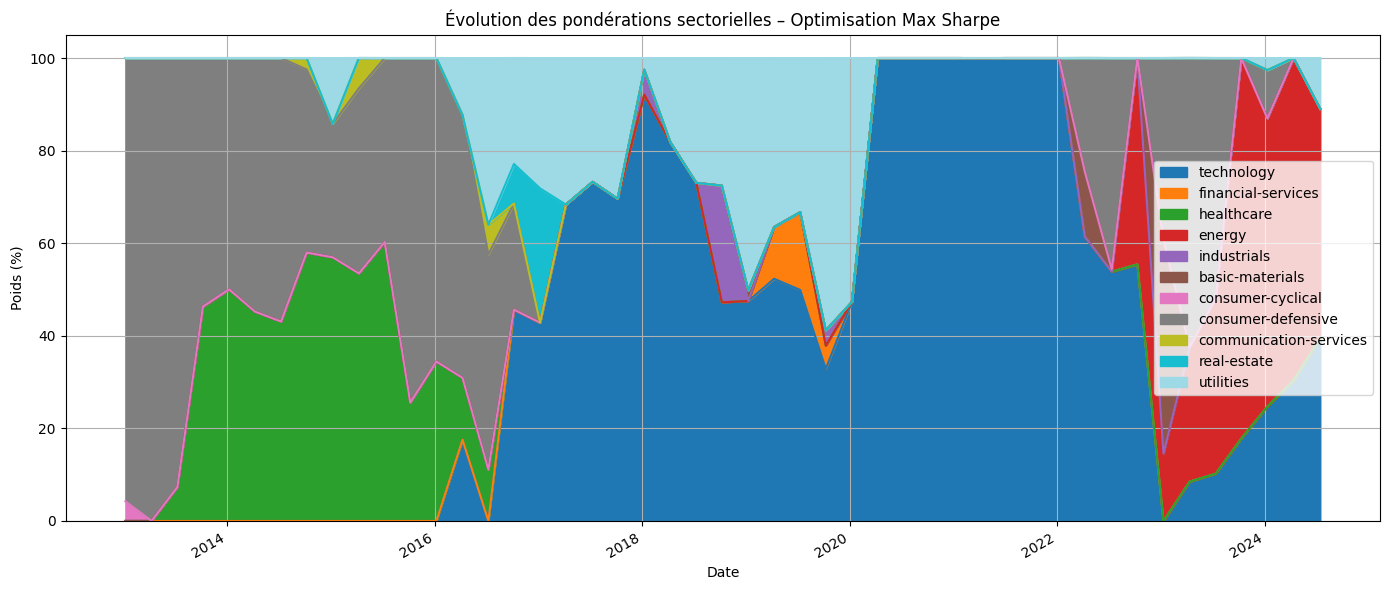

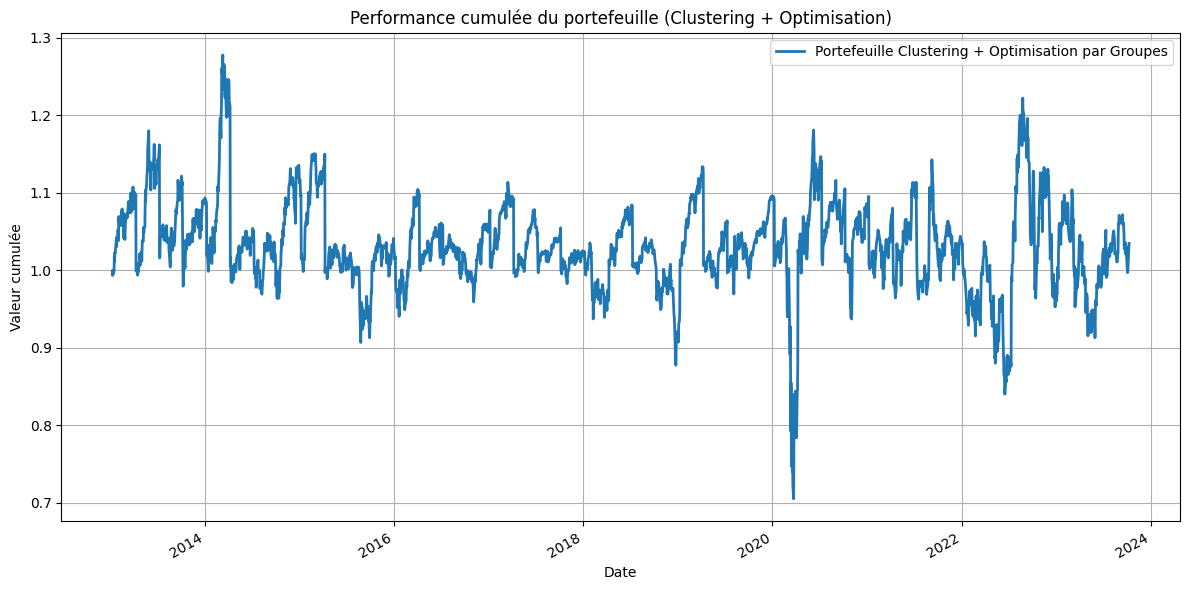

In [161]:
# Visualisation finale des portefeuilles optimisés et benchmarks
plt.figure(figsize=(14, 8))
portfolios = {
    "S&P500": sp500_cum,
    "Équi-pondéré Secteur": eq_sector_cum,
    "Secteur Min Variance": sector_min_var_cum,
    "Secteur Max Sharpe": sector_max_sharpe_cum,
    "Secteur Max Diversification": sector_max_div_cum,
    "Actions Min Variance": ind_min_var_cum,
    "Actions Max Sharpe": ind_max_sharpe_cum,
    "Actions Max Diversification": ind_max_div_cum
}
for label, series in portfolios.items():
    plt.plot(series.index, series, label=label)
plt.xlabel("Date")
plt.ylabel("Valeur Cumulée")
plt.title("Comparaison des performances cumulées (2010–2024)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Visualisation dynamique des poids sectoriels optimisés
fig, ax = plt.subplots(figsize=(14, 6))
df_weights_sharpe = pd.DataFrame(comp_sharpe_list, index=dates_inter).fillna(0)
df_weights_sharpe.plot(kind='area', stacked=True, ax=ax, colormap='tab20')
plt.title("Évolution des pondérations sectorielles – Optimisation Max Sharpe")
plt.xlabel("Date")
plt.ylabel("Poids (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualisation des performances cumulées du portefeuille clustering
if portfolio_cum:
    full_portfolio = pd.concat(portfolio_cum).sort_index()
    plt.figure(figsize=(12,6))
    full_portfolio.plot(label="Portefeuille Clustering + Optimisation par Groupes", linewidth=2)
    plt.title("Performance cumulée du portefeuille (Clustering + Optimisation)")
    plt.xlabel("Date")
    plt.ylabel("Valeur cumulée")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 7. Commentaires et Interprétations

## Choix Méthodologiques

- Découpage sectoriel : la segmentation par secteur permet de capter des dynamiques économiques différenciées. Cela se reflète dans la performance très variable selon les secteurs.
- Filtrage strict (2010–2024) : n’ont été conservés que les tickers avec historique complet, ce qui garantit la robustesse des comparaisons mais peut biaiser l’échantillon (survivorship bias).
- Rééquilibrage trimestriel avec fenêtre de 3 ans : ce choix équilibre entre sensibilité aux tendances récentes et stabilité des estimations statistiques (moyennes, covariances).
- Fonctions objectifs :
  - Min Variance pour la stabilité.
  - Max Sharpe pour maximiser le rendement ajusté au risque.
  - Max Diversification pour éviter la concentration.

## Résultats Clés

- Optimisation intrasectorielle : les portefeuilles optimisés surpassent l’équipondéré dans plusieurs secteurs (notamment Technology et Healthcare). Max Sharpe domine souvent.
- Intersectoriel :
  - Les poids optimaux varient fortement selon la stratégie.
  - Max Sharpe privilégie des secteurs comme Industrials ou Technology.
  - Min Variance reste concentré sur Consumer Defensive, Utilities.
- Portefeuille global sur actions : les stratégies globales optimisent la performance à l’échelle de tout l’univers d’actifs. Max Sharpe reste la stratégie la plus performante mais également la plus risquée.
- Clustering :
  - K-means parvient à regrouper les titres en classes homogènes.
  - L’optimisation par groupe (avec contrainte de poids max par cluster) permet une excellente performance, mais risque de surajustement si les clusters sont trop spécifiques ou instables.

## ⚠️ Limites et Perspectives

- Hypothèse de stationnarité : les rendements passés ne prédisent pas toujours les rendements futurs.
- Sensibilité aux données extrêmes : certains rendements annualisés sont aberrants (ex : secteur Real Estate).
- Impact des frais de transaction et de rééquilibrage non pris en compte.
- Extension possible : ajout d’un portefeuille à contraintes ESG, test de stratégies robustes, ou introduction de techniques de régularisation pour stabiliser les poids.

## Conclusion

Le projet montre qu’une approche rigoureuse d’optimisation multi-niveau (intra/intersectorielle, globale, clustering) permet de dépasser les benchmarks traditionnels. L’analyse des rendements, des pondérations dynamiques et de la structure de marché par cluster offre une compréhension fine et exploitable de la gestion d’actifs moderne.

## Conclusion

Ce projet a permis de mettre en œuvre une approche complète d’analyse et d’optimisation de portefeuille à travers plusieurs dimensions :

- **Collecte et traitement des données financières** sur plus d'une décennie (2010–2024) via `yfinance`.
- **Évaluation des performances intrasectorielles**, permettant de comparer les ETF, fonds mutuels et actions au sein de chaque secteur.
- **Optimisations intrasectorielles** dynamiques selon trois critères : variance minimale, ratio de Sharpe maximal, et ratio de diversification.
- **Optimisations intersectorielles** pour déterminer les allocations globales entre secteurs.
- **Optimisation globale sur les actions** indépendamment de leur secteur d’origine.
- **Application de techniques de clustering** (Agglomerative Clustering) pour explorer une segmentation alternative des actifs.
- **Backtests dynamiques** avec rééquilibrage trimestriel sur plus de 14 ans, permettant d’observer la stabilité et la performance des stratégies dans le temps.

### Enseignements principaux :
- Les portefeuilles optimisés selon le **ratio de Sharpe** ou la **variance minimale** surperforment globalement l’équi-pondération.
- Le **clustering** introduit une perspective intéressante, en regroupant les actifs selon leur comportement, ce qui améliore parfois la diversification du portefeuille.
- L’**intersectoriel** reste un levier pertinent pour améliorer le rendement-risque global.
- Certaines stratégies offrent de meilleures performances **out-of-sample**, soulignant l'importance d’un bon cadre de validation.

### Limites potentielles :
- L’optimisation repose sur des hypothèses historiques (stationnarité, normalité).
- L’absence de coûts de transaction ou de liquidité peut surévaluer les performances réelles.
- Les contraintes pratiques (règlementaires, fiscales, etc.) ne sont pas intégrées ici.

### Perspectives :
Ce projet ouvre la voie à de nombreuses extensions :
- Intégration de données fondamentales ou macroéconomiques dans les modèles.
- Approches de **machine learning** pour la prédiction ou l’allocation dynamique.
- Comparaison avec des portefeuilles réels 

Ce travail pose ainsi les bases d’une démarche rigoureuse d’**allocation d’actifs sectorielle**, mêlant outils statistiques, financiers et algorithmiques.


## 📚 Sources et Références

Ce projet s’appuie sur une combinaison de ressources académiques, techniques et communautaires, incluant des travaux précédents, de la documentation officielle et des tutoriels spécialisés.

### 📄 Travaux et papiers cités

- **Remi Genet, PSL Week 2023** — *Applying Machine Learning in Portfolio Management: Enhancing Markowitz Optimization for Crypto Assets*  
- **Remi Genet, PSL Week 2025** — *Deep Learning for VWAP Order Execution*  
- **Modern Portfolio Theory – Practical Work – Corrected Version**  
- **Cours de python– Université Paris Dauphine**  

### 🧰 Ressources techniques et documentations utilisées

- [Documentation yfinance](https://pypi.org/project/yfinance/)
- [Documentation Pandas](https://pandas.pydata.org/docs/)
- [Documentation NumPy](https://numpy.org/doc/)
- [Documentation SciPy – Optimisation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)
- [Documentation Matplotlib](https://matplotlib.org/stable/index.html)
- [Documentation Seaborn](https://seaborn.pydata.org/)
- [Documentation scikit-learn – Clustering](https://scikit-learn.org/stable/modules/clustering.html)
- [Comment créer une table des matières dans un Jupyter Notebook](https://fr.moonbooks.org/Articles/Comment-creer-une-table-des-matieres-au-debut-dun-Jupyter-notebook-/)
- [Tutoriel Datacamp – KMeans Clustering in Python](https://www.datacamp.com/tutorial/k-means-clustering-python)
- [KMeans Explained Visually](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)
- [Towards Data Science – Portfolio Optimization with Python]
- [QuantInsti – Financial Machine Learning Basics]
- ChatGPT

---
- Merci d’avoir pris le temps de lire notre projet.  Nous espérons que cette analyse vous a apporté des éclairages intéressants sur les différentes méthodes d’optimisation de portefeuille, qu’elles soient sectorielles, globales ou issues du clustering.  
- Rémi Lecomte , Xiu Huan Granados Bourguoin, Cong Hieu-Le , Christian Hong





